# Imports

In [ ]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [ ]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

web-scraper-order                        web-scraper-start-url  newpage  \
0      1710822472-1  https://www.nba.com/stats/players/boxscores      NaN   
1      1710822472-2  https://www.nba.com/stats/players/boxscores      NaN   
2      1710822472-3  https://www.nba.com/stats/players/boxscores      NaN   
3      1710822472-4  https://www.nba.com/stats/players/boxscores      NaN   
4      1710822472-5  https://www.nba.com/stats/players/boxscores      NaN   

  team      mathcup    gamedate winloss  minuters  pts  fgm  ...  dreb reb  \
0  ATL    ATL @ LAL  03/18/2024     NaN        13    8    4  ...     4   8   
1  PHI  PHI vs. MIA  03/18/2024       W        19    8    3  ...     3   4   
2  MIA    MIA @ PHI  03/18/2024       L        16   11    4  ...     1   2   
3  MIA    MIA @ PHI  03/18/2024       L        32   20    8  ...    10  13   
4  PHI  PHI vs. MIA  03/18/2024       W        24   12    4  ...     1   2   

   ast  stl blk  tov  pfo plusminus   fp1         player  
0    0    1   1    1    1        -7  22.6   Clint Capela  
1    3    2   2    1    2        -1  28.3       Mo Bamba  
2    1    1   1    0    1         1  20.9  Thomas Bryant  
3    6    0   0    4    1       -19  40.6    Bam Adebayo  
4    1    0   1    1    1        11  17.9    Buddy Hield  

[5 rows x 29 columns]

In [ ]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [ ]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

<ipython-input-276-2dcc550019b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['matchup'] = player_df['mathcup']
<ipython-input-276-2dcc550019b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.drop(columns=['mathcup'], inplace=True)


In [ ]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points)
    return total_points

In [ ]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [ ]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [ ]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

<ipython-input-280-211a0410e864>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
<ipython-input-280-211a0410e864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L


team   gamedate  winloss  minuters  pts  fgm  fga fgpercent  3pm  3pa  \
152  BOS 2024-03-17        1        35   14    6   15      40.0    2    5   
153  BOS 2024-03-17        1        23    9    3    7      42.9    3    6   
154  BOS 2024-03-17        1        20   14    5    9      55.6    0    0   
155  WAS 2024-03-17        0        22    8    4    7      57.1    0    2   
156  WAS 2024-03-17        0        15    0    0    1       0.0    0    1   

     ... tov  pfo  plusminus            player      matchup  is_home    fp  \
152  ...   1    0         16  Payton Pritchard    BOS @ WAS        0  28.0   
153  ...   0    0          7    Svi Mykhailiuk    BOS @ WAS        0  13.0   
154  ...   1    1          9       Luke Kornet    BOS @ WAS        0  17.0   
155  ...   0    3        -17      Johnny Davis  WAS vs. BOS        1  13.0   
156  ...   1    2        -14    Eugene Omoruyi  WAS vs. BOS        1   3.0   

     opp_team             game_id  days_since  
152       WAS  WAS.BOS.2024-03-17         145  
153       WAS  WAS.BOS.2024-03-17         145  
154       WAS  WAS.BOS.2024-03-17         145  
155       BOS  WAS.BOS.2024-03-17         145  
156       BOS  WAS.BOS.2024-03-17         145  

[5 rows x 30 columns]

In [ ]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [ ]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [ ]:
team_df.head()

web-scraper-order                      web-scraper-start-url  newpage team  \
0      1710880555-1  https://www.nba.com/stats/teams/boxscores      NaN  CLE   
1      1710880555-2  https://www.nba.com/stats/teams/boxscores      NaN  IND   
2      1710880555-3  https://www.nba.com/stats/teams/boxscores      NaN  DET   
3      1710880555-4  https://www.nba.com/stats/teams/boxscores      NaN  BOS   
4      1710880555-5  https://www.nba.com/stats/teams/boxscores      NaN  PHI   

       matchup        date winloss  min  pts  fgm  ...  ftpercent  oreb  dreb  \
0    CLE @ IND  03/18/2024       W  240  108   38  ...       71.4     9    30   
1  IND vs. CLE  03/18/2024       L  240  103   42  ...       62.5    14    31   
2    DET @ BOS  03/18/2024       L  240   94   36  ...       86.7     8    35   
3  BOS vs. DET  03/18/2024       W  240  119   43  ...       84.6    15    38   
4  PHI vs. MIA  03/18/2024       W  240   98   37  ...       91.7     7    39   

   reb  ast  stl  blk  tov  pfidk  plusminus  
0   39   27    8    4   14     18          5  
1   45   28    8    3   11     24         -5  
2   43   21    6    3   13     15        -25  
3   53   30    8    8   11      9         25  
4   46   23    7   12   12     16          7  

[5 rows x 27 columns]

In [ ]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [ ]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [ ]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

<ipython-input-286-a5d1a32ab59e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
<ipython-input-286-a5d1a32ab59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
<ipython-input-286-a5d1a32ab59e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

team      matchup        date winloss  min  pts  fgm  fga  fgpercent  3pm  \
16  LAC  LAC vs. ATL  03/17/2024       L  240   93   28   74       37.8   11   
17  ATL    ATL @ LAC  03/17/2024       W  240  110   41   84       48.8   17   
18  BKN    BKN @ SAS  03/17/2024       L  265  115   47  102       46.1    8   
19  SAS  SAS vs. BKN  03/17/2024       W  265  122   46   99       46.5    9   
20  ORL  ORL vs. TOR  03/17/2024       W  240  111   43   85       50.6   11   

    ...  ast  stl  blk  tov  pfidk  plusminus   gamedate  is_home  opp_team  \
16  ...   17   10    5   16     13        -17 2024-03-17        1       ATL   
17  ...   32   10    7   16     22         17 2024-03-17        0       LAC   
18  ...   29   13    5   12     20         -7 2024-03-17        0       SAS   
19  ...   30    6   10   18     17          7 2024-03-17        1       BKN   
20  ...   22    7    4   15     16         15 2024-03-17        1       TOR   

               game_id  
16  LAC.ATL.2024-03-17  
17  LAC.ATL.2024-03-17  
18  SAS.BKN.2024-03-17  
19  SAS.BKN.2024-03-17  
20  ORL.TOR.2024-03-17  

[5 rows x 28 columns]

### Merging

In [ ]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [ ]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [ ]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [ ]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [ ]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

player team opp_team   gamedate  days_since  winloss  minuters  \
0  Payton Pritchard  BOS      WAS 2024-03-17         145        1        35   
1    Svi Mykhailiuk  BOS      WAS 2024-03-17         145        1        23   
2       Luke Kornet  BOS      WAS 2024-03-17         145        1        20   
3        Sam Hauser  BOS      WAS 2024-03-17         145        1        23   
4     Neemias Queta  BOS      WAS 2024-03-17         145        1         8   

   pts  fgm  fga  ... opp_oreb  opp_dreb  opp_reb opp_ast  opp_stl  opp_blk  \
0   14    6   15  ...       10        30       40      24        3        5   
1    9    3    7  ...       10        30       40      24        3        5   
2   14    5    9  ...       10        30       40      24        3        5   
3   30   10   13  ...       10        30       40      24        3        5   
4    0    0    0  ...       10        30       40      24        3        5   

  opp_tov  opp_pfidk  opp_plusminus    fp  
0      16         20            -26  28.0  
1      16         20            -26  13.0  
2      16         20            -26  17.0  
3      16         20            -26  29.0  
4      16         20            -26   1.0  

[5 rows x 70 columns]

In [ ]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [ ]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.3 One-Hot Encoding

In [ ]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team'])

In [ ]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [ ]:
df.head()

player team   gamedate  days_since  winloss  minuters  pts  fgm  \
0  Payton Pritchard  BOS 2024-03-17         145        1        35   14    6   
1    Svi Mykhailiuk  BOS 2024-03-17         145        1        23    9    3   
2       Luke Kornet  BOS 2024-03-17         145        1        20   14    5   
3        Sam Hauser  BOS 2024-03-17         145        1        23   30   10   
4     Neemias Queta  BOS 2024-03-17         145        1         8    0    0   

   fga fgpercent  ...  opp_team_ORL  opp_team_PHI opp_team_PHX  opp_team_POR  \
0   15      40.0  ...             0             0            0             0   
1    7      42.9  ...             0             0            0             0   
2    9      55.6  ...             0             0            0             0   
3   13      76.9  ...             0             0            0             0   
4    0         -  ...             0             0            0             0   

   opp_team_SAC opp_team_SAS  opp_team_TOR  opp_team_UTA  opp_team_WAS    fp  
0             0            0             0             0             1  28.0  
1             0            0             0             0             1  13.0  
2             0            0             0             0             1  17.0  
3             0            0             0             0             1  29.0  
4             0            0             0             0             1   1.0  

[5 rows x 99 columns]

In [ ]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
       'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov',
       'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date', 'min',
       'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'opp_team_ATL', 'opp_team_BKN',
       'opp_team_BOS', 'opp_team_CHA', 'opp_team_CHI', 'opp_team_CLE',
       'opp_team_DAL', 'opp_team_DEN', 'opp_te

## 1.4 Train-Test Split

In [54]:
# Split the data
X = df.drop(['fp'], axis=1)  # Features
y = df['fp']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [55]:
import numpy as np

# Identify and print columns that are np.ndarrays with dtype 'object'
for column in df.columns:
    if isinstance(df[column].iloc[0], np.ndarray) and df[column].iloc[0].dtype == 'object':
        print(column)


for column in df.columns:
    if df[column].apply(lambda x: isinstance(x, np.ndarray)).any():
        unique_types = df[column].apply(type).unique()
        if len(unique_types) > 1 or unique_types[0] == np.object_:
            print(f"Column: {column}, Types: {unique_types}")


In [71]:
from torch.utils.data import DataLoader, Dataset
class NBAFantasyDataset(Dataset):

    def __init__(self, dataframe):
        """
        dataframe: A DataFrame where each row is a game with columns for player details, game stats, and fantasy points ('fp').
        """
        self.data = dataframe
        # Sort the dataframe by 'gamedate' to ensure chronological order
        self.data.sort_values(by=['player', 'gamedate'], inplace=True)
        self.players = dataframe['player'].unique()

    def __len__(self):
        return len(self.players)

    def __getitem__(self, idx):
        player = self.players[idx]
        player_data = self.data[self.data['player'] == player]

        # Ensure there's at least five previous games to predict the next game
        if len(player_data) < 6:
            return None

        # Randomly select a game, excluding the first five games
        game_idx = np.random.randint(5, len(player_data))
        previous_games = player_data.iloc[:game_idx]
        target_game = player_data.iloc[game_idx]

        # Exclude non-numeric columns from features
        exclude_columns = ['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup']
        features = previous_games.drop(columns=exclude_columns)

        # Replace non-numeric strings with NaN
        features = features.replace('-', np.nan)

        # Convert all values to floats
        features = features.astype(float)

        # Handle NaN values (e.g., fill with 0)
        features = np.nan_to_num(features)

        target = target_game['fp']
        print(features)

        return torch.tensor(features, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [87]:
from torch.nn.utils.rnn import pad_sequence
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    features, targets = zip(*batch)

    # Pad the sequences to the same length
    padded_features = pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    return padded_features, targets

# Update your DataLoader to use the new collate function
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [88]:
dataset = NBAFantasyDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [89]:
import torch

for i in range(5):
    sample = dataset[i]
    if sample is not None:
        features, target = sample
        print(f"Sample {i} - Features type: {type(features)}, Target type: {type(target)}")
    else:
        print(f"Sample {i} is None")

[[ 38.   0.   4. ...   0.   0.   0.]
 [ 39.   0.  19. ...   0.   0.   0.]
 [ 43.   1.   7. ...   0.   1.   0.]
 ...
 [107.   1.   1. ...   0.   0.   0.]
 [109.   1.   6. ...   0.   0.   0.]
 [111.   1.   0. ...   0.   0.   1.]]
Sample 0 - Features type: <class 'torch.Tensor'>, Target type: <class 'torch.Tensor'>
[[  5.    0.    6.    7.    2.    2.  100.    2.    2.  100.    1.    1.
  100.    0.    1.    1.    0.    0.    0.    0.    0.   10.    1.  240.
  110.   39.   86.   45.3  16.   44.   36.4  16.   20.   80.   12.   27.
   39.   22.   10.    3.   23.   22.  -17.  127.   47.   93.   50.5  15.
   37.   40.5  18.   22.   81.8  13.   33.   46.   32.   15.    2.   17.
   17.   17.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    1.   15.    0.    0.    4.    0.    0.    3.    0.    0.    0.
    0.    0.    0.    0.    2.    0.    0.    0.   

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class BasketballRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasketballRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [94]:
# Assuming the input size (number of features) is 79 as described in your input list
input_size = 92  # Number of input features
hidden_size = 128  # Number of hidden units in the RNN layer
num_layers = 2  # Number of stacked RNN layers
output_size = 1  # Predicting a single value (fp)

# Initialize the RNN model
model = BasketballRNN(input_size, hidden_size, num_layers, output_size)
print(model)

BasketballRNN(
  (rnn): RNN(92, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    # Move the model to the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    criterion = nn.MSELoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (features, targets) in enumerate(train_loader):
            # Move data to device
            features, targets = features.to(device), targets.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:  # Print loss every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Print average loss per epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

    print("Training complete.")

In [96]:
num_epochs = 10  # Number of epochs for training
learning_rate = 0.001  # Learning rate

train_model(model, dataloader, num_epochs, learning_rate)

[[ 1.  1. 39. ...  0.  0.  0.]
 [ 3.  1. 41. ...  0.  0.  0.]
 [ 6.  1. 28. ...  0.  0.  1.]
 ...
 [95.  0. 30. ...  0.  0.  0.]
 [97.  1. 38. ...  0.  0.  0.]
 [98.  1. 39. ...  0.  0.  0.]]
[[  0.    1.   35.   15.    7.   11.   63.6   1.    2.   50.    0.    0.
    0.    2.    5.    7.    5.    2.    1.    0.    0.    6.    1.  240.
  119.   48.   91.   52.7  14.   34.   41.2   9.   12.   75.    9.   33.
   42.   29.    9.    6.   12.   15.   12.  107.   41.   90.   45.6  10.
   29.   34.5  15.   20.   75.   13.   31.   44.   23.    5.    4.   12.
   18.  -12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   30.   10.    5.   11.   45.5   0.    1.    0.    0.    1.
    0.    1.    1.    2.    3.    3.    1.    1.    3.    8.    0.  240.
  108.   41.   88.   46.6  14.   37.   37.8  12.   18.   66.7   6.   34.
   40.   27.   11.   10.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 11.    0.    4.    0.    0.    2.    0.    0.    2.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.   -3.    0.  240.
  101.   37.   84.   44.    8.   30.   26.7  19.   21.   90.5  10.   30.
   40.   17.    6.   10.   17.   21.  -19.  120.   46.  101.   45.5  12.
   33.   36.4  16.   19.   84.2  19.   32.   51.   29.    6.    9.   16.
   18.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 15.    0.   10.    3.    1.    3.   33.3   0.    2.    0.    1.    2.
   50.    0.    0.    0.    1.    0.    1.    1.    1.   -4.    0.  240.
   94.   36.   85.   42.4   7.   25.   28.   15.   24.   62.5   5.   29.
   34.   20.    7.    6.    9.   18.  -34.  128.   51.   93.   54.8  14.
   33.   42.4  12.   19.   63.2  14.   43.   57.   26.    4.    4.   13.
   23.   34.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 20. ...  0.  0.  0.]
 [ 3.  0. 21. ...  0.  0.  0.]
 [ 4.  0. 19. ...  0.  0.  0.]
 ...
 [69.  0. 16. ...  1.  0.  0.]
 [71.  1. 28. ...  0.  0.  1.]
 [73.  1. 25. ...  0.  0.  1.]]
[[ 5.  0.  6. ...  0.  0.  0.]
 [22.  1.  2. ...  1.  0.  0.]
 [27.  1.  1. ...  0.  0.  1.]
 ...
 [71.  0.  2. ...  0.  0.  0.]
 [76.  0.  1. ...  0.  1.  0.]
 [85.  0.  7. ...  0.  0.  0.]]
[[ 1.  1. 20. ...  0.  0.  0.]
 [ 3.  0. 25. ...  0.  0.  0.]
 [ 6.  0. 19. ...  0.  0.  0.]
 ...
 [76.  0. 21. ...  0.  0.  0.]
 [78.  0. 21. ...  0.  0.  0.]
 [80.  0. 19. ...  0.  0.  0.]]
[[  6.   0.   1. ...   0.   0.   0.]
 [  8.   0.  20. ...   0.   1.   0.]
 [ 10.   0.  12. ...   0.   0.   0.]
 ...
 [100.   0.  23. ...   0.   0.   0.]
 [101.   0.  32. ...   0.   0.   0.]
 [103.   0.  36. ...   0.   0.   0.]]
[[  1.   0.  27. ...   0.   0.   0.]
 [  3.   1.  30. ...   0.   0.   0.]
 [  4.   1.  31. ...   0.   0.   0.]
 ...
 [121.   0.  35. ...   0.   0.   0.]
 [123.   0.  21. ...   0.   0.   0.]
 [125.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 15. ...  0.  1.  0.]
 [ 3.  0. 26. ...  0.  0.  0.]
 [ 5.  1. 14. ...  0.  0.  0.]
 ...
 [63.  0.  8. ...  0.  0.  0.]
 [66.  1. 25. ...  0.  0.  0.]
 [68.  1. 26. ...  0.  0.  0.]]
[[  4.   0.   5. ...   0.   0.   0.]
 [  7.   1.   3. ...   0.   0.   0.]
 [ 15.   1.   2. ...   0.   0.   0.]
 ...
 [133.   0.  26. ...   0.   0.   0.]
 [136.   1.  28. ...   0.   0.   0.]
 [138.   0.  23. ...   0.   0.   0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  1. 28. ...  0.  0.  0.]
 [ 5.  0. 22. ...  0.  0.  0.]
 ...
 [17.  0. 27. ...  0.  0.  0.]
 [19.  1. 32. ...  0.  0.  0.]
 [21.  1. 25. ...  0.  0.  0.]]
[[  4.    1.    2.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -7.    1.  240.
  106.   44.   86.   51.2  12.   34.   35.3   6.    8.   75.    7.   40.
   47.   30.    9.    3.   16.   17.   16.   90.   35.   87.   40.2  12.
   38.   31.6   8.   14.   57.1   9.   33.   42.   24.    6.    1.   15.
   12.  -16.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0.  2. ...  0.  0.  0.]
 [ 4.  0.  6. ...  0.  0.  0.]
 [ 8.  1.  7. ...  0.  0.  0.]
 ...
 [36.  0. 15. ...  0.  0.  0.]
 [37.  0. 14. ...  0.  0.  0.]
 [39.  1. 27. ...  0.  0.  0.]]
[[  1.   0.  28. ...   0.   0.   0.]
 [  3.   0.  32. ...   0.   0.   0.]
 [  6.   1.  31. ...   0.   0.   0.]
 ...
 [137.   0.  38. ...   0.   0.   0.]
 [138.   1.  33. ...   0.   0.   0.]
 [141.   0.  25. ...   0.   0.   0.]]
[[ 8.  0. 22. ...  0.  0.  0.]
 [10.  1. 22. ...  0.  0.  1.]
 [13.  1. 22. ...  0.  0.  0.]
 ...
 [27.  1. 20. ...  0.  0.  0.]
 [29.  1. 25. ...  0.  0.  0.]
 [31.  0. 24. ...  0.  0.  0.]]
[[  1.   1.  34. ...   0.   0.   0.]
 [  3.   0.  34. ...   0.   0.   0.]
 [  4.   0.  33. ...   0.   0.   0.]
 ...
 [113.   1.  31. ...   0.   0.   0.]
 [121.   0.  34. ...   0.   0.   0.]
 [122.   0.  27. ...   0.   0.   0.]]
[[ 1.  0. 22. ...  0.  0.  0.]
 [ 3.  1. 27. ...  0.  0.  0.]
 [ 4.  0. 16. ...  0.  0.  0.]
 ...
 [48.  0. 15. ...  0.  0.  0.]
 [50.  1. 24. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 32. ...  0.  1.  0.]
 [ 3.  0. 36. ...  0.  0.  0.]
 [ 5.  1. 34. ...  0.  0.  0.]
 ...
 [41.  0. 36. ...  0.  0.  0.]
 [45.  1. 38. ...  0.  0.  0.]
 [48.  1. 34. ...  0.  0.  0.]]
[[ 1.  0. 21. ...  0.  0.  0.]
 [ 4.  1. 28. ...  0.  0.  0.]
 [10.  0. 20. ...  0.  0.  0.]
 ...
 [36.  0. 26. ...  0.  0.  0.]
 [38.  0. 27. ...  0.  0.  0.]
 [43.  0. 23. ...  0.  0.  0.]]
[[ 1.  1. 24. ...  0.  1.  0.]
 [ 3.  0. 16. ...  0.  0.  0.]
 [ 5.  1. 37. ...  0.  0.  0.]
 ...
 [49.  0. 17. ...  0.  0.  0.]
 [51.  1. 20. ...  0.  0.  0.]
 [53.  1. 25. ...  0.  1.  0.]]
[[ 1.  0.  5. ...  1.  0.  0.]
 [ 4.  1. 15. ...  0.  0.  0.]
 [ 8.  1.  5. ...  0.  0.  0.]
 ...
 [51.  1. 15. ...  0.  0.  0.]
 [53.  1. 16. ...  0.  0.  0.]
 [55.  1.  5. ...  0.  0.  0.]]
[[ 6.  1.  5. ...  0.  0.  1.]
 [ 8.  1. 11. ...  0.  0.  0.]
 [13.  0.  4. ...  0.  0.  0.]
 ...
 [73.  1. 15. ...  0.  1.  0.]
 [74.  1.  1. ...  0.  0.  0.]
 [76.  0.  5. ...  0.  0.  0.]]
[[11.  1.  4. ...  0.  0.  0.]
 [13.  0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 27. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 6.  0. 37. ...  0.  0.  0.]
 ...
 [90.  0. 24. ...  0.  0.  0.]
 [94.  0. 38. ...  0.  0.  0.]
 [96.  1. 31. ...  0.  0.  0.]]
[[  5.   1.   5. ...   0.   0.   0.]
 [ 21.   1.  13. ...   0.   0.   0.]
 [ 32.   1.   9. ...   0.   0.   1.]
 ...
 [128.   0.   5. ...   0.   0.   0.]
 [130.   0.   2. ...   0.   0.   0.]
 [133.   1.  11. ...   0.   0.   0.]]
[[ 1.  1. 20. ...  0.  0.  0.]
 [23.  1. 12. ...  0.  0.  0.]
 [25.  0. 15. ...  0.  0.  0.]
 ...
 [48.  1. 39. ...  0.  0.  0.]
 [50.  1. 36. ...  0.  0.  0.]
 [51.  0. 39. ...  0.  0.  0.]]
[[ 1.  0. 31. ...  0.  0.  0.]
 [ 3.  1. 34. ...  0.  0.  0.]
 [ 4.  0. 28. ...  0.  0.  0.]
 ...
 [37.  0. 28. ...  0.  0.  0.]
 [39.  1. 35. ...  0.  0.  0.]
 [43.  0. 23. ...  0.  0.  0.]]
[[ 1.  0. 26. ...  0.  0.  0.]
 [ 3.  0. 37. ...  0.  0.  0.]
 [ 5.  0. 34. ...  0.  0.  0.]
 ...
 [35.  0. 37. ...  0.  0.  0.]
 [36.  0. 32. ...  0.  0.  0.]
 [39.  0. 30. ...  0.  0.  0.]]
[[ 3

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 14. ...  0.  0.  0.]
 [ 3.  1.  8. ...  0.  0.  0.]
 [ 6.  0. 11. ...  0.  0.  0.]
 ...
 [24.  1. 20. ...  0.  0.  0.]
 [26.  1. 14. ...  0.  0.  0.]
 [28.  1. 12. ...  1.  0.  0.]]
[[  0.   1.  21. ...   0.   0.   0.]
 [  2.   0.  35. ...   0.   0.   0.]
 [  4.   1.  31. ...   0.   1.   0.]
 ...
 [ 97.   1.  13. ...   0.   0.   0.]
 [101.   0.  31. ...   0.   0.   0.]
 [103.   1.  27. ...   0.   0.   1.]]
[[  1.   0.   5. ...   0.   0.   0.]
 [  5.   0.   6. ...   0.   0.   0.]
 [ 15.   0.   9. ...   0.   0.   0.]
 ...
 [132.   0.  35. ...   0.   0.   0.]
 [134.   0.  23. ...   0.   0.   0.]
 [136.   0.  33. ...   0.   0.   0.]]
[[ 1.  1. 28. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 6.  0. 30. ...  0.  0.  0.]
 ...
 [39.  0. 34. ...  0.  0.  0.]
 [43.  0. 38. ...  0.  0.  0.]
 [45.  1. 30. ...  0.  0.  0.]]
[[ 1.  1. 22. ...  0.  0.  1.]
 [ 4.  1. 25. ...  0.  0.  0.]
 [ 6.  0. 21. ...  0.  0.  0.]
 ...
 [76.  1. 12. ...  0.  0.  0.]
 [78.  1. 26. ...  0.  0.  1.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  5.    0.    6.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    1.  240.
   95.   37.   90.   41.1   6.   32.   18.8  15.   18.   83.3   7.   22.
   29.   22.    8.    4.   10.   14.  -33.  128.   53.   88.   60.2  11.
   27.   40.7  11.   13.   84.6  10.   38.   48.   34.    8.    5.   13.
   21.   33.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 79.    1.   18.    4.    2.    5.   40.    0.    1.    0.    0.    0.
    0.    1.    2.    3.    2.    0.    0.    2.    1.   13.    1.  240.
  139.   53.   93.   57.   14.   35.   40.   19.   22.   86.4   8.   51.
   59.   41.    6.    8.   13.   10.   62.   77.   28.  101.   27.7  11.
   49.   22.4  10.   16.   62.5  13.   29.   42.   16.    8.    8.   10.
   19.  -62.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 23. ...  0.  0.  0.]
 [ 3.  0. 20. ...  0.  1.  0.]
 [ 5.  1. 26. ...  0.  0.  0.]
 ...
 [22.  0. 37. ...  0.  0.  0.]
 [24.  1. 20. ...  0.  0.  0.]
 [26.  1. 11. ...  0.  0.  0.]]
[[ 1.  0.  8. ...  0.  0.  0.]
 [ 4.  1. 11. ...  0.  0.  0.]
 [ 8.  0. 22. ...  0.  0.  0.]
 ...
 [88.  0. 14. ...  0.  0.  0.]
 [90.  0. 16. ...  0.  0.  0.]
 [92.  1. 13. ...  0.  0.  0.]]
[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 34. ...  0.  0.  0.]
 [ 6.  0. 29. ...  0.  0.  0.]
 ...
 [48.  1. 36. ...  0.  0.  0.]
 [50.  1. 29. ...  0.  0.  0.]
 [51.  0. 36. ...  0.  0.  0.]]
[[ 1.  1.  5. ...  0.  0.  0.]
 [ 6.  0.  1. ...  0.  0.  0.]
 [ 7.  0.  4. ...  0.  0.  0.]
 ...
 [45.  1. 28. ...  0.  0.  0.]
 [48.  1. 29. ...  0.  0.  0.]
 [52.  0. 27. ...  0.  0.  0.]]
[[ 15.   0.   8. ...   0.   0.   0.]
 [ 21.   0.   3. ...   0.   1.   0.]
 [ 22.   0.   3. ...   0.   0.   0.]
 ...
 [107.   0.  12. ...   0.   0.   0.]
 [109.   0.   2. ...   0.   0.   0.]
 [114.   0.   5. ...   0.   0.   0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.    6.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.  -10.    0.  240.
   86.   32.   79.   40.5  12.   34.   35.3  10.   16.   62.5   7.   24.
   31.   19.    6.    3.   19.   24.  -30.  116.   42.   87.   48.3   9.
   34.   26.5  23.   26.   88.5  17.   40.   57.   19.    8.    6.   16.
   20.   30.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    1.    1.    2.    0.    1.    0.    0.    1.    0.    2.    2.
  100.    0.    0.    0.    0.    0.    0.    0.    1.    0.    1.  240.
  107.   40.   87.   46.   13.   36.   36.1  14.   20.   70.   10.   43.
   53.   28.    4.    3.   11.   18.   18.   89.   32.   84.   38.1  11.
   41.   26.8  14.   19.   73.7   8.   35.   43.   20.    5.    6.   11.
   19.  -18.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  240.
  124.   45.   82.   54.9  19.   39.   48.7  15.   18.   83.3   5.   38.
   43.   30.    6.    4.   16.   19.   20.  104.   39.   94.   41.5  12.
   42.   28.6  14.   18.   77.8  13.   29.   42.   26.   10.    3.   13.
   16.  -20.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  5.    0.    8.   12.    5.    7.   71.4   1.    2.   50.    1.    1.
  100.    1.    3.    4.    1.    0.    0.    1.    0.   -5.    1.  240.
   95.   37.   90.   41.1   6.   32.   18.8  15.   18.   83.3   7.   22.
   29.   22.    8.    4.   10.   14.  -33.  128.   53.   88.   60.2  11.
   27.   40.7  11.   13.   84.6  10.   38.   48.   34.    8.    5.   13.
   21.   33.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    1.    2.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    2.    2.    0.    0.    0.    0.    0.  -10.    1.  240.
   96.   40.   87.   46.    9.   33.   27.3   7.   16.   43.8   4.   39.
   43.   20.    8.    5.   13.   22.    9.   87.   33.   90.   36.7   7.
   37.   18.9  14.   18.   77.8  16.   43.   59.   19.    7.    3.   19.
   17.   -9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    1.  240.
  105.   40.   84.   47.6   8.   31.   25.8  17.   21.   81.    9.   26.
   35.   24.    9.    7.   11.   15.  -18.  123.   45.   93.   48.4  14.
   41.   34.1  19.   24.   79.2  19.   33.   52.   28.    4.    6.   13.
   16.   18.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  6.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    8.    0.  240.
  112.   39.   91.   42.9  15.   28.   53.6  19.   24.   79.2  13.   28.
   41.   31.    6.    5.   17.   25.  -12.  124.   44.   83.   53.   13.
   29.   44.8  23.   28.   82.1   6.   38.   44.   21.    9.   10.   15.
   19.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 12.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    5.    1.  240.
  106.   43.   87.   49.4   8.   23.   34.8  12.   14.   85.7  10.   23.
   33.   25.    7.    6.   16.   23.  -14.  120.   43.   86.   50.    8.
   21.   38.1  26.   29.   89.7  14.   29.   43.   29.    8.   10.   18.
   13.   14.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  33. ...   0.   0.   0.]
 [  3.   0.  35. ...   0.   0.   0.]
 [  4.   0.  35. ...   0.   0.   0.]
 ...
 [126.   0.  25. ...   0.   0.   0.]
 [128.   1.  27. ...   0.   0.   0.]
 [130.   1.  34. ...   0.   0.   0.]]
[[ 1.  1. 19. ...  0.  0.  0.]
 [ 4.  1. 22. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [70.  1. 20. ...  0.  0.  0.]
 [71.  1. 24. ...  0.  0.  0.]
 [73.  0. 26. ...  0.  0.  0.]]
[[15.  0. 28. ...  0.  0.  0.]
 [17.  0.  9. ...  0.  0.  0.]
 [19.  0. 26. ...  0.  0.  0.]
 ...
 [81.  1. 22. ...  0.  0.  0.]
 [94.  0.  3. ...  0.  0.  0.]
 [95.  0.  7. ...  0.  0.  0.]]
[[ 1.  1. 31. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 4.  0. 44. ...  0.  0.  0.]
 ...
 [79.  1. 35. ...  0.  0.  0.]
 [83.  1. 30. ...  0.  0.  0.]
 [85.  1. 22. ...  0.  0.  0.]]
[[ 1.  0. 29. ...  0.  0.  0.]
 [ 3.  0. 26. ...  0.  0.  0.]
 [ 5.  1. 31. ...  0.  0.  0.]
 ...
 [94.  0. 38. ...  0.  0.  0.]
 [96.  1. 41. ...  1.  0.  0.]
 [98.  1. 35. ...  0.  0.  0.]]
[[ 9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 5.  1.  2. ...  0.  0.  0.]
 [ 9.  1.  1. ...  1.  0.  0.]
 [11.  1.  2. ...  0.  0.  0.]
 ...
 [48.  1.  8. ...  0.  0.  1.]
 [50.  1.  3. ...  0.  0.  0.]
 [52.  1.  9. ...  0.  0.  0.]]
[[  1.   0.  11. ...   0.   0.   0.]
 [  3.   0.  11. ...   0.   0.   0.]
 [  5.   0.   6. ...   0.   0.   0.]
 ...
 [133.   1.   3. ...   0.   0.   0.]
 [140.   1.  14. ...   0.   0.   0.]
 [142.   1.  14. ...   0.   0.   1.]]
[[  1.   0.  28. ...   0.   0.   0.]
 [  3.   0.  41. ...   0.   0.   0.]
 [  5.   0.  33. ...   0.   0.   0.]
 ...
 [130.   1.  33. ...   0.   0.   0.]
 [133.   1.  37. ...   0.   0.   0.]
 [134.   0.  42. ...   0.   0.   0.]]
[[ 0.  0. 20. ...  0.  0.  0.]
 [ 3.  1. 26. ...  0.  0.  0.]
 [ 5.  1. 19. ...  0.  0.  0.]
 ...
 [83.  0. 29. ...  0.  0.  0.]
 [92.  1. 29. ...  0.  0.  0.]
 [93.  0. 30. ...  0.  0.  0.]]
[[ 27.   1.  15. ...   0.   0.   0.]
 [ 29.   1.  19. ...   0.   0.   0.]
 [ 31.   1.  16. ...   0.   0.   0.]
 ...
 [ 95.   0.  21. ...   0.   0.   0.]
 [ 99. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  35. ...   0.   0.   0.]
 [  3.   1.  29. ...   0.   0.   0.]
 [  6.   1.  31. ...   0.   0.   0.]
 ...
 [111.   1.  31. ...   0.   0.   0.]
 [113.   1.  27. ...   0.   0.   0.]
 [121.   1.  27. ...   0.   1.   0.]]
[[52.  0. 13. ...  0.  0.  0.]
 [53.  0. 29. ...  0.  0.  0.]
 [57.  0.  7. ...  0.  0.  0.]
 ...
 [80.  0. 19. ...  0.  0.  0.]
 [82.  0. 11. ...  0.  0.  0.]
 [85.  0. 13. ...  0.  0.  0.]]
[[ 2.  1. 37. ...  0.  0.  0.]
 [ 5.  0. 29. ...  0.  0.  0.]
 [ 6.  1. 35. ...  0.  0.  0.]
 ...
 [50.  1. 36. ...  0.  0.  0.]
 [53.  1. 30. ...  0.  0.  0.]
 [54.  1. 37. ...  0.  0.  0.]]
[[  1.    0.    3.    3.    1.    2.   50.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.    0.  240.
  120.   44.   96.   45.8   9.   24.   37.5  23.   29.   79.3  11.   34.
   45.   28.    6.    9.   14.   11.  -23.  143.   56.  107.   52.3  20.
   43.   46.5  11.   12.   91.7  10.   41.   51.   38.   10.    8.   12.
   23.   23.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 17. ...  0.  0.  0.]
 [ 4.  1.  8. ...  0.  0.  0.]
 [ 6.  0. 16. ...  0.  0.  0.]
 ...
 [43.  0. 17. ...  0.  0.  0.]
 [45.  0. 19. ...  0.  0.  0.]
 [48.  0. 11. ...  0.  0.  0.]]
[[  1.   1.  36. ...   0.   0.   0.]
 [  3.   1.  34. ...   0.   0.   0.]
 [ 10.   0.  35. ...   0.   0.   0.]
 ...
 [139.   1.  27. ...   0.   0.   0.]
 [141.   1.  35. ...   0.   0.   0.]
 [142.   0.  38. ...   0.   0.   0.]]
[[  5.   0.   7. ...   0.   0.   0.]
 [ 13.   0.   8. ...   0.   0.   0.]
 [ 15.   0.   3. ...   0.   0.   0.]
 ...
 [ 97.   0.  12. ...   0.   0.   1.]
 [ 99.   0.  12. ...   0.   0.   0.]
 [101.   0.  13. ...   0.   0.   0.]]
[[ 2.  0. 25. ...  0.  0.  0.]
 [ 4.  1. 32. ...  1.  0.  0.]
 [ 5.  1. 31. ...  0.  0.  0.]
 ...
 [32.  1. 30. ...  0.  0.  0.]
 [34.  1. 25. ...  0.  0.  0.]
 [36.  0. 30. ...  0.  0.  0.]]
[[  2.   0.  12. ...   0.   0.   0.]
 [  4.   1.  13. ...   1.   0.   0.]
 [  5.   1.  17. ...   0.   0.   0.]
 ...
 [109.   1.  22. ...   0.   0.   1.]
 [111. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 6.  0. 23. ...  0.  0.  0.]
 [ 8.  0. 30. ...  0.  0.  0.]
 [10.  1. 26. ...  0.  0.  1.]
 ...
 [59.  1. 29. ...  0.  0.  0.]
 [71.  1. 21. ...  0.  0.  0.]
 [73.  0. 29. ...  0.  0.  0.]]
[[  1.    0.   23.   10.    5.    7.   71.4   0.    0.    0.    0.    1.
    0.    2.    5.    7.    0.    3.    1.    2.    4.  -23.    0.  240.
  111.   44.   93.   47.3  10.   32.   31.3  13.   17.   76.5  15.   25.
   40.   20.   10.    4.   18.   20.  -12.  123.   47.   90.   52.2  16.
   34.   47.1  13.   16.   81.3  14.   31.   45.   36.   11.    7.   18.
   20.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   20.    6.    3.    5.   60.    0.    0.    0.    0.    0.
    0.    1.    2.    3.    2.    0.    0.    1.    2.  -10.    1.  240.
   97.   35.   88.   39.8   9.   32.   28.1  18.   21.   85.7  15.   32.
   47.   15.    6.    1.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1.  1. ...  0.  0.  0.]
 [ 5.  1.  3. ...  0.  0.  0.]
 [ 8.  0.  5. ...  0.  0.  0.]
 ...
 [75.  1.  2. ...  0.  0.  0.]
 [78.  0.  6. ...  0.  1.  0.]
 [80.  1.  1. ...  0.  0.  0.]]
[[ 1.  1. 27. ...  0.  0.  1.]
 [ 4.  1. 32. ...  0.  0.  0.]
 [ 6.  0. 36. ...  0.  0.  0.]
 ...
 [28.  1. 39. ...  0.  0.  0.]
 [29.  0. 34. ...  1.  0.  0.]
 [31.  1. 32. ...  0.  0.  0.]]
[[  3.    0.    7.    4.    2.    2.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    1.    3.    0.  265.
  122.   52.  100.   52.    8.   32.   25.   10.   20.   50.   11.   32.
   43.   30.    7.    2.   18.   26.   -4.  126.   46.   94.   48.9  13.
   42.   31.   21.   28.   75.   12.   31.   43.   32.   11.    4.   18.
   17.    4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0. ]
 [ 13.    1.    7.    0.    0.    3.    0.    0.    1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 22. ...  0.  0.  0.]
 [ 3.  1. 38. ...  0.  0.  0.]
 [ 4.  0. 29. ...  0.  0.  0.]
 ...
 [33.  0. 34. ...  0.  0.  0.]
 [35.  1. 33. ...  0.  0.  0.]
 [37.  1. 31. ...  0.  0.  0.]]
[[ 1.  0. 28. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 6.  1. 31. ...  0.  0.  0.]
 ...
 [48.  0. 25. ...  0.  0.  0.]
 [50.  1. 25. ...  0.  0.  0.]
 [51.  0. 16. ...  0.  0.  0.]]
[[ 15.    0.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    1.    0.    0.    4.    1.  240.
  116.   41.   79.   51.9   8.   25.   32.   26.   35.   74.3  11.   36.
   47.   17.    8.    5.   22.   22.  -16.  132.   47.   97.   48.5  18.
   43.   41.9  20.   25.   80.   13.   27.   40.   26.   10.    6.   11.
   26.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1. ]
 [ 19.    0.    6.    5.    2.    2.  100.    1.    1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 34. ...  0.  0.  0.]
 [ 3.  0. 34. ...  0.  0.  0.]
 [ 4.  0. 24. ...  0.  0.  1.]
 ...
 [45.  0. 17. ...  0.  0.  0.]
 [48.  0.  7. ...  0.  0.  0.]
 [55.  0. 25. ...  0.  0.  0.]]
[[  8.    1.   14.   11.    4.    6.   66.7   1.    2.   50.    2.    2.
  100.    1.    3.    4.    4.    1.    0.    1.    2.   19.    0.  240.
  109.   37.   82.   45.1  16.   36.   44.4  19.   26.   73.1   7.   40.
   47.   27.   11.    4.   18.   18.    4.  105.   39.   91.   42.9  13.
   38.   34.2  14.   18.   77.8  11.   35.   46.   22.   10.    5.   18.
   20.   -4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    0.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    2.    2.    2.    0.    0.    0.    1.    8.    1.  240.
  114.   43.  100.   43.   17.   52.   32.7  11.   17.   64.7  10.   32.
   42.   22.    4.    5.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 25. ...  0.  0.  0.]
 [ 3.  1. 25. ...  0.  0.  0.]
 [ 6.  0. 33. ...  0.  0.  0.]
 ...
 [85.  0. 30. ...  0.  0.  0.]
 [87.  0. 22. ...  0.  0.  0.]
 [89.  1. 29. ...  0.  0.  0.]]
[[  1.   1.  24. ...   0.   0.   0.]
 [  3.   0.  23. ...   0.   0.   0.]
 [  4.   0.  18. ...   0.   0.   0.]
 ...
 [102.   0.  42. ...   0.   0.   0.]
 [105.   1.  40. ...   0.   0.   0.]
 [107.   0.  41. ...   0.   0.   0.]]
[[  3.   0.  27. ...   0.   0.   0.]
 [  4.   0.  37. ...   0.   0.   0.]
 [  7.   0.  16. ...   0.   0.   0.]
 ...
 [129.   1.  19. ...   0.   0.   0.]
 [131.   0.  20. ...   0.   0.   0.]
 [133.   1.  21. ...   0.   0.   0.]]
[[  5.   0.   7. ...   0.   0.   0.]
 [  7.   1.   3. ...   0.   0.   0.]
 [ 12.   0.   7. ...   1.   0.   0.]
 ...
 [111.   1.  10. ...   1.   0.   0.]
 [113.   0.  18. ...   0.   0.   0.]
 [121.   0.  17. ...   0.   0.   0.]]
[[ 1.  0. 32. ...  0.  0.  0.]
 [ 3.  1. 40. ...  1.  0.  0.]
 [ 4.  0. 32. ...  0.  0.  0.]
 ...
 [86.  1. 35. ...  1.  0. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 29. ...  0.  0.  0.]
 [ 3.  0. 37. ...  0.  1.  0.]
 [ 5.  1. 27. ...  0.  0.  0.]
 ...
 [75.  0. 19. ...  0.  0.  0.]
 [76.  1. 15. ...  0.  0.  0.]
 [78.  1. 14. ...  1.  0.  0.]]
[[  1.   0.  17. ...   0.   0.   0.]
 [  4.   1.   8. ...   0.   0.   0.]
 [  6.   0.  16. ...   0.   0.   0.]
 ...
 [106.   1.  11. ...   0.   0.   0.]
 [122.   1.   5. ...   0.   0.   0.]
 [124.   1.   9. ...   0.   0.   0.]]
[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 6.  0. 30. ...  0.  0.  0.]
 ...
 [26.  1. 27. ...  0.  0.  0.]
 [28.  0. 30. ...  0.  0.  0.]
 [29.  1. 36. ...  0.  0.  0.]]
[[  6.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.  240.
  113.   44.   90.   48.9  16.   33.   48.5   9.   15.   60.   10.   28.
   38.   24.    5.    5.   14.   17.  -14.  127.   48.   86.   55.8  14.
   30.   46.7  17.   18.   94.4   4.   32.   36.   28.    6.    7.   11.
   12.   14.    1.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 23. ...  0.  0.  0.]
 [ 4.  1. 14. ...  0.  0.  0.]
 [ 6.  0. 28. ...  0.  0.  0.]
 ...
 [68.  0. 17. ...  0.  0.  0.]
 [71.  0. 33. ...  0.  0.  0.]
 [73.  0. 36. ...  0.  0.  0.]]
[[38.  0.  4. ...  0.  0.  0.]
 [39.  0. 19. ...  0.  0.  0.]
 [43.  1.  7. ...  0.  1.  0.]
 ...
 [92.  0.  5. ...  0.  0.  0.]
 [95.  0.  4. ...  0.  0.  0.]
 [99.  0. 15. ...  0.  0.  0.]]
[[ 42.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.   -4.    0.  240.
  122.   43.   87.   49.4   7.   23.   30.4  29.   33.   87.9  12.   24.
   36.   27.    8.    4.   17.   17.  -24.  146.   55.   91.   60.4  23.
   38.   60.5  13.   19.   68.4  12.   25.   37.   32.   12.    6.   12.
   23.   24.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 60.    0.    0.    0.    0.    0.    0.    0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  39. ...   0.   0.   0.]
 [  3.   0.  38. ...   0.   0.   0.]
 [  4.   0.  42. ...   0.   0.   0.]
 ...
 [107.   1.  21. ...   0.   0.   0.]
 [109.   1.  29. ...   1.   0.   0.]
 [111.   0.  30. ...   0.   0.   0.]]
[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 41. ...  0.  0.  0.]
 [ 4.  0. 36. ...  0.  0.  0.]
 ...
 [52.  0. 34. ...  0.  0.  0.]
 [55.  1. 36. ...  0.  0.  0.]
 [57.  0. 36. ...  0.  0.  0.]]
[[ 1.  1.  5. ...  0.  0.  0.]
 [ 7.  0.  4. ...  0.  0.  0.]
 [11.  1.  3. ...  0.  0.  0.]
 ...
 [87.  0. 15. ...  0.  0.  0.]
 [89.  1.  8. ...  0.  0.  0.]
 [90.  0. 24. ...  0.  0.  0.]]
[[ 1.  0. 15. ...  0.  0.  0.]
 [ 3.  1. 20. ...  0.  0.  0.]
 [ 4.  0. 20. ...  0.  0.  0.]
 ...
 [88.  1. 20. ...  1.  0.  0.]
 [91.  1. 25. ...  0.  0.  0.]
 [93.  1. 26. ...  0.  0.  0.]]
[[ 2.  0. 40. ...  0.  0.  0.]
 [ 4.  1. 41. ...  1.  0.  0.]
 [ 5.  1. 35. ...  0.  0.  0.]
 ...
 [19.  1. 39. ...  0.  0.  0.]
 [21.  0. 38. ...  0.  0.  0.]
 [22.  0. 39. ...  0.  0.  0.]]
[[ 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[10.  0. 15. ...  0.  0.  0.]
 [13.  1. 13. ...  0.  0.  0.]
 [15.  1. 10. ...  0.  0.  0.]
 ...
 [71.  0. 15. ...  0.  0.  0.]
 [73.  0.  2. ...  0.  0.  0.]
 [78.  1. 12. ...  0.  0.  0.]]
[[  2.    0.   26.    0.    0.    2.    0.    0.    2.    0.    0.    0.
    0.    1.    6.    7.    0.    2.    0.    0.    5.    2.    0.  240.
  117.   41.   80.   51.3  16.   35.   45.7  19.   28.   67.9   4.   35.
   39.   25.    8.    4.   15.   28.   -1.  118.   41.   81.   50.6  11.
   30.   36.7  25.   36.   69.4   8.   35.   43.   20.    9.    4.   14.
   23.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  4.    1.   21.    3.    1.    1.  100.    1.    1.  100.    0.    0.
    0.    0.    3.    3.    0.    0.    0.    1.    3.    0.    0.  240.
  114.   43.   86.   50.   10.   28.   35.7  18.   21.   85.7   9.   33.
   42.   25.    8.    7.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  0. 27. ...  0.  0.  0.]
 [ 3.  1. 27. ...  0.  0.  0.]
 [ 5.  1. 28. ...  0.  0.  0.]
 ...
 [25.  0. 35. ...  0.  0.  0.]
 [27.  1. 30. ...  0.  0.  0.]
 [29.  0. 25. ...  0.  0.  0.]]
[[ 1.  1.  6. ...  0.  0.  1.]
 [ 8.  0. 21. ...  0.  0.  0.]
 [13.  1.  9. ...  0.  0.  0.]
 ...
 [80.  1.  4. ...  0.  0.  0.]
 [82.  0. 13. ...  0.  0.  0.]
 [83.  0. 17. ...  0.  1.  0.]]
[[  1.   1.  33. ...   0.   0.   0.]
 [  3.   0.  34. ...   0.   0.   0.]
 [  6.   0.  31. ...   0.   0.   0.]
 ...
 [128.   0.  12. ...   0.   0.   0.]
 [131.   1.  16. ...   0.   0.   0.]
 [132.   0.  14. ...   0.   0.   0.]]
[[ 1.  0. 31. ...  0.  0.  0.]
 [ 3.  1. 34. ...  0.  0.  0.]
 [ 4.  0. 28. ...  0.  0.  0.]
 ...
 [69.  1. 18. ...  0.  0.  0.]
 [71.  1. 24. ...  0.  0.  0.]
 [73.  0. 22. ...  0.  0.  0.]]
[[ 2.  0. 37. ...  0.  0.  0.]
 [ 4.  1. 36. ...  1.  0.  0.]
 [ 5.  1. 38. ...  0.  0.  0.]
 ...
 [29.  0. 32. ...  0.  0.  0.]
 [32.  1. 31. ...  0.  0.  0.]
 [34.  1. 23. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 28. ...  0.  0.  0.]
 [ 3.  1. 24. ...  0.  0.  0.]
 [ 4.  0. 19. ...  0.  0.  0.]
 ...
 [52.  1. 24. ...  0.  0.  0.]
 [53.  0. 19. ...  0.  0.  0.]
 [55.  1. 29. ...  0.  0.  0.]]
[[ 1.  0. 33. ...  0.  0.  0.]
 [ 3.  1. 41. ...  1.  0.  0.]
 [ 4.  0. 32. ...  0.  0.  0.]
 ...
 [45.  1. 39. ...  0.  0.  0.]
 [48.  0. 42. ...  0.  0.  0.]
 [49.  0. 37. ...  0.  0.  0.]]
[[  1.    1.   28.   12.    3.    6.   50.    0.    1.    0.    6.    7.
   85.7   0.    5.    5.    5.    1.    0.    1.    2.   11.    1.  240.
  116.   42.   87.   48.3   9.   34.   26.5  23.   26.   88.5  17.   40.
   57.   19.    8.    6.   16.   20.   30.   86.   32.   79.   40.5  12.
   34.   35.3  10.   16.   62.5   7.   24.   31.   19.    6.    3.   19.
   24.  -30.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   35.   14.    5.   12.   41.7   0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 3.  0.  4. ...  0.  0.  0.]
 [ 4.  0. 25. ...  0.  0.  0.]
 [18.  1.  0. ...  0.  0.  0.]
 ...
 [69.  0. 35. ...  0.  0.  0.]
 [71.  1.  1. ...  0.  0.  0.]
 [73.  0.  5. ...  0.  0.  0.]]
[[  1.   1.  32. ...   0.   0.   0.]
 [ 10.   0.  32. ...   0.   0.   0.]
 [ 12.   1.  30. ...   0.   0.   0.]
 ...
 [136.   1.  44. ...   0.   0.   0.]
 [138.   0.  27. ...   0.   0.   0.]
 [139.   0.  36. ...   0.   0.   0.]]
[[  5.    0.    6.    2.    0.    0.    0.    0.    0.    0.    2.    2.
  100.    0.    0.    0.    1.    0.    0.    1.    0.   10.    1.  240.
  110.   39.   86.   45.3  16.   44.   36.4  16.   20.   80.   12.   27.
   39.   22.   10.    3.   23.   22.  -17.  127.   47.   93.   50.5  15.
   37.   40.5  18.   22.   81.8  13.   33.   46.   32.   15.    2.   17.
   17.   17.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 22.    1.    2.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   22.    7.    2.    4.   50.    2.    4.   50.    1.    2.
   50.    1.    5.    6.    0.    0.    0.    1.    1.   -1.    1.  240.
  104.   36.   97.   37.1  18.   41.   43.9  14.   26.   53.8  17.   30.
   47.   24.    9.    0.   11.   22.   -4.  108.   37.   77.   48.1  12.
   39.   30.8  22.   26.   84.6   7.   39.   46.   18.    6.   11.   13.
   22.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   22.    4.    2.    4.   50.    0.    1.    0.    0.    0.
    0.    0.    3.    3.    0.    1.    0.    0.    3.   -2.    0.  240.
  126.   43.   90.   47.8  20.   44.   45.5  20.   28.   71.4  12.   33.
   45.   30.    9.    6.   16.   21.    6.  120.   42.   87.   48.3  12.
   32.   37.5  24.   30.   80.    9.   35.   44.   28.    7.    6.   14.
   20.   -6.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 14. ...  0.  1.  0.]
 [ 3.  0. 11. ...  0.  0.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [68.  1. 14. ...  0.  0.  0.]
 [70.  0. 14. ...  0.  0.  0.]
 [71.  1. 14. ...  0.  0.  0.]]
[[  2.    0.   25.   10.    3.   10.   30.    2.    6.   33.3   2.    2.
  100.    1.    1.    2.    4.    2.    0.    1.    2.   -4.    0.  240.
  117.   41.   80.   51.3  16.   35.   45.7  19.   28.   67.9   4.   35.
   39.   25.    8.    4.   15.   28.   -1.  118.   41.   81.   50.6  11.
   30.   36.7  25.   36.   69.4   8.   35.   43.   20.    9.    4.   14.
   23.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  4.    1.   32.    2.    1.    7.   14.3   0.    4.    0.    0.    0.
    0.    0.    5.    5.    4.    1.    1.    2.    2.    0.    0.  240.
  114.   43.   86.   50.   10.   28.   35.7  18.   21.   85.7   9.   33.
   42.   25.    8.    7.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   23.   15.    6.    9.   66.7   3.    5.   60.    0.    1.
    0.    0.    5.    5.    2.    2.    1.    5.    5.    0.    1.  240.
  119.   46.   89.   51.7  11.   35.   31.4  16.   22.   72.7   9.   36.
   45.   33.    8.    5.   19.   23.   -7.  126.   47.   99.   47.5  15.
   47.   31.9  17.   23.   73.9  13.   35.   48.   24.    6.    3.   12.
   20.    7.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   31.   21.    7.   19.   36.8   0.    6.    0.    7.    8.
   87.5   5.    7.   12.    1.    3.    3.    4.    2.    9.    1.  265.
  126.   46.   94.   48.9  13.   42.   31.   21.   28.   75.   12.   31.
   43.   32.   11.    4.   18.   17.    4.  122.   52.  100.   52.    8.
   32.   25.   10.   20.   50.   11.   32.   43.   30.    7.    2.   18.
   26.   -4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   19.    5.    2.    6.   33.3   1.    2.   50.    0.    0.
    0.    0.    3.    3.    0.    0.    0.    0.    2.  -11.    1.  240.
  114.   41.   91.   45.1   9.   28.   32.1  23.   31.   74.2  16.   38.
   54.   22.    6.    2.   14.   20.  -16.  130.   47.  102.   46.1  19.
   51.   37.3  17.   20.   85.   15.   30.   45.   29.    6.    8.   12.
   25.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [  3.    1.   12.    2.    1.    3.   33.3   0.    2.    0.    0.    0.
    0.    0.    1.    1.    2.    1.    1.    0.    3.   -2.    1.  240.
  120.   42.   96.   43.8  16.   41.   39.   20.   22.   90.9  17.   28.
   45.   27.    7.    4.   14.   24.    2.  118.   41.   77.   53.2  14.
   35.   40.   22.   28.   78.6   6.   30.   36.   17.    8.    6.   16.
   22.   -2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 22. ...  0.  0.  0.]
 [ 3.  0. 24. ...  0.  0.  0.]
 [ 4.  0. 29. ...  0.  0.  0.]
 ...
 [73.  0. 27. ...  0.  0.  0.]
 [76.  1. 29. ...  0.  0.  0.]
 [78.  0. 25. ...  0.  0.  0.]]
[[ 1.  0. 22. ...  0.  0.  0.]
 [ 3.  1. 23. ...  0.  0.  0.]
 [ 5.  0. 17. ...  0.  0.  0.]
 ...
 [43.  0. 32. ...  0.  0.  0.]
 [45.  0. 10. ...  0.  0.  0.]
 [48.  0. 13. ...  0.  0.  0.]]
[[ 1.  1.  5. ...  0.  0.  0.]
 [ 7.  0.  4. ...  0.  0.  0.]
 [ 9.  1. 16. ...  0.  1.  0.]
 ...
 [54.  0. 17. ...  0.  0.  0.]
 [57.  0. 22. ...  0.  0.  0.]
 [58.  0. 20. ...  0.  0.  0.]]
[[  1.   1.  14. ...   0.   0.   0.]
 [  3.   1.   8. ...   0.   0.   0.]
 [  6.   0.  11. ...   0.   0.   0.]
 ...
 [103.   1.  21. ...   0.   0.   0.]
 [105.   0.  10. ...   0.   0.   0.]
 [107.   1.  19. ...   0.   0.   0.]]
[[ 2.  0. 12. ...  0.  0.  0.]
 [ 4.  1. 13. ...  1.  0.  0.]
 [ 5.  1. 17. ...  0.  0.  0.]
 ...
 [87.  1. 15. ...  0.  0.  0.]
 [88.  1. 11. ...  0.  0.  0.]
 [90.  1. 14. ...  0.  0.  0.]]
[[ 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  5.    1.    3.    1.    0.    2.    0.    0.    1.    0.    1.    2.
   50.    1.    1.    2.    0.    0.    0.    0.    0.  -10.    0.  240.
  127.   47.   93.   50.5  15.   37.   40.5  18.   22.   81.8  13.   33.
   46.   32.   15.    2.   17.   17.   17.  110.   39.   86.   45.3  16.
   44.   36.4  16.   20.   80.   12.   27.   39.   22.   10.    3.   23.
   22.  -17.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    1.    1.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -4.    1.  240.
  127.   48.   86.   55.8  14.   30.   46.7  17.   18.   94.4   4.   32.
   36.   28.    6.    7.   11.   12.   14.  113.   44.   90.   48.9  16.
   33.   48.5   9.   15.   60.   10.   28.   38.   24.    5.    5.   14.
   17.  -14.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 34. ...  0.  0.  0.]
 [ 3.  0. 45. ...  0.  0.  0.]
 [ 5.  0. 32. ...  0.  0.  0.]
 ...
 [74.  1. 37. ...  0.  0.  0.]
 [76.  0. 39. ...  0.  0.  0.]
 [78.  0. 42. ...  0.  0.  0.]]
[[  1.   0.  31. ...   0.   0.   0.]
 [  3.   1.  40. ...   1.   0.   0.]
 [  4.   0.  28. ...   0.   0.   0.]
 ...
 [111.   1.  33. ...   0.   0.   0.]
 [113.   0.  39. ...   0.   0.   0.]
 [121.   0.  35. ...   0.   0.   0.]]
[[  1.   1.   5. ...   0.   0.   0.]
 [  7.   0.   4. ...   0.   0.   0.]
 [ 11.   1.   3. ...   0.   0.   0.]
 ...
 [ 89.   1.   3. ...   0.   0.   0.]
 [112.   0.   2. ...   0.   0.   0.]
 [113.   1.   5. ...   0.   0.   0.]]
[[ 1.  1. 27. ...  0.  0.  1.]
 [ 4.  1. 32. ...  0.  0.  0.]
 [ 6.  0. 36. ...  0.  0.  0.]
 ...
 [34.  0. 36. ...  0.  0.  0.]
 [37.  0. 40. ...  0.  0.  0.]
 [41.  1. 40. ...  0.  0.  0.]]
[[  1.    1.   34.   15.    5.   17.   29.4   3.    5.   60.    2.    2.
  100.    0.    7.    7.    6.    1.    0.    2.    2.    7.    1.  240.
   97.   36.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 28. ...  0.  0.  0.]
 [ 4.  1. 28. ...  0.  0.  0.]
 [ 6.  0. 27. ...  0.  0.  0.]
 ...
 [64.  0. 31. ...  1.  0.  0.]
 [66.  1. 31. ...  0.  0.  0.]
 [68.  0. 27. ...  0.  0.  0.]]
[[ 0.  1. 24. ...  0.  0.  0.]
 [ 3.  1. 22. ...  0.  0.  0.]
 [ 5.  1. 22. ...  0.  0.  0.]
 ...
 [91.  1. 24. ...  0.  0.  0.]
 [93.  0. 24. ...  0.  0.  0.]
 [95.  1. 18. ...  0.  0.  0.]]
[[ 52.    0.   13.    2.    0.    1.    0.    0.    0.    0.    2.    2.
  100.    2.    5.    7.    0.    0.    0.    2.    6.   -6.    1.  240.
  107.   41.   92.   44.6   9.   31.   29.   16.   21.   76.2   8.   31.
   39.   18.    7.    4.    8.   24.   -5.  112.   38.   80.   47.5   9.
   27.   33.3  27.   32.   84.4  11.   38.   49.   24.    4.    5.   16.
   17.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 53.    0.   29.    2.    1.    3.   33.3   0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1. 32. ...  0.  0.  0.]
 [ 2.  0. 33. ...  0.  0.  0.]
 [ 4.  1. 23. ...  0.  1.  0.]
 ...
 [76.  0. 18. ...  0.  0.  0.]
 [79.  1. 12. ...  0.  0.  0.]
 [82.  1.  7. ...  0.  0.  0.]]
[[  1.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    0.  240.
  130.   47.  102.   46.1  19.   51.   37.3  17.   20.   85.   15.   30.
   45.   29.    6.    8.   12.   25.   16.  114.   41.   91.   45.1   9.
   28.   32.1  23.   31.   74.2  16.   38.   54.   22.    6.    2.   14.
   20.  -16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 11.    0.    1.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    1.    0.    0.  240.
   89.   32.   84.   38.1  11.   41.   26.8  14.   19.   73.7   8.   35.
   43.   20.    5.    6.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[12.  0. 10. ...  0.  0.  0.]
 [15.  0. 15. ...  0.  0.  1.]
 [17.  1. 13. ...  0.  0.  1.]
 ...
 [52.  0. 21. ...  0.  0.  0.]
 [53.  0. 24. ...  0.  0.  0.]
 [55.  0. 32. ...  1.  0.  0.]]
[[  1.    0.    6.    1.    0.    3.    0.    0.    0.    0.    1.    2.
   50.    0.    3.    3.    1.    0.    0.    1.    0.   -1.    0.  240.
  120.   44.   96.   45.8   9.   24.   37.5  23.   29.   79.3  11.   34.
   45.   28.    6.    9.   14.   11.  -23.  143.   56.  107.   52.3  20.
   43.   46.5  11.   12.   91.7  10.   41.   51.   38.   10.    8.   12.
   23.   23.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    0.   12.    7.    0.    2.    0.    0.    0.    0.    7.    8.
   87.5   1.    0.    1.    3.    4.    0.    1.    1.   14.    1.  240.
  107.   39.   87.   44.8  11.   36.   30.6  18.   26.   69.2  11.   29.
   40.   26.   12.    4.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



[[  1.   0.  16. ...   0.   0.   0.]
 [  3.   1.  19. ...   0.   0.   0.]
 [  4.   0.  20. ...   0.   0.   0.]
 ...
 [126.   0.  16. ...   0.   0.   0.]
 [128.   0.  22. ...   0.   0.   0.]
 [130.   0.  10. ...   0.   0.   0.]]
[[  1.   1.  15. ...   0.   0.   0.]
 [  3.   1.  22. ...   0.   0.   0.]
 [  6.   0.  11. ...   0.   0.   0.]
 ...
 [109.   1.   9. ...   0.   0.   0.]
 [112.   0.  14. ...   0.   0.   0.]
 [113.   1.  13. ...   0.   0.   0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 4.  0. 32. ...  0.  0.  0.]
 ...
 [62.  1. 33. ...  0.  0.  0.]
 [69.  0. 24. ...  0.  0.  0.]
 [71.  1. 26. ...  0.  0.  0.]]
[[  1.    1.   14.    9.    3.    6.   50.    3.    6.   50.    0.    0.
    0.    0.    1.    1.    1.    0.    0.    0.    2.   20.    0.  240.
  111.   40.   85.   47.1  14.   32.   43.8  17.   22.   77.3  11.   41.
   52.   22.    8.    5.   21.   21.    7.  104.   38.   91.   41.8  12.
   43.   27.9  16.   20.   80.    8.   29.   37.   23.    8

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  3.    1.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    1.    7.    0.  240.
  122.   48.   87.   55.2  14.   32.   43.8  12.   14.   85.7   7.   32.
   39.   32.   14.    3.   19.   24.    8.  114.   41.   94.   43.6  12.
   40.   30.   20.   29.   69.   10.   31.   41.   24.   10.    3.   14.
   16.   -8.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [  6.    1.   20.   13.    5.    9.   55.6   0.    0.    0.    3.    4.
   75.    7.    2.    9.    0.    0.    4.    2.    2.   11.    0.  240.
  130.   51.   98.   52.   15.   41.   36.6  13.   20.   65.   21.   43.
   64.   28.    6.    7.   15.   21.   28.  102.   38.   93.   40.9  10.
   39.   25.6  16.   26.   61.5  14.   25.   39.   23.    8.    3.   11.
   18.  -28.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 8.  0.  6. ...  0.  0.  0.]
 [13.  0. 11. ...  0.  0.  0.]
 [17.  0.  7. ...  0.  0.  0.]
 ...
 [67.  1. 13. ...  1.  0.  0.]
 [69.  0. 16. ...  0.  0.  0.]
 [71.  0. 17. ...  0.  1.  0.]]
[[ 6.  0. 10. ...  0.  0.  0.]
 [ 8.  0.  7. ...  0.  0.  0.]
 [10.  0.  7. ...  0.  0.  0.]
 ...
 [50.  0. 10. ...  0.  0.  0.]
 [52.  1.  3. ...  0.  0.  0.]
 [54.  0.  0. ...  0.  0.  0.]]
[[ 1.  1. 32. ...  0.  1.  0.]
 [ 3.  0. 36. ...  0.  0.  0.]
 [ 5.  1. 34. ...  0.  0.  0.]
 ...
 [86.  0. 38. ...  0.  0.  0.]
 [90.  1. 38. ...  0.  0.  0.]
 [93.  1. 35. ...  0.  0.  0.]]
[[  1.   1.  36. ...   0.   0.   0.]
 [  3.   1.  34. ...   0.   0.   0.]
 [ 10.   0.  35. ...   0.   0.   0.]
 ...
 [126.   0.  39. ...   0.   0.   0.]
 [127.   1.  35. ...   1.   0.   0.]
 [129.   0.  37. ...   0.   0.   0.]]
[[ 0.  1. 19. ...  0.  0.  0.]
 [ 3.  1. 19. ...  0.  0.  0.]
 [ 5.  1. 21. ...  0.  0.  0.]
 ...
 [53.  0. 25. ...  0.  0.  0.]
 [55.  1. 20. ...  0.  0.  0.]
 [57.  1. 17. ...  1.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  0.   0.  20. ...   0.   0.   0.]
 [  3.   1.  14. ...   0.   0.   0.]
 [  5.   1.  21. ...   0.   0.   0.]
 ...
 [ 95.   0.  15. ...   0.   0.   0.]
 [ 98.   1.  17. ...   0.   0.   0.]
 [104.   1.   4. ...   0.   0.   0.]]
[[  4.    0.   21.    8.    3.    6.   50.    2.    4.   50.    0.    0.
    0.    0.   11.   11.    4.    1.    0.    0.    2.    6.    0.  240.
   90.   35.   87.   40.2  12.   38.   31.6   8.   14.   57.1   9.   33.
   42.   24.    6.    1.   15.   12.  -16.  106.   44.   86.   51.2  12.
   34.   35.3   6.    8.   75.    7.   40.   47.   30.    9.    3.   16.
   17.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    0.    7.    5.    1.    2.   50.    1.    1.  100.    2.    2.
  100.    0.    4.    4.    0.    0.    0.    2.    0.    9.    0.  240.
  114.   41.   86.   47.7  13.   34.   38.2  19.   20.   95.    

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   10.    2.    1.    2.   50.    0.    1.    0.    0.    0.
    0.    0.    2.    2.    0.    0.    0.    1.    1.    2.    0.  240.
  110.   39.   93.   41.9   5.   29.   17.2  27.   33.   81.8  12.   30.
   42.   24.   12.    1.   12.   19.   -6.  116.   43.   86.   50.   11.
   37.   29.7  19.   26.   73.1  12.   39.   51.   34.    5.    3.   19.
   21.    6.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.    8.    6.    2.    4.   50.    2.    4.   50.    0.    0.
    0.    0.    2.    2.    0.    0.    0.    0.    0.   -4.    1.  240.
  120.   42.   87.   48.3  12.   32.   37.5  24.   30.   80.    9.   35.
   44.   28.    7.    6.   14.   20.   -6.  126.   43.   90.   47.8  20.
   44.   45.5  20.   28.   71.4  12.   33.   45.   30.    9.    6.   16.
   21.    6.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1. 21. ...  0.  0.  0.]
 [ 2.  0. 35. ...  0.  0.  0.]
 [ 4.  1. 31. ...  0.  1.  0.]
 ...
 [28.  1. 35. ...  0.  0.  0.]
 [29.  1. 34. ...  0.  0.  0.]
 [31.  1. 37. ...  0.  0.  0.]]
[[  5.   1.   5. ...   0.   0.   0.]
 [  6.   1.   1. ...   0.   0.   0.]
 [ 16.   1.   1. ...   0.   0.   0.]
 ...
 [111.   0.  12. ...   0.   0.   0.]
 [113.   0.  26. ...   0.   0.   0.]
 [122.   0.  11. ...   1.   0.   0.]]
[[  1.   1.  27. ...   0.   0.   0.]
 [  3.   0.  36. ...   0.   0.   0.]
 [  4.   0.  33. ...   0.   0.   0.]
 ...
 [129.   0.  30. ...   0.   0.   0.]
 [131.   1.  34. ...   0.   0.   0.]
 [133.   0.  29. ...   0.   0.   0.]]
[[ 2.  1.  9. ...  0.  0.  0.]
 [ 5.  0. 14. ...  0.  0.  0.]
 [ 6.  1. 13. ...  0.  0.  0.]
 ...
 [24.  1. 21. ...  0.  0.  0.]
 [25.  1. 17. ...  0.  0.  0.]
 [27.  1. 16. ...  0.  0.  1.]]
[[  2.   1.  35. ...   0.   0.   0.]
 [  5.   0.  29. ...   0.   0.   0.]
 [  6.   1.  32. ...   0.   0.   0.]
 ...
 [129.   1.  37. ...   0.   0.   0.]
 [134. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 11.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  240.
  107.   40.   87.   46.   13.   36.   36.1  14.   20.   70.   10.   43.
   53.   28.    4.    3.   11.   18.   18.   89.   32.   84.   38.1  11.
   41.   26.8  14.   19.   73.7   8.   35.   43.   20.    5.    6.   11.
   19.  -18.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [ 13.    1.    7.    6.    2.    4.   50.    2.    2.  100.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.  -11.    1.  240.
  122.   43.   75.   57.3  15.   31.   48.4  21.   27.   77.8   5.   34.
   39.   28.    8.    4.   11.   19.   25.   97.   36.   81.   44.4  14.
   40.   35.   11.   20.   55.   12.   22.   34.   22.    5.    2.   15.
   22.  -25.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 15.    0.    5.    4.    2.    3.   66.7   0.    0.    0.    0.    2.
    0.    2.    1.    3.    1.    0.    1.    0.    1.   -8.    0.  265.
  118.   44.   87.   50.6   8.   22.   36.4  22.   29.   75.9   7.   29.
   36.   26.   10.    5.   18.   29.   -3.  121.   41.   89.   46.1  11.
   37.   29.7  28.   38.   73.7  15.   35.   50.   32.   11.    6.   21.
   24.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [ 26.    0.    7.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    1.    0.    1.    0.    1.    0.    0.    0.   -4.    1.  240.
   91.   34.   85.   40.    9.   34.   26.5  14.   21.   66.7  13.   18.
   31.   21.   10.    2.   19.   15.  -43.  134.   49.   81.   60.5  22.
   36.   61.1  14.   14.  100.   10.   33.   43.   28.    8.    3.   18.
   18.   43.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 2.  1. 16. ...  0.  0.  0.]
 [ 6.  1. 17. ...  0.  0.  0.]
 [ 8.  0. 17. ...  1.  0.  0.]
 ...
 [62.  0. 33. ...  0.  0.  0.]
 [64.  1. 32. ...  0.  0.  0.]
 [66.  1. 33. ...  0.  0.  0.]]
[[  1.   0.  17. ...   0.   0.   0.]
 [  4.   1.   8. ...   0.   0.   0.]
 [  6.   0.  16. ...   0.   0.   0.]
 ...
 [103.   0.  16. ...   0.   0.   0.]
 [106.   1.  11. ...   0.   0.   0.]
 [122.   1.   5. ...   0.   0.   0.]]
[[ 5.  1.  2. ...  0.  0.  0.]
 [ 9.  1.  1. ...  1.  0.  0.]
 [11.  1.  2. ...  0.  0.  0.]
 ...
 [57.  1.  2. ...  0.  0.  0.]
 [62.  0. 26. ...  0.  0.  0.]
 [64.  1. 16. ...  0.  0.  0.]]
[[ 1.  1. 25. ...  0.  0.  0.]
 [ 3.  0. 33. ...  0.  0.  0.]
 [ 6.  0. 36. ...  0.  0.  0.]
 ...
 [55.  0. 37. ...  1.  0.  0.]
 [57.  0. 33. ...  0.  0.  0.]
 [60.  0. 11. ...  0.  0.  0.]]
[[ 4.  1.  1. ...  0.  0.  0.]
 [ 6.  0.  2. ...  0.  0.  0.]
 [ 8.  0. 12. ...  0.  0.  0.]
 ...
 [24.  0. 17. ...  0.  0.  0.]
 [26.  0. 25. ...  1.  0.  0.]
 [27.  0. 18. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 29. ...  0.  0.  0.]
 [ 3.  0. 37. ...  0.  1.  0.]
 [ 5.  1. 27. ...  0.  0.  0.]
 ...
 [91.  1. 18. ...  0.  0.  0.]
 [94.  1. 26. ...  1.  0.  0.]
 [95.  1. 15. ...  0.  0.  0.]]
[[  1.   0.  22. ...   0.   0.   0.]
 [  3.   1.  27. ...   0.   0.   0.]
 [  4.   0.  16. ...   0.   0.   0.]
 ...
 [130.   0.  20. ...   0.   0.   0.]
 [132.   1.  15. ...   0.   0.   1.]
 [134.   0.  24. ...   0.   0.   0.]]
[[ 1.  0. 29. ...  0.  0.  0.]
 [ 3.  0. 30. ...  0.  0.  0.]
 [ 5.  1. 26. ...  0.  0.  0.]
 ...
 [71.  1. 29. ...  0.  0.  0.]
 [73.  0. 29. ...  0.  0.  0.]
 [75.  0. 40. ...  0.  0.  0.]]
[[ 0.  1.  3. ...  0.  0.  0.]
 [ 2.  0. 13. ...  0.  0.  0.]
 [ 4.  1. 21. ...  0.  1.  0.]
 ...
 [92.  1.  4. ...  0.  0.  0.]
 [96.  0.  2. ...  0.  0.  0.]
 [99.  1.  1. ...  0.  0.  0.]]
[[  1.   0.  20. ...   0.   0.   0.]
 [  3.   0.  17. ...   0.   0.   0.]
 [  5.   0.  11. ...   0.   0.   0.]
 ...
 [130.   1.  19. ...   0.   0.   0.]
 [134.   0.  26. ...   0.   0.   0.]
 [136.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    9.    2.    1.    2.   50.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    1.   -4.    1.  240.
  103.   37.   92.   40.2   8.   22.   36.4  21.   26.   80.8  16.   32.
   48.   22.   11.    3.    7.   18.    1.  102.   41.   92.   44.6  11.
   32.   34.4   9.   15.   60.   17.   39.   56.   28.    3.   13.   17.
   23.   -1.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   23.    9.    3.    6.   50.    3.    4.   75.    0.    0.
    0.    1.    1.    2.    3.    3.    1.    1.    2.  -18.    0.  240.
  111.   38.   89.   42.7  16.   33.   48.5  19.   23.   82.6  11.   34.
   45.   24.    8.    6.   12.   16.   -8.  119.   45.   95.   47.4  16.
   39.   41.   13.   19.   68.4  16.   39.   55.   20.    7.    6.   15.
   19.    8.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 4.  0.  4. ...  0.  0.  0.]
 [ 7.  0. 22. ...  0.  0.  0.]
 [ 8.  1. 11. ...  0.  0.  0.]
 ...
 [69.  0.  6. ...  1.  0.  0.]
 [71.  1. 15. ...  0.  0.  1.]
 [73.  1. 12. ...  0.  0.  1.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 4.  0. 35. ...  0.  0.  0.]
 ...
 [73.  1. 22. ...  0.  0.  1.]
 [75.  1. 27. ...  0.  0.  0.]
 [79.  1. 35. ...  0.  0.  0.]]
[[ 15.    0.   28.   11.    3.    7.   42.9   1.    2.   50.    4.    4.
  100.    3.    6.    9.    1.    0.    0.    2.    2.  -18.    0.  240.
  101.   36.   93.   38.7   8.   28.   28.6  21.   22.   95.5  11.   29.
   40.   23.    6.    1.   17.   23.  -21.  122.   45.   82.   54.9  15.
   37.   40.5  17.   24.   70.8   8.   40.   48.   30.    9.    7.   18.
   23.   21.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 17.    0.    9.    5.    2.    2.  100.    1.    1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   30.   13.    5.    6.   83.3   0.    0.    0.    3.    3.
  100.    4.   11.   15.    1.    3.    1.    2.    2.   19.    1.  240.
  116.   43.   86.   50.   11.   37.   29.7  19.   26.   73.1  12.   39.
   51.   34.    5.    3.   19.   21.    6.  110.   39.   93.   41.9   5.
   29.   17.2  27.   33.   81.8  12.   30.   42.   24.   12.    1.   12.
   19.   -6.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   21.    2.    1.    4.   25.    0.    0.    0.    0.    0.
    0.    2.    1.    3.    1.    0.    1.    1.    5.  -17.    1.  240.
   99.   33.   88.   37.5   7.   28.   25.   26.   34.   76.5  11.   30.
   41.   20.   13.    7.   18.   23.  -12.  111.   40.   88.   45.5  10.
   30.   33.3  21.   25.   84.   12.   41.   53.   28.    7.    6.   24.
   29.   12.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    0.    7.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  -15.    1.  240.
  113.   43.   99.   43.4  12.   31.   38.7  15.   24.   62.5  18.   33.
   51.   29.    2.    6.    7.   16.  -12.  125.   48.   98.   49.   15.
   38.   39.5  14.   17.   82.4  11.   37.   48.   36.    3.    4.    8.
   20.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  7.    0.   23.    9.    3.    8.   37.5   2.    5.   40.    1.    2.
   50.    1.    5.    6.    1.    0.    1.    1.    1.   -9.    1.  240.
   91.   36.   92.   39.1  10.   38.   26.3   9.   12.   75.   14.   32.
   46.   19.    6.    6.   15.   19.  -18.  109.   38.   86.   44.2  13.
   34.   38.2  20.   25.   80.   12.   36.   48.   18.    9.    1.   14.
   17.   18.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [3/10] Average Loss: 98.9592
[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 41. ...  0.  0.  0.]
 [ 4.  0. 36. ...  0.  0.  0.]
 ...
 [22.  0. 29. ...  0.  0.  0.]
 [24.  0. 29. ...  0.  0.  0.]
 [26.  1. 29. ...  0.  0.  0.]]
[[  1.   1.   4. ...   0.   0.   0.]
 [  5.   1.   6. ...   0.   0.   0.]
 [  7.   1.  10. ...   0.   0.   0.]
 ...
 [122.   1.  25. ...   0.   0.   0.]
 [124.   0.  20. ...   0.   0.   0.]
 [127.   0.  25. ...   0.   0.   0.]]
[[  0.    0.   31.   27.    8.   20.   40.    4.   14.   28.6   7.    7.
  100.    1.    4.    5.    1.    1.    0.    2.    5.   -9.    1.  240.
  104.   36.  101.   35.6  10.   43.   23.3  22.   28.   78.6  18.   31.
   49.   19.   11.    6.   11.   23.   -4.  108.   42.   95.   44.2  11.
   33.   33.3  13.   17.   76.5  17.   43.   60.   23.    5.    7.   19.
   22.    4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    0.    0.    

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  8.   1.  14. ...   0.   0.   0.]
 [ 11.   0.   5. ...   0.   0.   0.]
 [ 15.   1.  19. ...   0.   0.   0.]
 ...
 [128.   1.   7. ...   0.   0.   0.]
 [130.   1.   2. ...   0.   0.   0.]
 [133.   1.  13. ...   0.   0.   0.]]
[[  1.    0.   31.   15.    4.   14.   28.6   2.    7.   28.6   5.    6.
   83.3   1.    3.    4.    4.    0.    0.    0.    3.   -8.    1.  240.
  104.   39.   94.   41.5  12.   42.   28.6  14.   18.   77.8  13.   29.
   42.   26.   10.    3.   13.   16.  -20.  124.   45.   82.   54.9  19.
   39.   48.7  15.   18.   83.3   5.   38.   43.   30.    6.    4.   16.
   19.   20.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   40.   17.    5.   15.   33.3   2.    9.   22.2   5.    5.
  100.    0.    6.    6.    8.    1.    0.    3.    2.   -1.    1.  265.
  104.   37.   99.   37.4   8.   39.   20.5  22.   28.   78.6  1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    0.    4.    0.    0.    2.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    1.    0.    0.    2.    0.  240.
   90.   35.   87.   40.2  12.   38.   31.6   8.   14.   57.1   9.   33.
   42.   24.    6.    1.   15.   12.  -16.  106.   44.   86.   51.2  12.
   34.   35.3   6.    8.   75.    7.   40.   47.   30.    9.    3.   16.
   17.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    0.   26.   11.    4.    7.   57.1   1.    1.  100.    2.    2.
  100.    2.    5.    7.    7.    1.    0.    3.    4.    4.    0.  240.
  114.   41.   86.   47.7  13.   34.   38.2  19.   20.   95.    7.   33.
   40.   27.    7.    2.   15.   20.   -8.  122.   44.   87.   50.6  12.
   37.   32.4  22.   30.   73.3   9.   34.   43.   24.    8.    5.   15.
   23.    8.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 6.  0. 30. ...  0.  0.  0.]
 ...
 [79.  0. 39. ...  0.  0.  0.]
 [81.  1. 32. ...  0.  0.  0.]
 [83.  0. 44. ...  0.  0.  0.]]
[[ 1.  1. 27. ...  0.  0.  0.]
 [ 3.  0. 36. ...  0.  0.  0.]
 [ 4.  0. 33. ...  0.  0.  0.]
 ...
 [67.  0. 39. ...  0.  0.  0.]
 [69.  1. 26. ...  0.  0.  0.]
 [71.  1. 21. ...  0.  0.  0.]]
[[ 1.  1. 12. ...  0.  0.  0.]
 [ 3.  1. 14. ...  0.  0.  0.]
 [ 6.  1. 27. ...  0.  0.  0.]
 ...
 [62.  1. 35. ...  0.  0.  0.]
 [64.  0. 36. ...  0.  0.  0.]
 [65.  0. 30. ...  0.  0.  0.]]
[[  1.    1.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    0.  240.
  130.   47.  102.   46.1  19.   51.   37.3  17.   20.   85.   15.   30.
   45.   29.    6.    8.   12.   25.   16.  114.   41.   91.   45.1   9.
   28.   32.1  23.   31.   74.2  16.   38.   54.   22.    6.    2.   14.
   20.  -16.    0.    0.    0.    0.    0.    0.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 88.    0.    5.    3.    1.    2.   50.    0.    0.    0.    1.    1.
  100.    1.    0.    1.    1.    0.    0.    1.    0.   -5.    0.  240.
   96.   32.   75.   42.7  13.   42.   31.   19.   23.   82.6   3.   29.
   32.   28.    6.    4.   16.   13.  -29.  125.   47.   91.   51.6  14.
   33.   42.4  17.   21.   81.   13.   39.   52.   32.   11.    5.   12.
   18.   29.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 92.    1.   24.   15.    5.    7.   71.4   1.    1.  100.    4.    4.
  100.    0.    6.    6.    6.    0.    0.    2.    1.   12.    0.  240.
  105.   36.   80.   45.   17.   36.   47.2  16.   19.   84.2   7.   37.
   44.   30.    8.    6.   18.   19.    9.   96.   33.   82.   40.2  11.
   34.   32.4  19.   25.   76.   11.   33.   44.   21.    9.    9.   17.
   17.   -9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 3.  0. 21. ...  0.  0.  0.]
 [ 6.  1. 29. ...  0.  0.  0.]
 [ 8.  1. 25. ...  0.  0.  0.]
 ...
 [23.  0. 26. ...  0.  0.  0.]
 [26.  0. 32. ...  0.  0.  0.]
 [29.  0. 16. ...  0.  0.  0.]]
[[  8.    0.    6.    5.    2.    2.  100.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.    6.    0.  240.
  111.   35.   76.   46.1  13.   34.   38.2  28.   38.   73.7   7.   22.
   29.   19.    9.    2.   12.   17.  -19.  130.   51.   91.   56.   15.
   38.   39.5  13.   14.   92.9  15.   35.   50.   35.    7.    6.   18.
   25.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0. ]
 [ 18.    0.    4.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -4.    0.  240.
   97.   38.   77.   49.4   9.   29.   31.   12.   25.   48.    5.   31.
   36.   25.    9.    6.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  6.   1.   5. ...   0.   0.   1.]
 [  8.   1.  11. ...   0.   0.   0.]
 [ 13.   0.   4. ...   0.   0.   0.]
 ...
 [103.   1.   7. ...   0.   0.   0.]
 [113.   1.  13. ...   0.   0.   0.]
 [121.   1.   2. ...   0.   0.   0.]]
[[  1.   0.   5. ...   0.   0.   0.]
 [  5.   0.   6. ...   0.   0.   0.]
 [ 15.   0.   9. ...   0.   0.   0.]
 ...
 [130.   1.  39. ...   0.   0.   0.]
 [132.   0.  35. ...   0.   0.   0.]
 [134.   0.  23. ...   0.   0.   0.]]
[[  1.    0.   12.    0.    0.    2.    0.    0.    2.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    2.   -5.    0.  240.
  102.   41.   92.   44.6  11.   32.   34.4   9.   15.   60.   17.   39.
   56.   28.    3.   13.   17.   23.   -1.  103.   37.   92.   40.2   8.
   22.   36.4  21.   26.   80.8  16.   32.   48.   22.   11.    3.    7.
   18.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 45.    0.    4.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.   -2.    0.  240.
   97.   38.   91.   41.8   6.   33.   18.2  15.   21.   71.4  12.   29.
   41.   19.    4.    7.   16.   19.  -27.  124.   50.  104.   48.1  10.
   33.   30.3  14.   18.   77.8  18.   37.   55.   27.    8.    8.   11.
   18.   27.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 48.    0.    6.    2.    1.    4.   25.    0.    2.    0.    0.    0.
    0.    1.    0.    1.    0.    0.    0.    1.    1.   -5.    0.  240.
  101.   36.   85.   42.4   9.   31.   29.   20.   31.   64.5  13.   31.
   44.   21.    5.    2.   22.   19.  -45.  146.   52.   95.   54.7  20.
   46.   43.5  22.   25.   88.    9.   38.   47.   37.   14.    6.   14.
   27.   45.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    5.    3.    1.    2.   50.    1.    2.   50.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    9.    1.  240.
  116.   42.   87.   48.3   9.   34.   26.5  23.   26.   88.5  17.   40.
   57.   19.    8.    6.   16.   20.   30.   86.   32.   79.   40.5  12.
   34.   35.3  10.   16.   62.5   7.   24.   31.   19.    6.    3.   19.
   24.  -30.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  7.    0.    4.    6.    2.    5.   40.    1.    4.   25.    1.    1.
  100.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    0.  240.
  102.   38.   81.   46.9   7.   30.   23.3  19.   33.   57.6   7.   33.
   40.   23.    9.    3.   16.   24.  -16.  118.   44.   89.   49.4  14.
   31.   45.2  16.   23.   69.6   9.   35.   44.   29.   10.    4.   16.
   26.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  11. ...   0.   0.   0.]
 [  3.   0.  10. ...   0.   0.   0.]
 [  4.   0.   6. ...   0.   0.   0.]
 ...
 [138.   0.  19. ...   0.   0.   0.]
 [139.   0.  12. ...   0.   0.   0.]
 [141.   1.  21. ...   0.   0.   0.]]
[[  9.    1.   13.    2.    0.    2.    0.    0.    0.    0.    2.    2.
  100.    0.    0.    0.    1.    0.    0.    0.    1.   15.    1.  240.
  125.   39.   80.   48.8  14.   32.   43.8  33.   35.   94.3   7.   29.
   36.   27.    5.    7.   12.   18.    9.  116.   41.   94.   43.6  13.
   38.   34.2  21.   26.   80.8  19.   29.   48.   30.    4.    5.   16.
   31.   -9.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 15.    0.   17.    9.    3.    7.   42.9   1.    2.   50.    2.    2.
  100.    1.    2.    3.    1.    0.    0.    0.    1.    5.    0.  240.
  101.   36.   93.   38.7   8.   28.   28.6  21.   22.   95.5  1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    4.    2.    1.    2.   50.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.   -7.    1.  240.
  123.   47.   90.   52.2  16.   34.   47.1  13.   16.   81.3  14.   31.
   45.   36.   11.    7.   18.   20.   12.  111.   44.   93.   47.3  10.
   32.   31.3  13.   17.   76.5  15.   25.   40.   20.   10.    4.   18.
   20.  -12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    0.    0.    0.    0.    0. ]
 [  7.    1.    3.    3.    1.    1.  100.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    2.    1.  240.
  118.   44.   89.   49.4  14.   31.   45.2  16.   23.   69.6   9.   35.
   44.   29.   10.    4.   16.   26.   16.  102.   38.   81.   46.9   7.
   30.   23.3  19.   33.   57.6   7.   33.   40.   23.    9.    3.   16.
   24.  -16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 29. ...  0.  0.  0.]
 [ 3.  0. 37. ...  0.  1.  0.]
 [ 5.  1. 28. ...  0.  0.  0.]
 ...
 [55.  1. 27. ...  0.  0.  0.]
 [57.  1. 37. ...  0.  0.  0.]
 [69.  1. 34. ...  0.  0.  0.]]
[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 5.  0. 26. ...  0.  0.  0.]
 ...
 [60.  0. 37. ...  0.  0.  0.]
 [63.  1. 30. ...  0.  0.  0.]
 [65.  0. 37. ...  0.  0.  0.]]
[[  1.   0.   5. ...   0.   0.   0.]
 [ 15.   1.   8. ...   0.   0.   0.]
 [ 29.   1.   3. ...   0.   0.   0.]
 ...
 [111.   1.   8. ...   0.   0.   0.]
 [113.   0.   3. ...   0.   0.   0.]
 [121.   0.   2. ...   0.   0.   0.]]
[[39.  0. 27. ...  0.  0.  0.]
 [43.  0. 32. ...  0.  0.  0.]
 [45.  0. 29. ...  0.  0.  0.]
 ...
 [88.  0. 32. ...  0.  0.  0.]
 [90.  0. 23. ...  0.  0.  0.]
 [92.  1. 33. ...  0.  0.  0.]]
[[ 1.  1. 14. ...  0.  1.  0.]
 [ 3.  0. 11. ...  0.  0.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [77.  1.  1. ...  0.  0.  0.]
 [78.  1.  5. ...  0.  0.  0.]
 [80.  0.  6. ...  0.  0.  0.]]
[[ 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   20.    9.    2.    9.   22.2   0.    2.    0.    5.    7.
   71.4   0.    3.    3.    0.    0.    0.    3.    3.  -10.    1.  240.
  114.   41.   91.   45.1   9.   28.   32.1  23.   31.   74.2  16.   38.
   54.   22.    6.    2.   14.   20.  -16.  130.   47.  102.   46.1  19.
   51.   37.3  17.   20.   85.   15.   30.   45.   29.    6.    8.   12.
   25.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [  3.    1.   20.   13.    5.   12.   41.7   0.    2.    0.    3.    4.
   75.    0.    1.    1.    0.    0.    0.    0.    3.   -4.    1.  240.
  120.   42.   96.   43.8  16.   41.   39.   20.   22.   90.9  17.   28.
   45.   27.    7.    4.   14.   24.    2.  118.   41.   77.   53.2  14.
   35.   40.   22.   28.   78.6   6.   30.   36.   17.    8.    6.   16.
   22.   -2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   36.   27.   11.   21.   52.4   4.   10.   40.    1.    1.
  100.    2.    3.    5.    6.    4.    1.    0.    1.    7.    0.  240.
  114.   44.   94.   46.8  17.   43.   39.5   9.   10.   90.    9.   29.
   38.   25.   10.    6.   10.   23.    1.  113.   42.   84.   50.    9.
   27.   33.3  20.   26.   76.9  13.   37.   50.   30.    6.    6.   18.
   16.   -1.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   42.   43.   15.   27.   55.6   4.   11.   36.4   9.   11.
   81.8   1.    7.    8.    5.    3.    2.    5.    1.    7.    1.  240.
  105.   38.   92.   41.3  12.   45.   26.7  17.   23.   73.9   8.   40.
   48.   20.   10.    8.   14.   16.   -3.  108.   40.   87.   46.   13.
   26.   50.   15.   19.   78.9   6.   41.   47.   22.    8.   10.   18.
   17.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 2.  1. 35. ...  0.  0.  0.]
 [ 5.  0. 29. ...  0.  0.  0.]
 [ 6.  1. 32. ...  0.  0.  0.]
 ...
 [95.  1. 29. ...  0.  0.  0.]
 [97.  0. 37. ...  0.  0.  0.]
 [99.  0. 38. ...  0.  0.  0.]]
[[  1.   0.  29. ...   0.   0.   0.]
 [  3.   0.  30. ...   0.   0.   0.]
 [  5.   1.  26. ...   0.   0.   0.]
 ...
 [130.   0.  35. ...   0.   0.   0.]
 [133.   1.  38. ...   0.   0.   0.]
 [134.   1.  19. ...   0.   0.   0.]]
[[ 69.   0.   7. ...   0.   1.   0.]
 [ 71.   1.   6. ...   0.   0.   0.]
 [ 73.   1.  10. ...   0.   0.   0.]
 ...
 [107.   1.   1. ...   0.   0.   0.]
 [109.   1.   6. ...   0.   0.   0.]
 [111.   1.   0. ...   0.   0.   1.]]
[[ 1.  1. 19. ...  0.  0.  1.]
 [ 4.  1. 18. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [82.  0. 25. ...  0.  0.  0.]
 [83.  0. 13. ...  0.  1.  0.]
 [86.  1. 24. ...  0.  0.  0.]]
[[  0.    0.   22.    1.    0.    5.    0.    0.    2.    0.    1.    2.
   50.    0.    2.    2.    2.    3.    0.    0.    1.   15.    1.  240.
  104.   36.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    1.    3.    2.    1.    2.   50.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    1.    0.    0.    0.    0.   -4.    1.  240.
  126.   45.   85.   52.9  10.   37.   27.   26.   28.   92.9   7.   32.
   39.   31.   10.    7.   11.   19.   22.  104.   40.   91.   44.   12.
   37.   32.4  12.   14.   85.7  15.   30.   45.   26.    6.    5.   19.
   20.  -22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 11.    0.    5.    2.    0.    1.    0.    0.    1.    0.    2.    2.
  100.    0.    1.    1.    0.    0.    1.    1.    0.    4.    0.  240.
  100.   32.   89.   36.    9.   35.   25.7  27.   33.   81.8  15.   27.
   42.   22.   11.   12.   11.   11.  -12.  112.   43.   90.   47.8  11.
   30.   36.7  15.   18.   83.3  15.   36.   51.   24.    5.    6.   18.
   24.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 25. ...  0.  0.  0.]
 [ 3.  1. 31. ...  0.  0.  0.]
 [ 4.  1. 26. ...  0.  0.  0.]
 ...
 [80.  0. 30. ...  0.  0.  0.]
 [83.  1. 29. ...  0.  0.  1.]
 [85.  0. 20. ...  0.  0.  0.]]
[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  0. 34. ...  0.  0.  0.]
 [ 6.  1. 32. ...  0.  0.  0.]
 ...
 [43.  1. 21. ...  0.  0.  0.]
 [45.  1. 26. ...  0.  0.  1.]
 [48.  0. 19. ...  0.  0.  0.]]
[[  1.   1.  32. ...   0.   0.   0.]
 [  3.   1.  36. ...   0.   0.   0.]
 [  6.   1.  24. ...   0.   0.   1.]
 ...
 [135.   0.  37. ...   0.   0.   0.]
 [137.   1.  35. ...   0.   0.   0.]
 [139.   1.  34. ...   0.   0.   0.]]
[[  0.   1.  12. ...   0.   0.   0.]
 [  3.   1.  13. ...   0.   0.   0.]
 [  5.   1.  15. ...   0.   0.   0.]
 ...
 [130.   1.   9. ...   0.   0.   0.]
 [133.   0.   9. ...   0.   0.   0.]
 [135.   1.   8. ...   0.   0.   0.]]
[[  1.    1.   28.   13.    4.    9.   44.4   3.    6.   50.    2.    2.
  100.    2.    8.   10.    2.    0.    0.    1.    5.    5.    1.  240.
  103.   37.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 15.    0.    8.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    1.    2.    0.    0.    0.    1.    1.   -4.    0.  265.
  118.   44.   87.   50.6   8.   22.   36.4  22.   29.   75.9   7.   29.
   36.   26.   10.    5.   18.   29.   -3.  121.   41.   89.   46.1  11.
   37.   29.7  28.   38.   73.7  15.   35.   50.   32.   11.    6.   21.
   24.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [ 21.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    1.    0.    0.    0.    0.    0.   -1.    0.  240.
   99.   37.   88.   42.   11.   35.   31.4  14.   20.   70.   13.   30.
   43.   23.    5.    6.   17.   15.  -16.  115.   44.   95.   46.3  13.
   43.   30.2  14.   15.   93.3  16.   36.   52.   26.   11.    6.   13.
   18.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 15. ...  0.  0.  0.]
 [ 8.  0. 21. ...  0.  1.  0.]
 [10.  0. 27. ...  0.  0.  0.]
 ...
 [80.  0. 29. ...  0.  0.  0.]
 [81.  0. 33. ...  0.  0.  0.]
 [83.  1. 32. ...  0.  0.  0.]]
[[ 22.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  240.
  125.   48.   96.   50.   16.   44.   36.4  13.   17.   76.5  11.   34.
   45.   31.   20.    1.   16.   20.   15.  110.   42.   83.   50.6  11.
   29.   37.9  15.   19.   78.9   7.   36.   43.   25.   12.    6.   23.
   17.  -15.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 26.    1.    4.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -3.    0.  240.
  129.   48.   90.   53.3  17.   40.   42.5  16.   21.   76.2  14.   34.
   48.   34.    9.    3.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    0.    3.    3.    1.    1.  100.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    1.   10.    0.  240.
   87.   33.   90.   36.7   7.   37.   18.9  14.   18.   77.8  16.   43.
   59.   19.    7.    3.   19.   17.   -9.   96.   40.   87.   46.    9.
   33.   27.3   7.   16.   43.8   4.   39.   43.   20.    8.    5.   13.
   22.    9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  7.    1.    3.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    0.  240.
  109.   38.   86.   44.2  13.   34.   38.2  20.   25.   80.   12.   36.
   48.   18.    9.    1.   14.   17.   18.   91.   36.   92.   39.1  10.
   38.   26.3   9.   12.   75.   14.   32.   46.   19.    6.    6.   15.
   19.  -18.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   31.   15.    4.   15.   26.7   4.   11.   36.4   3.    4.
   75.    1.    5.    6.   10.    1.    0.    3.    3.    7.    1.  240.
  116.   43.   86.   50.   11.   37.   29.7  19.   26.   73.1  12.   39.
   51.   34.    5.    3.   19.   21.    6.  110.   39.   93.   41.9   5.
   29.   17.2  27.   33.   81.8  12.   30.   42.   24.   12.    1.   12.
   19.   -6.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   33.   20.    4.   17.   23.5   2.    7.   28.6  10.   12.
   83.3   3.    6.    9.    9.    2.    1.    4.    1.   -7.    1.  240.
   99.   33.   88.   37.5   7.   28.   25.   26.   34.   76.5  11.   30.
   41.   20.   13.    7.   18.   23.  -12.  111.   40.   88.   45.5  10.
   30.   33.3  21.   25.   84.   12.   41.   53.   28.    7.    6.   24.
   29.   12.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[15.  0. 19. ...  0.  0.  0.]
 [17.  0. 29. ...  0.  0.  0.]
 [19.  0. 27. ...  0.  0.  0.]
 ...
 [95.  1. 24. ...  0.  0.  0.]
 [97.  0. 19. ...  0.  0.  0.]
 [99.  1. 31. ...  0.  0.  1.]]
[[ 1.  0. 32. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 4.  0. 28. ...  0.  0.  0.]
 ...
 [21.  1. 31. ...  0.  0.  0.]
 [24.  0. 40. ...  0.  0.  0.]
 [26.  0. 50. ...  0.  0.  0.]]
[[ 1.  1. 31. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 4.  0. 44. ...  0.  0.  0.]
 ...
 [71.  1. 23. ...  0.  0.  1.]
 [73.  1. 27. ...  0.  0.  1.]
 [75.  1. 26. ...  0.  0.  0.]]
[[  0.    1.   36.   20.    8.   12.   66.7   2.    3.   66.7   2.    2.
  100.    1.    1.    2.    1.    3.    1.    3.    5.   10.    1.  240.
  119.   48.   91.   52.7  14.   34.   41.2   9.   12.   75.    9.   33.
   42.   29.    9.    6.   12.   15.   12.  107.   41.   90.   45.6  10.
   29.   34.5  15.   20.   75.   13.   31.   44.   23.    5.    4.   12.
   18.  -12.    0.    0.    0.    0.    0.    0.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 15. ...  0.  0.  0.]
 [ 3.  0. 14. ...  0.  0.  0.]
 [ 5.  0. 22. ...  0.  0.  0.]
 ...
 [83.  0. 13. ...  0.  0.  0.]
 [85.  0. 14. ...  0.  0.  0.]
 [88.  1. 14. ...  0.  1.  0.]]
[[ 4.  0.  1. ...  0.  0.  0.]
 [11.  0.  3. ...  0.  0.  0.]
 [13.  1.  2. ...  0.  1.  0.]
 ...
 [73.  1.  9. ...  0.  0.  0.]
 [83.  0.  5. ...  0.  0.  0.]
 [88.  1.  4. ...  0.  0.  0.]]
[[ 1.  1. 22. ...  0.  0.  1.]
 [ 4.  1. 25. ...  0.  0.  0.]
 [ 6.  0. 21. ...  0.  0.  0.]
 ...
 [58.  0. 16. ...  0.  0.  0.]
 [60.  0. 36. ...  0.  0.  0.]
 [63.  1. 34. ...  0.  0.  0.]]
[[  5.   1.   3. ...   0.   0.   0.]
 [  8.   0.   6. ...   0.   0.   0.]
 [ 15.   1.   8. ...   0.   0.   0.]
 ...
 [121.   1.  15. ...   0.   0.   1.]
 [122.   1.   7. ...   0.   0.   0.]
 [124.   1.   2. ...   0.   0.   0.]]
[[ 1.  0. 24. ...  0.  0.  0.]
 [ 3.  0. 26. ...  0.  0.  0.]
 [ 5.  1. 26. ...  0.  0.  0.]
 ...
 [59.  0. 35. ...  0.  0.  0.]
 [60.  0. 34. ...  0.  0.  0.]
 [63.  0. 31. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   25.   11.    4.    7.   57.1   2.    3.   66.7   1.    3.
   33.3   0.    4.    4.    3.    1.    0.    1.    3.   14.    0.  240.
  124.   45.   82.   54.9  19.   39.   48.7  15.   18.   83.3   5.   38.
   43.   30.    6.    4.   16.   19.   20.  104.   39.   94.   41.5  12.
   42.   28.6  14.   18.   77.8  13.   29.   42.   26.   10.    3.   13.
   16.  -20.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   31.   16.    5.    9.   55.6   3.    4.   75.    3.    4.
   75.    1.   12.   13.    2.    1.    7.    1.    3.    6.    0.  240.
  108.   40.   87.   46.   13.   26.   50.   15.   19.   78.9   6.   41.
   47.   22.    8.   10.   18.   17.    3.  105.   38.   92.   41.3  12.
   45.   26.7  17.   23.   73.9   8.   40.   48.   20.   10.    8.   14.
   16.   -3.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   39.   34.   13.   22.   59.1   3.    8.   37.5   5.    6.
   83.3   0.   11.   11.    4.    2.    1.    4.    3.    0.    0.  240.
  108.   37.   77.   48.1  12.   39.   30.8  22.   26.   84.6   7.   39.
   46.   18.    6.   11.   13.   22.    4.  104.   36.   97.   37.1  18.
   41.   43.9  14.   26.   53.8  17.   30.   47.   24.    9.    0.   11.
   22.   -4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   41.   22.    9.   22.   40.9   3.   10.   30.    1.    3.
   33.3   0.    8.    8.    5.    1.    0.    2.    4.   13.    1.  240.
  119.   45.   95.   47.4  16.   39.   41.   13.   19.   68.4  16.   39.
   55.   20.    7.    6.   15.   19.    8.  111.   38.   89.   42.7  16.
   33.   48.5  19.   23.   82.6  11.   34.   45.   24.    8.    6.   12.
   16.   -8.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 5.  0.  7. ...  0.  0.  0.]
 [ 8.  0.  6. ...  1.  0.  0.]
 [15.  1.  4. ...  0.  0.  0.]
 ...
 [42.  1.  0. ...  0.  0.  0.]
 [44.  0.  1. ...  0.  0.  0.]
 [50.  1. 14. ...  0.  0.  0.]]
[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  1. 25. ...  0.  0.  0.]
 [ 4.  0. 27. ...  0.  0.  0.]
 ...
 [86.  1. 19. ...  0.  0.  1.]
 [88.  1. 20. ...  1.  0.  0.]
 [91.  1. 20. ...  0.  0.  0.]]
[[  1.   0.  26. ...   0.   0.   0.]
 [ 17.   0.  25. ...   0.   0.   0.]
 [ 19.   1.  35. ...   0.   0.   1.]
 ...
 [ 99.   0.  29. ...   0.   0.   0.]
 [102.   1.  33. ...   0.   0.   0.]
 [104.   0.  27. ...   0.   0.   0.]]
[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  0. 30. ...  0.  0.  0.]
 [ 5.  0. 21. ...  0.  0.  0.]
 ...
 [53.  0. 27. ...  0.  0.  0.]
 [54.  0. 33. ...  0.  0.  0.]
 [56.  1. 40. ...  0.  0.  0.]]
[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 5.  0. 26. ...  0.  0.  0.]
 ...
 [60.  0. 37. ...  0.  0.  0.]
 [63.  1. 30. ...  0.  0.  0.]
 [65.  0. 37. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 28. ...  0.  0.  0.]
 [ 3.  0. 15. ...  0.  0.  0.]
 [ 4.  0. 24. ...  0.  0.  1.]
 ...
 [63.  1. 16. ...  0.  0.  0.]
 [65.  0. 29. ...  0.  0.  0.]
 [66.  0. 22. ...  0.  0.  0.]]
[[  4.    1.    2.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    2.    2.    0.    0.    0.    0.    0.  -10.    1.  240.
   96.   40.   87.   46.    9.   33.   27.3   7.   16.   43.8   4.   39.
   43.   20.    8.    5.   13.   22.    9.   87.   33.   90.   36.7   7.
   37.   18.9  14.   18.   77.8  16.   43.   59.   19.    7.    3.   19.
   17.   -9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    1.  240.
  105.   40.   84.   47.6   8.   31.   25.8  17.   21.   81.    9.   26.
   35.   24.    9.    7.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   10.    8.    3.    4.   75.    2.    3.   66.7   0.    0.
    0.    0.    2.    2.    1.    0.    0.    1.    0.    2.    0.  240.
  102.   41.   92.   44.6  11.   32.   34.4   9.   15.   60.   17.   39.
   56.   28.    3.   13.   17.   23.   -1.  103.   37.   92.   40.2   8.
   22.   36.4  21.   26.   80.8  16.   32.   48.   22.   11.    3.    7.
   18.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.    8.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    1.    1.    1.    0.    0.    1.    1.    3.    0.  240.
  111.   40.   88.   45.5  10.   30.   33.3  21.   25.   84.   12.   41.
   53.   28.    7.    6.   24.   29.   12.   99.   33.   88.   37.5   7.
   28.   25.   26.   34.   76.5  11.   30.   41.   20.   13.    7.   18.
   23.  -12.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  18. ...   0.   0.   0.]
 [  3.   0.  16. ...   0.   0.   0.]
 [  6.   0.  13. ...   0.   0.   0.]
 ...
 [104.   0.  32. ...   0.   0.   0.]
 [106.   0.  28. ...   1.   0.   0.]
 [108.   0.  30. ...   0.   0.   0.]]
[[ 1.  1. 20. ...  0.  0.  0.]
 [ 3.  0. 21. ...  0.  0.  0.]
 [ 4.  0. 19. ...  0.  0.  0.]
 ...
 [88.  1. 21. ...  0.  0.  0.]
 [90.  1. 28. ...  0.  0.  0.]
 [92.  0. 21. ...  0.  0.  0.]]
[[  9.   0.   2. ...   0.   0.   0.]
 [ 18.   0.   4. ...   0.   0.   0.]
 [ 22.   0.   4. ...   0.   0.   0.]
 ...
 [104.   0.  15. ...   0.   0.   0.]
 [106.   1.  15. ...   0.   0.   0.]
 [122.   0.  19. ...   0.   0.   0.]]
[[ 1.  0. 24. ...  0.  0.  0.]
 [ 4.  1. 32. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [27.  0. 21. ...  0.  0.  0.]
 [29.  0. 18. ...  0.  0.  0.]
 [31.  0. 33. ...  0.  0.  0.]]
[[ 1.  0.  4. ...  0.  0.  0.]
 [ 4.  0.  1. ...  0.  0.  0.]
 [11.  0.  3. ...  0.  0.  0.]
 ...
 [65.  0.  1. ...  0.  0.  0.]
 [67.  1.  1. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 17.   0.   6. ...   0.   0.   0.]
 [ 26.   0.   6. ...   0.   0.   0.]
 [ 45.   1.   5. ...   0.   0.   1.]
 ...
 [ 97.   1.   3. ...   0.   1.   0.]
 [ 99.   0.   2. ...   0.   0.   0.]
 [102.   1.   8. ...   0.   0.   0.]]
[[ 87.    1.    2.    6.    2.    2.  100.    2.    2.  100.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.    0.  240.
  124.   42.   87.   48.3  13.   30.   43.3  27.   29.   93.1  16.   26.
   42.   23.   11.    5.    8.   23.   15.  109.   37.   78.   47.4  10.
   23.   43.5  25.   27.   92.6  11.   25.   36.   24.    3.    5.   16.
   23.  -15.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 88.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -4.    0.  240.
   97.   36.   85.   42.4   5.   25.   20.   20.   24.   83.3   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 19.    0.   12.    6.    3.    6.   50.    0.    1.    0.    0.    0.
    0.    1.    3.    4.    3.    0.    0.    1.    0.   -3.    0.  240.
  110.   45.   90.   50.   13.   37.   35.1   7.    9.   77.8   5.   33.
   38.   29.    2.    8.   16.   25.   -6.  116.   41.   84.   48.8   4.
   19.   21.1  30.   37.   81.1   7.   34.   41.   27.    8.    4.    9.
   11.    6.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 21.    0.   17.    0.    0.    5.    0.    0.    2.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    4.    2.  -17.    0.  240.
   99.   37.   88.   42.   11.   35.   31.4  14.   20.   70.   13.   30.
   43.   23.    5.    6.   17.   15.  -16.  115.   44.   95.   46.3  13.
   43.   30.2  14.   15.   93.3  16.   36.   52.   26.   11.    6.   13.
   18.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  38. ...   0.   0.   0.]
 [  3.   1.  30. ...   0.   0.   0.]
 [  6.   1.  24. ...   0.   0.   1.]
 ...
 [126.   1.  31. ...   0.   0.   0.]
 [129.   1.  29. ...   0.   0.   0.]
 [133.   0.  32. ...   0.   0.   0.]]
[[ 1.  0. 24. ...  1.  0.  0.]
 [ 4.  1. 28. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [67.  1. 27. ...  0.  0.  0.]
 [69.  0. 19. ...  0.  0.  0.]
 [71.  0. 25. ...  0.  0.  0.]]
[[ 32.    1.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -6.    1.  240.
  112.   39.   78.   50.   14.   36.   38.9  20.   23.   87.    8.   34.
   42.   27.   11.    9.   13.   18.   15.   97.   38.   87.   43.7  11.
   34.   32.4  10.   13.   76.9  13.   31.   44.   24.    6.    3.   18.
   18.  -15.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 64.    0.   24.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 19.   0.  14. ...   0.   0.   0.]
 [ 21.   0.  10. ...   0.   1.   0.]
 [ 22.   0.  20. ...   0.   0.   0.]
 ...
 [137.   1.  13. ...   1.   0.   0.]
 [139.   0.  13. ...   0.   0.   0.]
 [141.   1.   8. ...   0.   0.   0.]]
[[ 3.  0.  4. ...  0.  0.  0.]
 [ 4.  0. 25. ...  0.  0.  0.]
 [18.  1.  0. ...  0.  0.  0.]
 ...
 [65.  1. 28. ...  0.  0.  0.]
 [67.  0. 11. ...  0.  1.  0.]
 [69.  0. 35. ...  0.  0.  0.]]
[[  1.   1.  23. ...   0.   1.   0.]
 [  3.   0.  18. ...   0.   0.   0.]
 [  5.   1.  25. ...   0.   0.   0.]
 ...
 [125.   0.  21. ...   0.   0.   0.]
 [127.   0.  25. ...   0.   0.   0.]
 [129.   1.  33. ...   0.   0.   0.]]
[[ 0.  1. 36. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 5.  1. 30. ...  0.  0.  0.]
 ...
 [84.  0. 38. ...  0.  0.  0.]
 [87.  1. 38. ...  0.  0.  0.]
 [89.  1. 36. ...  0.  0.  1.]]
[[  6.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    8.    0.  240.
  112.   39.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    4.    2.    1.    3.   33.3   0.    0.    0.    0.    0.
    0.    1.    0.    1.    0.    2.    0.    0.    0.  -10.    1.  240.
  123.   47.   90.   52.2  16.   34.   47.1  13.   16.   81.3  14.   31.
   45.   36.   11.    7.   18.   20.   12.  111.   44.   93.   47.3  10.
   32.   31.3  13.   17.   76.5  15.   25.   40.   20.   10.    4.   18.
   20.  -12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    0.    0.    0.    0.    0. ]
 [  5.    1.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    1.    2.    0.    0.    1.    0.   10.    1.  240.
  123.   47.   91.   51.6  16.   42.   38.1  13.   21.   61.9   9.   39.
   48.   23.   15.    5.   16.   16.   40.   83.   30.   80.   37.5  11.
   33.   33.3  12.   16.   75.    6.   31.   37.   21.    9.    6.   25.
   23.  -40.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  0. 18. ...  0.  0.  0.]
 [ 3.  1. 21. ...  0.  0.  0.]
 [ 5.  1. 17. ...  0.  0.  0.]
 ...
 [37.  1. 28. ...  0.  0.  0.]
 [39.  0. 32. ...  0.  0.  0.]
 [43.  1. 26. ...  0.  0.  0.]]
[[ 1.  1. 12. ...  0.  0.  0.]
 [ 3.  1. 14. ...  0.  0.  0.]
 [ 6.  1. 27. ...  0.  0.  0.]
 ...
 [51.  0. 30. ...  0.  0.  0.]
 [53.  1. 33. ...  0.  0.  0.]
 [55.  0. 24. ...  0.  0.  0.]]
[[ 45.    0.    4.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.   -2.    0.  240.
   97.   38.   91.   41.8   6.   33.   18.2  15.   21.   71.4  12.   29.
   41.   19.    4.    7.   16.   19.  -27.  124.   50.  104.   48.1  10.
   33.   30.3  14.   18.   77.8  18.   37.   55.   27.    8.    8.   11.
   18.   27.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 48.    0.    6.    2.    1.    4.   25.    0.    2.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  37. ...   0.   0.   0.]
 [  4.   1.  30. ...   0.   0.   0.]
 [  6.   0.  33. ...   0.   0.   0.]
 ...
 [104.   1.  23. ...   1.   0.   0.]
 [106.   1.  36. ...   0.   0.   0.]
 [108.   0.  30. ...   0.   0.   0.]]
[[ 1.  0.  2. ...  0.  0.  0.]
 [39.  1. 18. ...  0.  0.  0.]
 [43.  0. 25. ...  0.  0.  0.]
 ...
 [63.  1.  2. ...  0.  0.  0.]
 [78.  1.  3. ...  0.  0.  0.]
 [80.  1.  4. ...  1.  0.  0.]]
[[  0.    1.   32.   17.    7.    9.   77.8   1.    1.  100.    2.    2.
  100.    4.    1.    5.    1.    1.    0.    2.    2.    2.    0.  240.
  108.   42.   95.   44.2  11.   33.   33.3  13.   17.   76.5  17.   43.
   60.   23.    5.    7.   19.   22.    4.  104.   36.  101.   35.6  10.
   43.   23.3  22.   28.   78.6  18.   31.   49.   19.   11.    6.   11.
   23.   -4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  2.    0.   33.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 45.    0.    4.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.   -2.    0.  240.
   97.   38.   91.   41.8   6.   33.   18.2  15.   21.   71.4  12.   29.
   41.   19.    4.    7.   16.   19.  -27.  124.   50.  104.   48.1  10.
   33.   30.3  14.   18.   77.8  18.   37.   55.   27.    8.    8.   11.
   18.   27.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 48.    0.    6.    2.    1.    4.   25.    0.    2.    0.    0.    0.
    0.    1.    0.    1.    0.    0.    0.    1.    1.   -5.    0.  240.
  101.   36.   85.   42.4   9.   31.   29.   20.   31.   64.5  13.   31.
   44.   21.    5.    2.   22.   19.  -45.  146.   52.   95.   54.7  20.
   46.   43.5  22.   25.   88.    9.   38.   47.   37.   14.    6.   14.
   27.   45.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 29.   1.   2. ...   0.   0.   0.]
 [ 45.   1.   3. ...   0.   0.   0.]
 [ 48.   0.   2. ...   0.   0.   0.]
 ...
 [103.   1.   4. ...   0.   0.   0.]
 [107.   1.   4. ...   0.   0.   0.]
 [138.   0.   1. ...   0.   0.   0.]]
[[ 1.  1.  8. ...  0.  0.  0.]
 [ 3.  1.  4. ...  0.  0.  0.]
 [ 6.  1.  6. ...  0.  0.  0.]
 ...
 [19.  1. 13. ...  0.  0.  0.]
 [21.  0. 12. ...  0.  0.  0.]
 [22.  1. 19. ...  0.  0.  1.]]
[[  1.   1.  32. ...   0.   0.   0.]
 [  3.   0.  38. ...   0.   1.   0.]
 [  5.   1.  28. ...   0.   0.   0.]
 ...
 [113.   1.  33. ...   0.   0.   0.]
 [121.   0.  36. ...   0.   0.   0.]
 [122.   1.  37. ...   0.   0.   0.]]
[[  2.   1.  35. ...   0.   0.   0.]
 [  5.   0.  29. ...   0.   0.   0.]
 [  6.   1.  32. ...   0.   0.   0.]
 ...
 [107.   0.  27. ...   0.   0.   0.]
 [108.   1.  24. ...   0.   0.   0.]
 [111.   1.  30. ...   0.   0.   0.]]
[[  1.   0.  16. ...   0.   0.   0.]
 [  3.   1.  19. ...   0.   0.   0.]
 [  4.   0.  20. ...   0.   0.   0.]
 ...
 [124.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  0.   0.  15. ...   0.   0.   0.]
 [  2.   1.  12. ...   0.   0.   0.]
 [  5.   0.  17. ...   0.   0.   0.]
 ...
 [113.   1.  34. ...   0.   1.   0.]
 [121.   0.  32. ...   0.   0.   0.]
 [122.   1.  32. ...   0.   0.   0.]]
[[11.  1.  3. ...  0.  0.  0.]
 [26.  1.  5. ...  0.  0.  0.]
 [28.  1.  2. ...  1.  0.  0.]
 ...
 [64.  0.  1. ...  0.  0.  0.]
 [71.  0.  6. ...  0.  0.  0.]
 [73.  1.  9. ...  0.  0.  0.]]
[[ 1.  0. 36. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 4.  0. 34. ...  0.  0.  1.]
 ...
 [58.  1. 36. ...  0.  0.  0.]
 [60.  1. 36. ...  0.  0.  0.]
 [63.  1. 40. ...  0.  0.  0.]]
[[  5.    1.    3.    1.    0.    2.    0.    0.    1.    0.    1.    2.
   50.    1.    1.    2.    0.    0.    0.    0.    0.  -10.    0.  240.
  127.   47.   93.   50.5  15.   37.   40.5  18.   22.   81.8  13.   33.
   46.   32.   15.    2.   17.   17.   17.  110.   39.   86.   45.3  16.
   44.   36.4  16.   20.   80.   12.   27.   39.   22.   10.    3.   23.
   22.  -17.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 27. ...  0.  0.  1.]
 [ 4.  1. 32. ...  0.  0.  0.]
 [ 6.  0. 37. ...  0.  0.  0.]
 ...
 [21.  1. 36. ...  0.  0.  0.]
 [26.  0. 22. ...  0.  0.  0.]
 [28.  1. 30. ...  0.  0.  0.]]
[[ 1.  0.  2. ...  0.  0.  0.]
 [ 4.  0. 18. ...  0.  0.  0.]
 [ 8.  1.  8. ...  0.  0.  0.]
 ...
 [45.  0. 31. ...  0.  0.  0.]
 [48.  0. 23. ...  0.  0.  0.]
 [50.  1. 31. ...  0.  0.  0.]]
[[  1.   0.  28. ...   0.   0.   0.]
 [  3.   0.  32. ...   0.   0.   0.]
 [  6.   1.  31. ...   0.   0.   0.]
 ...
 [128.   1.  27. ...   0.   0.   0.]
 [130.   1.  35. ...   0.   0.   0.]
 [132.   0.  37. ...   0.   0.   0.]]
[[ 0.  0. 34. ...  0.  0.  0.]
 [ 3.  1. 33. ...  0.  0.  0.]
 [ 5.  1. 27. ...  0.  0.  0.]
 ...
 [18.  0. 26. ...  0.  0.  0.]
 [19.  0. 22. ...  0.  0.  0.]
 [21.  0. 36. ...  0.  0.  0.]]
[[ 1.  1. 15. ...  0.  0.  0.]
 [ 4.  1. 16. ...  0.  0.  0.]
 [ 6.  0. 17. ...  0.  0.  0.]
 ...
 [80.  0. 20. ...  0.  0.  0.]
 [81.  1. 20. ...  0.  0.  0.]
 [83.  0. 26. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  0.   1.  32. ...   0.   0.   0.]
 [  2.   0.  33. ...   0.   0.   0.]
 [  4.   1.  23. ...   0.   1.   0.]
 ...
 [112.   1.  19. ...   0.   0.   0.]
 [113.   1.  18. ...   0.   0.   0.]
 [121.   0.  19. ...   0.   0.   0.]]
[[ 1.  0. 13. ...  0.  0.  0.]
 [ 3.  1.  7. ...  0.  0.  0.]
 [ 5.  0. 16. ...  0.  0.  0.]
 ...
 [25.  0.  4. ...  0.  0.  0.]
 [27.  0. 18. ...  0.  0.  0.]
 [29.  0.  2. ...  0.  0.  0.]]
[[  4.    0.    2.    5.    2.    3.   66.7   1.    2.   50.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    7.    0.  240.
   90.   35.   87.   40.2  12.   38.   31.6   8.   14.   57.1   9.   33.
   42.   24.    6.    1.   15.   12.  -16.  106.   44.   86.   51.2  12.
   34.   35.3   6.    8.   75.    7.   40.   47.   30.    9.    3.   16.
   17.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 31.    0.    6.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   34.   15.    5.   17.   29.4   3.    5.   60.    2.    2.
  100.    0.    7.    7.    6.    1.    0.    2.    2.    7.    1.  240.
   97.   36.   90.   40.   14.   35.   40.   11.   16.   68.8   8.   39.
   47.   27.    9.   11.   14.   18.    3.   94.   34.  100.   34.    8.
   31.   25.8  18.   22.   81.8  16.   46.   62.   20.    8.    9.   14.
   14.   -3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   41.   18.    7.   15.   46.7   1.    5.   20.    3.    5.
   60.    1.    7.    8.    2.    0.    0.    3.    4.   -2.    0.  265.
  103.   39.   84.   46.4   9.   36.   25.   16.   25.   64.    8.   45.
   53.   25.    5.    2.   23.   29.   -1.  104.   37.   99.   37.4   8.
   39.   20.5  22.   28.   78.6  15.   37.   52.   18.   10.    5.   17.
   22.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  5.    1.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    1.    0.    0.  240.
  128.   53.   88.   60.2  11.   27.   40.7  11.   13.   84.6  10.   38.
   48.   34.    8.    5.   13.   21.   33.   95.   37.   90.   41.1   6.
   32.   18.8  15.   18.   83.3   7.   22.   29.   22.    8.    4.   10.
   14.  -33.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  8.    0.    4.    2.    1.    2.   50.    0.    1.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    2.   -2.    0.  240.
   89.   38.   96.   39.6   6.   33.   18.2   7.   10.   70.   12.   31.
   43.   23.    6.   10.   16.   22.  -21.  110.   38.   83.   45.8   8.
   21.   38.1  26.   27.   96.3   8.   39.   47.   20.    9.    5.   14.
   15.   21.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  20. ...   0.   0.   0.]
 [ 23.   1.  12. ...   0.   0.   0.]
 [ 25.   0.  15. ...   0.   0.   0.]
 ...
 [103.   0.  31. ...   0.   0.   0.]
 [105.   1.  25. ...   0.   0.   0.]
 [106.   1.  25. ...   0.   0.   0.]]
[[  1.   1.  23. ...   0.   1.   0.]
 [  3.   0.  18. ...   0.   0.   0.]
 [  5.   1.  25. ...   0.   0.   0.]
 ...
 [138.   0.  27. ...   0.   0.   0.]
 [140.   1.  28. ...   0.   0.   0.]
 [141.   1.  26. ...   0.   0.   0.]]
[[  1.   1.  34. ...   0.   0.   0.]
 [  3.   0.  35. ...   0.   0.   0.]
 [  6.   0.  41. ...   0.   0.   0.]
 ...
 [101.   1.  30. ...   0.   0.   1.]
 [103.   0.  38. ...   0.   0.   0.]
 [105.   1.  31. ...   0.   0.   0.]]
[[ 2.  0. 40. ...  0.  0.  0.]
 [ 4.  1. 41. ...  1.  0.  0.]
 [ 5.  1. 35. ...  0.  0.  0.]
 ...
 [64.  1. 34. ...  0.  0.  0.]
 [66.  1. 41. ...  0.  0.  0.]
 [67.  0. 35. ...  0.  0.  0.]]
[[ 1.  0. 36. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 4.  0. 31. ...  0.  0.  1.]
 ...
 [80.  0. 30. ...  0.  0. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   14.   11.    4.    6.   66.7   1.    3.   33.3   2.    3.
   66.7   1.    3.    4.    0.    0.    2.    2.    2.   12.    1.  240.
  116.   42.   87.   48.3   9.   34.   26.5  23.   26.   88.5  17.   40.
   57.   19.    8.    6.   16.   20.   30.   86.   32.   79.   40.5  12.
   34.   35.3  10.   16.   62.5   7.   24.   31.   19.    6.    3.   19.
   24.  -30.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.    8.    0.    0.    2.    0.    0.    1.    0.    0.    0.
    0.    0.    2.    2.    1.    1.    0.    0.    1.   -3.    0.  240.
  102.   36.   79.   45.6   9.   28.   32.1  21.   32.   65.6  10.   35.
   45.   22.   10.    5.   14.   16.    5.   97.   35.   88.   39.8   9.
   32.   28.1  18.   21.   85.7  15.   32.   47.   15.    6.    1.   16.
   24.   -5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 4.  1.  6. ...  0.  1.  0.]
 [12.  1.  3. ...  0.  0.  0.]
 [59.  0. 22. ...  0.  0.  0.]
 ...
 [79.  1.  5. ...  0.  0.  0.]
 [87.  1. 12. ...  0.  0.  0.]
 [96.  0. 11. ...  0.  0.  0.]]
[[ 1.  1. 39. ...  0.  0.  0.]
 [ 3.  1. 41. ...  0.  0.  0.]
 [ 6.  1. 28. ...  0.  0.  1.]
 ...
 [90.  1. 41. ...  0.  0.  0.]
 [93.  1. 32. ...  0.  0.  0.]
 [95.  0. 30. ...  0.  0.  0.]]
[[  1.    1.    2.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    1.    1.    1.  240.
   97.   36.   90.   40.   14.   35.   40.   11.   16.   68.8   8.   39.
   47.   27.    9.   11.   14.   18.    3.   94.   34.  100.   34.    8.
   31.   25.8  18.   22.   81.8  16.   46.   62.   20.    8.    9.   14.
   14.   -3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.    6.    0.    0.    2.    0.    0.    2.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 18. ...  0.  0.  0.]
 [ 3.  0. 16. ...  0.  0.  0.]
 [ 6.  0. 13. ...  0.  0.  0.]
 ...
 [19.  0. 22. ...  0.  0.  0.]
 [21.  0. 25. ...  0.  0.  0.]
 [24.  0.  7. ...  0.  0.  0.]]
[[ 52.    0.   13.    2.    0.    1.    0.    0.    0.    0.    2.    2.
  100.    2.    5.    7.    0.    0.    0.    2.    6.   -6.    1.  240.
  107.   41.   92.   44.6   9.   31.   29.   16.   21.   76.2   8.   31.
   39.   18.    7.    4.    8.   24.   -5.  112.   38.   80.   47.5   9.
   27.   33.3  27.   32.   84.4  11.   38.   49.   24.    4.    5.   16.
   17.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 53.    0.   29.    2.    1.    3.   33.3   0.    0.    0.    0.    0.
    0.    3.    5.    8.    1.    0.    0.    1.    3.  -45.    1.  240.
   82.   33.   91.   36.3   7.   35.   20.    9.   11.   81.8   8.   28.
   36.   15.    3.    4.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 7.  1.  2. ...  0.  0.  0.]
 [15.  1.  2. ...  0.  0.  0.]
 [19.  1.  3. ...  0.  0.  0.]
 ...
 [93.  1.  5. ...  0.  0.  0.]
 [95.  1.  1. ...  0.  0.  0.]
 [97.  1.  2. ...  0.  0.  0.]]
[[ 1.  0. 17. ...  0.  0.  0.]
 [ 4.  1.  8. ...  0.  0.  0.]
 [ 6.  0. 16. ...  0.  0.  0.]
 ...
 [54.  0. 12. ...  0.  0.  0.]
 [58.  1. 13. ...  0.  0.  0.]
 [63.  0. 16. ...  0.  0.  0.]]
[[  6.   0.   1. ...   0.   0.   0.]
 [ 29.   0.   4. ...   0.   0.   0.]
 [ 31.   0.   2. ...   0.   0.   0.]
 ...
 [125.   0.  23. ...   0.   0.   0.]
 [127.   0.  27. ...   0.   0.   0.]
 [129.   0.  23. ...   0.   0.   0.]]
[[ 1.  0. 25. ...  0.  0.  0.]
 [ 4.  1. 20. ...  0.  0.  0.]
 [ 6.  0. 12. ...  0.  0.  0.]
 ...
 [93.  0.  5. ...  0.  1.  0.]
 [95.  1. 11. ...  0.  0.  0.]
 [97.  1.  9. ...  0.  0.  0.]]
[[  1.    0.   26.    7.    3.    4.   75.    0.    0.    0.    1.    2.
   50.    5.    3.    8.    2.    0.    0.    1.    5.   -5.    1.  240.
  104.   36.   97.   37.1  18.   41.   43.9  14.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 31. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 4.  0. 44. ...  0.  0.  0.]
 ...
 [55.  1. 27. ...  0.  0.  0.]
 [57.  1. 27. ...  0.  1.  0.]
 [58.  0. 23. ...  0.  0.  0.]]
[[  2.   0.   5. ...   0.   0.   0.]
 [  5.   1.   8. ...   0.   0.   0.]
 [  9.   1.   9. ...   1.   0.   0.]
 ...
 [ 98.   0.  21. ...   0.   0.   0.]
 [100.   1.  19. ...   0.   1.   0.]
 [102.   0.  26. ...   0.   0.   0.]]
[[  4.    0.    3.    3.    1.    1.  100.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    1.   10.    0.  240.
   87.   33.   90.   36.7   7.   37.   18.9  14.   18.   77.8  16.   43.
   59.   19.    7.    3.   19.   17.   -9.   96.   40.   87.   46.    9.
   33.   27.3   7.   16.   43.8   4.   39.   43.   20.    8.    5.   13.
   22.    9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  7.    1.    3.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 69.    0.    7.    4.    2.    3.   66.7   0.    0.    0.    0.    0.
    0.    1.    0.    1.    1.    0.    0.    1.    1.  -13.    0.  240.
   90.   37.   93.   39.8  11.   40.   27.5   5.   10.   50.    8.   33.
   41.   28.    6.    5.   16.   15.  -37.  127.   49.   96.   51.   12.
   44.   27.3  17.   18.   94.4   7.   46.   53.   37.    9.    6.   13.
   15.   37.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 71.    1.    6.    0.    0.    1.    0.    0.    0.    0.    0.    2.
    0.    1.    1.    2.    0.    1.    0.    0.    0.   -9.    1.  240.
  126.   42.   84.   50.   13.   30.   43.3  29.   41.   70.7   7.   36.
   43.   25.   12.    7.   12.   18.   29.   97.   34.   87.   39.1  13.
   40.   32.5  16.   22.   72.7  10.   36.   46.   23.    4.    3.   22.
   34.  -29.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 70.   1.   6. ...   0.   0.   0.]
 [ 87.   1.   2. ...   0.   0.   0.]
 [ 88.   1.   0. ...   0.   0.   0.]
 ...
 [124.   0.   7. ...   0.   0.   0.]
 [126.   0.  19. ...   0.   0.   0.]
 [129.   1.   5. ...   0.   0.   0.]]
[[  5.    0.    6.    7.    2.    2.  100.    2.    2.  100.    1.    1.
  100.    0.    1.    1.    0.    0.    0.    0.    0.   10.    1.  240.
  110.   39.   86.   45.3  16.   44.   36.4  16.   20.   80.   12.   27.
   39.   22.   10.    3.   23.   22.  -17.  127.   47.   93.   50.5  15.
   37.   40.5  18.   22.   81.8  13.   33.   46.   32.   15.    2.   17.
   17.   17.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    1.   15.    0.    0.    4.    0.    0.    3.    0.    0.    0.
    0.    0.    0.    0.    2.    0.    0.    0.    3.    8.    1.  240.
  122.   44.   87.   50.6  12.   37.   32.4  22.   30.   73.3   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   15.    2.    0.    1.    0.    0.    1.    0.    2.    2.
  100.    0.    4.    4.    0.    0.    1.    3.    4.   13.    1.  240.
  116.   42.   87.   48.3   9.   34.   26.5  23.   26.   88.5  17.   40.
   57.   19.    8.    6.   16.   20.   30.   86.   32.   79.   40.5  12.
   34.   35.3  10.   16.   62.5   7.   24.   31.   19.    6.    3.   19.
   24.  -30.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   22.   17.    8.    8.  100.    1.    1.  100.    0.    1.
    0.    4.    5.    9.    1.    1.    1.    1.    2.   -1.    0.  240.
  102.   36.   79.   45.6   9.   28.   32.1  21.   32.   65.6  10.   35.
   45.   22.   10.    5.   14.   16.    5.   97.   35.   88.   39.8   9.
   32.   28.1  18.   21.   85.7  15.   32.   47.   15.    6.    1.   16.
   24.   -5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 31.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -4.    1.  240.
   89.   37.   80.   46.3   9.   33.   27.3   6.   10.   60.    6.   29.
   35.   22.    6.    2.   15.   22.  -21.  110.   39.   76.   51.3  11.
   31.   35.5  21.   28.   75.    7.   34.   41.   22.   10.    6.   13.
   12.   21.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    0.    0. ]
 [ 33.    0.   13.    4.    2.    4.   50.    0.    1.    0.    0.    0.
    0.    1.    4.    5.    3.    0.    0.    0.    1.    5.    1.  240.
   97.   34.   88.   38.6  10.   37.   27.   19.   27.   70.4  11.   24.
   35.   24.    4.    4.   14.   18.  -22.  119.   43.   81.   53.1  15.
   34.   44.1  18.   23.   78.3   6.   36.   42.   30.    5.    5.   16.
   26.   22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 23.    0.    4.    2.    1.    3.   33.3   0.    1.    0.    0.    0.
    0.    2.    1.    3.    1.    0.    0.    0.    0.   -1.    1.  240.
  109.   40.   98.   40.8  14.   41.   34.1  15.   19.   78.9  20.   29.
   49.   27.    5.    4.   16.   19.  -19.  128.   44.   87.   50.6  19.
   32.   59.4  21.   23.   91.3   7.   35.   42.   31.   10.    3.   13.
   20.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 29.    0.    8.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    2.    2.    3.    0.  240.
  115.   43.   90.   47.8  10.   32.   31.3  19.   29.   65.5  11.   32.
   43.   29.   10.    3.   16.   34.   -8.  123.   34.   76.   44.7  11.
   28.   39.3  44.   52.   84.6  11.   32.   43.   22.    9.    8.   15.
   22.    8.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  6.    1.    5.    5.    2.    3.   66.7   1.    2.   50.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  240.
  130.   51.   98.   52.   15.   41.   36.6  13.   20.   65.   21.   43.
   64.   28.    6.    7.   15.   21.   28.  102.   38.   93.   40.9  10.
   39.   25.6  16.   26.   61.5  14.   25.   39.   23.    8.    3.   11.
   18.  -28.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 23.    0.    4.    0.    0.    3.    0.    0.    2.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    1.  240.
  109.   40.   98.   40.8  14.   41.   34.1  15.   19.   78.9  20.   29.
   49.   27.    5.    4.   16.   19.  -19.  128.   44.   87.   50.6  19.
   32.   59.4  21.   23.   91.3   7.   35.   42.   31.   10.    3.   13.
   20.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  28. ...   0.   0.   0.]
 [  3.   0.  41. ...   0.   0.   0.]
 [  5.   0.  33. ...   0.   0.   0.]
 ...
 [128.   0.  23. ...   0.   0.   0.]
 [130.   1.  33. ...   0.   0.   0.]
 [133.   1.  37. ...   0.   0.   0.]]
[[  1.   1.   5. ...   0.   0.   0.]
 [  7.   0.   4. ...   0.   0.   0.]
 [ 11.   1.   3. ...   0.   0.   0.]
 ...
 [ 90.   0.  24. ...   0.   0.   0.]
 [ 96.   1.   2. ...   0.   0.   0.]
 [105.   0.   3. ...   0.   0.   0.]]
[[ 15.    0.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    1.    0.    0.    4.    1.  240.
  116.   41.   79.   51.9   8.   25.   32.   26.   35.   74.3  11.   36.
   47.   17.    8.    5.   22.   22.  -16.  132.   47.   97.   48.5  18.
   43.   41.9  20.   25.   80.   13.   27.   40.   26.   10.    6.   11.
   26.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 13. ...  0.  0.  0.]
 [ 3.  0. 14. ...  0.  0.  0.]
 [ 4.  0. 18. ...  0.  0.  0.]
 ...
 [82.  1. 15. ...  0.  0.  0.]
 [95.  0. 24. ...  0.  0.  0.]
 [97.  0. 25. ...  0.  0.  0.]]
[[ 1.  1. 11. ...  0.  0.  0.]
 [ 4.  1. 10. ...  0.  0.  0.]
 [ 6.  0. 16. ...  0.  0.  0.]
 ...
 [27.  1.  6. ...  0.  0.  0.]
 [44.  0.  6. ...  0.  0.  0.]
 [50.  1.  4. ...  0.  0.  1.]]
[[ 4.  1. 12. ...  1.  0.  0.]
 [ 5.  1. 10. ...  0.  0.  0.]
 [13.  1.  7. ...  0.  0.  1.]
 ...
 [59.  1. 23. ...  1.  0.  0.]
 [62.  0.  6. ...  0.  0.  0.]
 [64.  1.  7. ...  0.  0.  0.]]
[[ 1.  0. 13. ...  0.  0.  0.]
 [ 3.  1.  7. ...  0.  0.  0.]
 [ 5.  0. 16. ...  0.  0.  0.]
 ...
 [17.  0. 11. ...  0.  0.  0.]
 [19.  0.  6. ...  0.  0.  0.]
 [21.  0. 17. ...  0.  0.  0.]]
[[ 1.  1. 28. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 6.  0. 30. ...  0.  0.  0.]
 ...
 [80.  0. 36. ...  0.  0.  0.]
 [81.  0. 36. ...  0.  0.  0.]
 [83.  1. 33. ...  0.  0.  0.]]
[[121.    0.    4.    7.    3.    3.  10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.   39.   27.    9.   17.   52.9   7.   13.   53.8   2.    2.
  100.    0.   12.   12.    2.    1.    1.    0.    4.   13.    0.  240.
  114.   44.   94.   46.8  17.   43.   39.5   9.   10.   90.    9.   29.
   38.   25.   10.    6.   10.   23.    1.  113.   42.   84.   50.    9.
   27.   33.3  20.   26.   76.9  13.   37.   50.   30.    6.    6.   18.
   16.   -1.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   38.    8.    3.   14.   21.4   2.   11.   18.2   0.    0.
    0.    0.    5.    5.    4.    2.    1.    2.    1.    8.    1.  240.
  105.   38.   92.   41.3  12.   45.   26.7  17.   23.   73.9   8.   40.
   48.   20.   10.    8.   14.   16.   -3.  108.   40.   87.   46.   13.
   26.   50.   15.   19.   78.9   6.   41.   47.   22.    8.   10.   18.
   17.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    2.    1.  240.
  114.   41.   91.   45.1   9.   28.   32.1  23.   31.   74.2  16.   38.
   54.   22.    6.    2.   14.   20.  -16.  130.   47.  102.   46.1  19.
   51.   37.3  17.   20.   85.   15.   30.   45.   29.    6.    8.   12.
   25.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [  4.    0.    6.    4.    2.    3.   66.7   0.    1.    0.    0.    0.
    0.    1.    3.    4.    1.    0.    0.    0.    0.    4.    0.  240.
  104.   40.   91.   44.   12.   37.   32.4  12.   14.   85.7  15.   30.
   45.   26.    6.    5.   19.   20.  -22.  126.   45.   85.   52.9  10.
   37.   27.   26.   28.   92.9   7.   32.   39.   31.   10.    7.   11.
   19.   22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  1. 36. ...  0.  0.  0.]
 [ 6.  1. 24. ...  0.  0.  1.]
 ...
 [22.  1. 36. ...  0.  0.  0.]
 [24.  1. 34. ...  1.  0.  0.]
 [26.  1. 34. ...  0.  0.  0.]]
[[ 1.  0. 29. ...  0.  0.  0.]
 [ 3.  0. 30. ...  0.  0.  0.]
 [ 5.  1. 26. ...  0.  0.  0.]
 ...
 [75.  0. 40. ...  0.  0.  0.]
 [78.  1. 41. ...  0.  0.  0.]
 [80.  0. 32. ...  0.  0.  0.]]
[[ 1.  1. 14. ...  0.  0.  0.]
 [ 5.  1. 18. ...  0.  0.  0.]
 [ 9.  1.  1. ...  1.  0.  0.]
 ...
 [64.  1.  1. ...  0.  0.  0.]
 [67.  0.  8. ...  0.  0.  0.]
 [70.  1.  9. ...  0.  0.  0.]]
[[ 1.  1. 23. ...  0.  0.  0.]
 [ 3.  0. 25. ...  0.  1.  0.]
 [ 5.  1. 19. ...  0.  0.  0.]
 ...
 [27.  1. 30. ...  0.  0.  0.]
 [29.  1. 14. ...  0.  0.  0.]
 [31.  0. 28. ...  0.  0.  0.]]
[[ 1.  0. 25. ...  0.  0.  0.]
 [ 4.  1. 20. ...  0.  0.  0.]
 [ 6.  0. 12. ...  0.  0.  0.]
 ...
 [63.  0. 13. ...  0.  0.  0.]
 [66.  1. 17. ...  0.  0.  0.]
 [68.  0. 18. ...  0.  0.  0.]]
[[ 5.  0.  6. ...  0.  0.  0.]
 [ 6.  1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1.  6. ...  0.  0.  1.]
 [ 8.  0. 12. ...  0.  0.  0.]
 [13.  1.  9. ...  0.  0.  0.]
 ...
 [74.  0.  1. ...  0.  0.  0.]
 [83.  0. 26. ...  0.  1.  0.]
 [86.  1. 20. ...  0.  0.  0.]]
[[ 1.  0. 16. ...  0.  0.  0.]
 [ 3.  1. 12. ...  1.  0.  0.]
 [ 4.  0. 14. ...  0.  0.  0.]
 ...
 [31.  0.  6. ...  1.  0.  0.]
 [33.  0. 11. ...  0.  0.  0.]
 [35.  0. 13. ...  0.  0.  0.]]
[[ 1.  1. 28. ...  0.  0.  0.]
 [ 3.  0. 21. ...  0.  0.  0.]
 [ 6.  0. 18. ...  0.  0.  0.]
 ...
 [39.  0. 19. ...  0.  0.  0.]
 [43.  1. 15. ...  1.  0.  0.]
 [45.  0. 28. ...  0.  0.  0.]]
[[ 11.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    0.  240.
  101.   39.   86.   45.3   7.   26.   26.9  16.   23.   69.6   9.   28.
   37.   28.    7.    3.   11.   19.  -22.  123.   42.   81.   51.9  16.
   36.   44.4  23.   30.   76.7  10.   39.   49.   31.   10.    4.   12.
   18.   22.    0.    0.    0.    0.    0.    0.    0.    1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   23.   10.    5.    7.   71.4   0.    0.    0.    0.    1.
    0.    2.    5.    7.    0.    3.    1.    2.    4.  -23.    0.  240.
  111.   44.   93.   47.3  10.   32.   31.3  13.   17.   76.5  15.   25.
   40.   20.   10.    4.   18.   20.  -12.  123.   47.   90.   52.2  16.
   34.   47.1  13.   16.   81.3  14.   31.   45.   36.   11.    7.   18.
   20.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   20.    6.    3.    5.   60.    0.    0.    0.    0.    0.
    0.    1.    2.    3.    2.    0.    0.    1.    2.  -10.    1.  240.
   97.   35.   88.   39.8   9.   32.   28.1  18.   21.   85.7  15.   32.
   47.   15.    6.    1.   16.   24.   -5.  102.   36.   79.   45.6   9.
   28.   32.1  21.   32.   65.6  10.   35.   45.   22.   10.    5.   14.
   16.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 26. ...  0.  0.  0.]
 [ 3.  0. 19. ...  0.  1.  0.]
 [ 5.  1. 22. ...  0.  0.  0.]
 ...
 [73.  1. 23. ...  0.  0.  0.]
 [75.  0. 37. ...  0.  0.  0.]
 [76.  1. 28. ...  0.  0.  0.]]
[[ 1.  1.  6. ...  0.  0.  1.]
 [ 4.  1. 19. ...  0.  0.  0.]
 [ 8.  0. 28. ...  0.  0.  0.]
 ...
 [87.  0. 13. ...  0.  0.  0.]
 [89.  0. 12. ...  0.  0.  0.]
 [91.  0. 21. ...  0.  0.  0.]]
[[ 0.  1. 28. ...  0.  0.  0.]
 [ 2.  0. 28. ...  0.  0.  0.]
 [ 4.  1. 23. ...  0.  1.  0.]
 ...
 [50.  0. 31. ...  0.  0.  0.]
 [52.  0. 30. ...  0.  0.  0.]
 [54.  1. 30. ...  0.  0.  1.]]
[[  1.   0.  31. ...   0.   0.   0.]
 [  3.   0.  32. ...   0.   0.   0.]
 [  5.   1.  24. ...   0.   0.   0.]
 ...
 [102.   1.  16. ...   0.   0.   0.]
 [104.   0.  19. ...   0.   0.   0.]
 [106.   0.  23. ...   0.   0.   0.]]
[[ 1.  0. 26. ...  0.  0.  0.]
 [ 3.  1. 10. ...  0.  0.  0.]
 [ 4.  0. 15. ...  0.  0.  0.]
 ...
 [53.  0. 30. ...  0.  0.  0.]
 [55.  1. 39. ...  0.  0.  0.]
 [57.  1. 30. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  9.    1.   13.    2.    0.    2.    0.    0.    0.    0.    2.    2.
  100.    0.    0.    0.    1.    0.    0.    0.    1.   15.    1.  240.
  125.   39.   80.   48.8  14.   32.   43.8  33.   35.   94.3   7.   29.
   36.   27.    5.    7.   12.   18.    9.  116.   41.   94.   43.6  13.
   38.   34.2  21.   26.   80.8  19.   29.   48.   30.    4.    5.   16.
   31.   -9.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 15.    0.   17.    9.    3.    7.   42.9   1.    2.   50.    2.    2.
  100.    1.    2.    3.    1.    0.    0.    0.    1.    5.    0.  240.
  101.   36.   93.   38.7   8.   28.   28.6  21.   22.   95.5  11.   29.
   40.   23.    6.    1.   17.   23.  -21.  122.   45.   82.   54.9  15.
   37.   40.5  17.   24.   70.8   8.   40.   48.   30.    9.    7.   18.
   23.   21.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1.  1. ...  0.  0.  0.]
 [ 5.  1.  6. ...  0.  0.  0.]
 [11.  1. 12. ...  0.  0.  0.]
 ...
 [36.  1.  3. ...  0.  0.  0.]
 [55.  1.  5. ...  0.  0.  0.]
 [75.  1.  2. ...  0.  0.  0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  1. 28. ...  0.  0.  0.]
 [ 5.  0. 22. ...  0.  0.  0.]
 ...
 [48.  1. 24. ...  0.  1.  0.]
 [51.  0. 29. ...  0.  0.  0.]
 [53.  1. 15. ...  0.  0.  0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 4.  1. 28. ...  0.  0.  0.]
 [ 6.  0. 30. ...  0.  0.  0.]
 ...
 [56.  0. 25. ...  0.  0.  0.]
 [60.  0. 34. ...  0.  0.  0.]
 [63.  0. 36. ...  0.  0.  0.]]
[[  1.   1.  22. ...   0.   0.   0.]
 [  3.   0.  22. ...   0.   1.   0.]
 [  5.   1.  21. ...   0.   0.   0.]
 ...
 [131.   1.  14. ...   0.   0.   0.]
 [132.   0.  11. ...   0.   0.   0.]
 [134.   1.  10. ...   0.   0.   0.]]
[[  8.    1.   16.    6.    2.    4.   50.    2.    4.   50.    0.    0.
    0.    2.    1.    3.    1.    0.    1.    0.    3.   11.    1.  240.
  130.   51.   91.   56.   15.   38.   39.5  13.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 3.  1.  6. ...  0.  0.  0.]
 [ 5.  0. 14. ...  0.  0.  0.]
 [10.  0. 12. ...  0.  0.  0.]
 ...
 [73.  0. 12. ...  0.  0.  0.]
 [78.  1. 15. ...  0.  0.  0.]
 [79.  1.  9. ...  0.  0.  0.]]
[[ 2.  0. 14. ...  0.  0.  0.]
 [ 4.  1. 17. ...  1.  0.  0.]
 [ 5.  1. 20. ...  0.  0.  0.]
 ...
 [93.  0. 19. ...  0.  0.  0.]
 [95.  0. 37. ...  0.  0.  0.]
 [97.  0. 30. ...  0.  0.  0.]]
[[ 70.    1.    6.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  -12.    1.  240.
  110.   38.   80.   47.5  12.   30.   40.   22.   30.   73.3   6.   37.
   43.   28.    9.    6.   19.   22.   13.   97.   37.   96.   38.5   7.
   37.   18.9  16.   23.   69.6  19.   32.   51.   17.    9.    7.   18.
   21.  -13.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 87.    1.    2.    1.    0.    0.    0.    0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 26. ...  0.  0.  0.]
 [ 3.  0. 39. ...  0.  0.  0.]
 [ 5.  0. 34. ...  0.  0.  0.]
 ...
 [59.  1. 22. ...  0.  0.  0.]
 [60.  1. 28. ...  0.  0.  0.]
 [63.  0. 22. ...  0.  0.  0.]]
[[ 1.  0. 16. ...  0.  0.  0.]
 [ 3.  0. 23. ...  0.  0.  0.]
 [ 5.  0. 28. ...  0.  0.  0.]
 ...
 [75.  1. 29. ...  0.  0.  0.]
 [77.  0. 26. ...  0.  0.  0.]
 [79.  0. 32. ...  0.  0.  0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  0. 35. ...  0.  0.  0.]
 [ 4.  0. 33. ...  0.  0.  0.]
 ...
 [85.  0. 36. ...  1.  0.  0.]
 [87.  0. 39. ...  0.  0.  0.]
 [89.  0. 34. ...  0.  0.  0.]]
[[ 1.  1. 24. ...  0.  0.  0.]
 [ 3.  0. 23. ...  0.  0.  0.]
 [ 4.  0. 18. ...  0.  0.  0.]
 ...
 [93.  1. 23. ...  0.  0.  0.]
 [95.  1. 31. ...  0.  0.  0.]
 [97.  1. 33. ...  0.  0.  0.]]
[[ 1.  0. 25. ...  0.  0.  0.]
 [ 4.  1. 36. ...  0.  0.  0.]
 [ 6.  0. 26. ...  0.  0.  0.]
 ...
 [74.  0. 32. ...  0.  0.  0.]
 [76.  0. 37. ...  0.  0.  0.]
 [78.  0. 34. ...  0.  0.  0.]]
[[  1.   0.   5. ...   1.   0.   0.]
 [ 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 22. ...  0.  0.  1.]
 [ 4.  1. 25. ...  0.  0.  0.]
 [ 6.  0. 21. ...  0.  0.  0.]
 ...
 [44.  1. 14. ...  0.  0.  0.]
 [58.  0. 16. ...  0.  0.  0.]
 [60.  0. 36. ...  0.  0.  0.]]
[[ 1.  0. 26. ...  0.  0.  0.]
 [ 4.  1. 36. ...  0.  0.  0.]
 [ 6.  0. 25. ...  0.  0.  0.]
 ...
 [31.  0. 34. ...  0.  0.  0.]
 [34.  1. 25. ...  0.  0.  0.]
 [36.  0. 26. ...  0.  0.  0.]]
[[ 1.  0.  8. ...  0.  0.  0.]
 [ 4.  1. 11. ...  0.  0.  0.]
 [ 8.  0. 22. ...  0.  0.  0.]
 ...
 [71.  0. 21. ...  0.  0.  0.]
 [73.  0. 18. ...  0.  0.  0.]
 [74.  0. 14. ...  0.  0.  0.]]
[[  1.    1.    5.    0.    0.    2.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.  -12.    1.  240.
  123.   47.   90.   52.2  16.   34.   47.1  13.   16.   81.3  14.   31.
   45.   36.   11.    7.   18.   20.   12.  111.   44.   93.   47.3  10.
   32.   31.3  13.   17.   76.5  15.   25.   40.   20.   10.    4.   18.
   20.  -12.    0.    0.    0.    0.    0.    0.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  6.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.  240.
  113.   44.   90.   48.9  16.   33.   48.5   9.   15.   60.   10.   28.
   38.   24.    5.    5.   14.   17.  -14.  127.   48.   86.   55.8  14.
   30.   46.7  17.   18.   94.4   4.   32.   36.   28.    6.    7.   11.
   12.   14.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    1.    3.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    6.    1.  240.
  123.   45.   81.   55.6   9.   24.   37.5  24.   31.   77.4   9.   34.
   43.   25.   10.   11.   11.   23.   28.   95.   35.   91.   38.5  12.
   43.   27.9  13.   17.   76.5  17.   22.   39.   20.    3.    7.   18.
   20.  -28.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    1.    3.    2.    1.    2.   50.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    1.    0.    0.    0.    0.   -4.    1.  240.
  126.   45.   85.   52.9  10.   37.   27.   26.   28.   92.9   7.   32.
   39.   31.   10.    7.   11.   19.   22.  104.   40.   91.   44.   12.
   37.   32.4  12.   14.   85.7  15.   30.   45.   26.    6.    5.   19.
   20.  -22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 11.    0.    5.    2.    0.    1.    0.    0.    1.    0.    2.    2.
  100.    0.    1.    1.    0.    0.    1.    1.    0.    4.    0.  240.
  100.   32.   89.   36.    9.   35.   25.7  27.   33.   81.8  15.   27.
   42.   22.   11.   12.   11.   11.  -12.  112.   43.   90.   47.8  11.
   30.   36.7  15.   18.   83.3  15.   36.   51.   24.    5.    6.   18.
   24.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   32.   17.    6.   11.   54.5   2.    6.   33.3   3.    6.
   50.    0.    0.    0.    3.    2.    0.    5.    3.    3.    1.  240.
  104.   38.   91.   41.8  12.   43.   27.9  16.   20.   80.    8.   29.
   37.   23.    8.    7.   13.   19.   -7.  111.   40.   85.   47.1  14.
   32.   43.8  17.   22.   77.3  11.   41.   52.   22.    8.    5.   21.
   21.    7.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   31.   20.    7.   13.   53.8   3.    7.   42.9   3.    3.
  100.    1.    1.    2.    5.    5.    0.    2.    3.   -6.    1.  240.
  104.   37.   85.   43.5  10.   33.   30.3  20.   24.   83.3  13.   35.
   48.   22.   13.    7.   21.   23.   -4.  108.   41.   88.   46.6  14.
   37.   37.8  12.   18.   66.7   6.   34.   40.   27.   11.   10.   19.
   18.    4.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 30. ...  0.  0.  0.]
 [ 3.  1. 28. ...  0.  0.  0.]
 [ 6.  1. 34. ...  0.  0.  0.]
 ...
 [94.  1. 35. ...  0.  0.  0.]
 [95.  0. 33. ...  0.  0.  0.]
 [97.  1. 33. ...  0.  0.  0.]]
[[  1.   1.  19. ...   0.   0.   1.]
 [  4.   1.  18. ...   0.   0.   0.]
 [  6.   0.  24. ...   0.   0.   0.]
 ...
 [ 98.   0.  22. ...   0.   0.   0.]
 [100.   0.  22. ...   0.   0.   0.]
 [101.   0.  18. ...   0.   0.   0.]]
[[ 1.  0. 31. ...  0.  0.  0.]
 [ 3.  1. 34. ...  0.  0.  0.]
 [ 4.  0. 28. ...  0.  0.  0.]
 ...
 [21.  1. 32. ...  0.  0.  0.]
 [24.  0. 35. ...  0.  0.  0.]
 [26.  0. 43. ...  0.  0.  0.]]
[[ 17.    0.    6.    7.    3.    3.  100.    1.    1.  100.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    1.    1.    6.    0.  240.
  107.   38.   85.   44.7  15.   37.   40.5  16.   18.   88.9   9.   37.
   46.   26.    0.    3.   12.   25.  -14.  121.   41.   94.   43.6  19.
   52.   36.5  20.   28.   71.4  17.   35.   52.   29.    5.    3.    8.
   13.   14.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  0.  1. ...  0.  0.  0.]
 [ 8.  1. 22. ...  0.  0.  0.]
 [11.  0. 23. ...  0.  0.  0.]
 ...
 [50.  1. 14. ...  0.  0.  0.]
 [52.  0. 23. ...  0.  0.  0.]
 [57.  0.  1. ...  0.  0.  0.]]
[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 34. ...  0.  0.  0.]
 [ 6.  0. 29. ...  0.  0.  0.]
 ...
 [50.  1. 29. ...  0.  0.  0.]
 [51.  0. 36. ...  0.  0.  0.]
 [53.  1. 35. ...  0.  0.  0.]]
[[ 0.  0. 27. ...  0.  0.  0.]
 [ 3.  1. 27. ...  0.  0.  0.]
 [ 5.  1. 28. ...  0.  0.  0.]
 ...
 [92.  1. 29. ...  0.  0.  0.]
 [93.  0. 31. ...  0.  0.  0.]
 [95.  0. 41. ...  0.  0.  0.]]
[[  5.   0.   6. ...   0.   0.   0.]
 [ 22.   1.   2. ...   1.   0.   0.]
 [ 27.   1.   1. ...   0.   0.   1.]
 ...
 [ 92.   1.   1. ...   0.   0.   0.]
 [ 95.   1.   5. ...   0.   0.   0.]
 [102.   1.   4. ...   0.   0.   0.]]
[[  1.    1.   13.    8.    4.    4.  100.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    1.    0.    1.    0.    0.   13.    0.  240.
  130.   47.  102.   46.1  19.   51.   37.3  17.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 36. ...  0.  0.  0.]
 [ 3.  0. 35. ...  0.  0.  0.]
 [ 5.  1. 32. ...  0.  0.  0.]
 ...
 [37.  1. 40. ...  0.  0.  0.]
 [39.  0. 37. ...  0.  0.  0.]
 [43.  0. 37. ...  0.  0.  0.]]
[[ 45.    0.    4.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    1.    0.    0.    0.    0.   -2.    0.  240.
   97.   38.   91.   41.8   6.   33.   18.2  15.   21.   71.4  12.   29.
   41.   19.    4.    7.   16.   19.  -27.  124.   50.  104.   48.1  10.
   33.   30.3  14.   18.   77.8  18.   37.   55.   27.    8.    8.   11.
   18.   27.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 48.    0.    6.    2.    1.    4.   25.    0.    2.    0.    0.    0.
    0.    1.    0.    1.    0.    0.    0.    1.    1.   -5.    0.  240.
  101.   36.   85.   42.4   9.   31.   29.   20.   31.   64.5  13.   31.
   44.   21.    5.    2.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1.  9. ...  0.  0.  0.]
 [ 3.  0. 30. ...  0.  1.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [29.  0. 24. ...  0.  0.  0.]
 [32.  1. 32. ...  0.  0.  0.]
 [34.  1. 29. ...  0.  0.  0.]]
[[ 16.   1.   8. ...   0.   0.   0.]
 [ 24.   1.  10. ...   0.   0.   0.]
 [ 27.   1.  21. ...   0.   0.   0.]
 ...
 [127.   0.  31. ...   0.   0.   0.]
 [129.   1.  20. ...   0.   0.   1.]
 [131.   1.  29. ...   0.   0.   0.]]
[[ 1.  0. 36. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 4.  0. 34. ...  0.  0.  1.]
 ...
 [71.  0. 38. ...  1.  0.  0.]
 [73.  1. 37. ...  0.  0.  0.]
 [75.  1. 37. ...  0.  0.  0.]]
[[  4.   0.   3. ...   0.   0.   0.]
 [  7.   1.   3. ...   0.   0.   0.]
 [ 15.   1.   1. ...   0.   0.   0.]
 ...
 [121.   0.   6. ...   0.   0.   0.]
 [122.   1.   1. ...   0.   0.   0.]
 [124.   0.   1. ...   0.   0.   0.]]
[[  1.   0.  22. ...   0.   0.   0.]
 [  3.   1.  24. ...   1.   0.   0.]
 [  4.   0.  23. ...   0.   0.   0.]
 ...
 [ 53.   0.  14. ...   0.   0.   0.]
 [102. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 34. ...  0.  0.  0.]
 [ 3.  0. 35. ...  0.  0.  0.]
 [ 6.  0. 41. ...  0.  0.  0.]
 ...
 [95.  0. 32. ...  0.  0.  0.]
 [97.  0. 27. ...  0.  0.  0.]
 [99.  1. 30. ...  0.  0.  0.]]
[[ 4.  1.  6. ...  0.  0.  0.]
 [ 6.  0.  1. ...  0.  0.  0.]
 [ 8.  1.  4. ...  0.  0.  0.]
 ...
 [92.  1. 13. ...  0.  0.  1.]
 [93.  1. 11. ...  0.  0.  0.]
 [95.  0.  9. ...  0.  0.  0.]]
[[  1.    0.    6.    1.    0.    3.    0.    0.    0.    0.    1.    2.
   50.    0.    3.    3.    1.    0.    0.    1.    0.   -1.    0.  240.
  120.   44.   96.   45.8   9.   24.   37.5  23.   29.   79.3  11.   34.
   45.   28.    6.    9.   14.   11.  -23.  143.   56.  107.   52.3  20.
   43.   46.5  11.   12.   91.7  10.   41.   51.   38.   10.    8.   12.
   23.   23.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  6.    0.   12.    7.    0.    2.    0.    0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 2.  1. 16. ...  0.  0.  0.]
 [ 5.  0. 16. ...  0.  0.  0.]
 [ 8.  0. 16. ...  1.  0.  0.]
 ...
 [66.  1. 11. ...  0.  0.  0.]
 [71.  0. 21. ...  0.  0.  0.]
 [72.  1. 17. ...  0.  0.  0.]]
[[  1.   1.  31. ...   0.   0.   0.]
 [  3.   0.  31. ...   0.   0.   0.]
 [  4.   0.  44. ...   0.   0.   0.]
 ...
 [126.   1.  28. ...   0.   0.   0.]
 [127.   0.  39. ...   0.   0.   0.]
 [133.   1.  30. ...   0.   0.   0.]]
[[  1.   1.  24. ...   0.   0.   0.]
 [  3.   1.  28. ...   0.   0.   0.]
 [  6.   0.  21. ...   0.   0.   0.]
 ...
 [131.   1.  14. ...   0.   0.   0.]
 [133.   1.  23. ...   0.   0.   0.]
 [134.   1.  25. ...   0.   0.   1.]]
[[  4.   1.   6. ...   0.   1.   0.]
 [  9.   0.  18. ...   0.   0.   0.]
 [ 11.   0.  24. ...   0.   0.   0.]
 ...
 [126.   0.   7. ...   0.   0.   0.]
 [128.   1.   6. ...   0.   0.   0.]
 [130.   1.   2. ...   0.   0.   0.]]
[[34.  0. 11. ...  0.  0.  0.]
 [36.  1. 11. ...  0.  0.  0.]
 [37.  0. 19. ...  0.  0.  0.]
 ...
 [87.  0.  3. ...  0.  0. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 31. ...  0.  0.  0.]
 [ 3.  0. 33. ...  0.  0.  0.]
 [ 6.  0. 22. ...  0.  0.  0.]
 ...
 [80.  0. 27. ...  0.  0.  0.]
 [82.  0. 30. ...  0.  0.  0.]
 [85.  0. 31. ...  0.  0.  0.]]
[[  1.   1.  38. ...   0.   0.   0.]
 [  3.   1.  30. ...   0.   0.   0.]
 [  6.   1.  24. ...   0.   0.   1.]
 ...
 [103.   1.  28. ...   0.   0.   0.]
 [106.   1.  31. ...   0.   0.   0.]
 [108.   1.  33. ...   0.   0.   1.]]
[[  1.   0.  27. ...   0.   0.   0.]
 [ 43.   0.  37. ...   0.   0.   0.]
 [ 45.   0.  36. ...   0.   0.   0.]
 ...
 [132.   0.  43. ...   0.   0.   0.]
 [134.   0.  40. ...   0.   0.   0.]
 [136.   0.  34. ...   0.   0.   0.]]
[[ 24.   1.  16. ...   0.   0.   1.]
 [ 67.   0.  17. ...   0.   0.   0.]
 [ 86.   1.   6. ...   0.   0.   1.]
 ...
 [139.   1.  11. ...   0.   0.   0.]
 [141.   1.   5. ...   1.   0.   0.]
 [143.   0.  16. ...   0.   0.   0.]]
[[ 4.  0.  5. ...  0.  0.  0.]
 [ 7.  1.  4. ...  0.  0.  0.]
 [ 8.  0.  9. ...  0.  0.  0.]
 ...
 [42.  0.  2. ...  0.  0. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  31. ...   0.   0.   0.]
 [  3.   1.  34. ...   0.   0.   0.]
 [  4.   0.  28. ...   0.   0.   0.]
 ...
 [ 97.   0.  21. ...   0.   0.   0.]
 [ 98.   0.  28. ...   0.   0.   0.]
 [100.   0.  34. ...   0.   0.   0.]]
[[ 1.  0. 22. ...  0.  0.  0.]
 [ 3.  1. 21. ...  0.  0.  0.]
 [ 4.  0. 23. ...  0.  0.  0.]
 ...
 [63.  1. 18. ...  0.  0.  0.]
 [65.  0. 29. ...  0.  0.  0.]
 [67.  1. 23. ...  0.  0.  0.]]
[[ 1.  1.  3. ...  0.  0.  0.]
 [ 3.  1.  1. ...  0.  0.  0.]
 [ 8.  0.  1. ...  0.  0.  0.]
 ...
 [86.  1.  3. ...  0.  1.  0.]
 [94.  1.  2. ...  0.  0.  0.]
 [96.  0. 10. ...  0.  0.  0.]]
[[  9.    1.   13.    2.    0.    2.    0.    0.    0.    0.    2.    2.
  100.    0.    0.    0.    1.    0.    0.    0.    1.   15.    1.  240.
  125.   39.   80.   48.8  14.   32.   43.8  33.   35.   94.3   7.   29.
   36.   27.    5.    7.   12.   18.    9.  116.   41.   94.   43.6  13.
   38.   34.2  21.   26.   80.8  19.   29.   48.   30.    4.    5.   16.
   31.   -9.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1.  9. ...  0.  0.  0.]
 [ 4.  1. 18. ...  0.  0.  0.]
 [ 6.  0. 35. ...  0.  0.  0.]
 ...
 [85.  1. 24. ...  0.  0.  0.]
 [87.  0. 17. ...  0.  0.  0.]
 [91.  1. 16. ...  0.  1.  0.]]
[[ 6.  1. 23. ...  0.  0.  0.]
 [12.  0.  8. ...  0.  0.  0.]
 [13.  1.  0. ...  0.  0.  0.]
 ...
 [39.  0. 37. ...  0.  0.  0.]
 [43.  1. 21. ...  0.  0.  0.]
 [45.  0. 23. ...  0.  0.  0.]]
[[ 17.    0.    6.    7.    3.    3.  100.    1.    1.  100.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    1.    1.    6.    0.  240.
  107.   38.   85.   44.7  15.   37.   40.5  16.   18.   88.9   9.   37.
   46.   26.    0.    3.   12.   25.  -14.  121.   41.   94.   43.6  19.
   52.   36.5  20.   28.   71.4  17.   35.   52.   29.    5.    3.    8.
   13.   14.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 26.    0.    6.    5.    2.    3.   66.7   0.    1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 36. ...  0.  0.  0.]
 [ 3.  1. 34. ...  0.  0.  0.]
 [10.  0. 35. ...  0.  0.  0.]
 ...
 [83.  1. 41. ...  0.  0.  0.]
 [85.  0. 32. ...  0.  0.  0.]
 [90.  0. 36. ...  0.  0.  0.]]
[[  7.    1.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.    1.    0.  240.
  109.   38.   86.   44.2  13.   34.   38.2  20.   25.   80.   12.   36.
   48.   18.    9.    1.   14.   17.   18.   91.   36.   92.   39.1  10.
   38.   26.3   9.   12.   75.   14.   32.   46.   19.    6.    6.   15.
   19.  -18.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 15.    1.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    1.  240.
  126.   46.  100.   46.   19.   42.   45.2  15.   22.   68.2  13.   34.
   47.   28.    7.    0.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  24. ...   1.   0.   0.]
 [  4.   1.  28. ...   0.   0.   0.]
 [  6.   0.  24. ...   0.   0.   0.]
 ...
 [129.   0.  36. ...   0.   0.   0.]
 [131.   0.  21. ...   0.   0.   0.]
 [132.   1.  23. ...   0.   0.   0.]]
[[  1.    0.   23.    4.    2.    6.   33.3   0.    0.    0.    0.    0.
    0.    1.    9.   10.    9.    0.    1.    2.    2.   -6.    1.  240.
  113.   42.   84.   50.    9.   27.   33.3  20.   26.   76.9  13.   37.
   50.   30.    6.    6.   18.   16.   -1.  114.   44.   94.   46.8  17.
   43.   39.5   9.   10.   90.    9.   29.   38.   25.   10.    6.   10.
   23.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   32.   10.    5.    8.   62.5   0.    0.    0.    0.    0.
    0.    4.    6.   10.    8.    2.    2.    2.    3.    0.    0.  240.
  120.   45.   92.   48.9  21.   43.   48.8   9.   10.   90.   1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 25. ...  0.  0.  0.]
 [ 3.  0. 33. ...  0.  0.  0.]
 [ 6.  0. 36. ...  0.  0.  0.]
 ...
 [53.  0. 29. ...  0.  0.  0.]
 [55.  0. 37. ...  1.  0.  0.]
 [57.  0. 33. ...  0.  0.  0.]]
[[ 1.  1. 31. ...  0.  0.  0.]
 [ 3.  1. 17. ...  0.  0.  0.]
 [ 6.  1. 14. ...  0.  0.  0.]
 ...
 [25.  0. 24. ...  0.  0.  0.]
 [26.  0. 29. ...  0.  0.  0.]
 [29.  1. 19. ...  0.  0.  0.]]
[[ 1.  0.  2. ...  0.  0.  0.]
 [ 4.  0. 18. ...  0.  0.  0.]
 [ 8.  1.  8. ...  0.  0.  0.]
 ...
 [67.  1. 31. ...  0.  0.  0.]
 [69.  1. 29. ...  0.  0.  0.]
 [71.  1. 35. ...  0.  0.  0.]]
[[  5.    0.    8.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    2.    1.    0.    3.    2.   14.    1.  240.
  110.   39.   86.   45.3  16.   44.   36.4  16.   20.   80.   12.   27.
   39.   22.   10.    3.   23.   22.  -17.  127.   47.   93.   50.5  15.
   37.   40.5  18.   22.   81.8  13.   33.   46.   32.   15.    2.   17.
   17.   17.    1.    0.    0.    0.    0.    0.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.    1.    4.    2.    1.    2.   50.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    2.    0.    1.    0.    0.   -4.    1.  240.
  126.   45.   85.   52.9  10.   37.   27.   26.   28.   92.9   7.   32.
   39.   31.   10.    7.   11.   19.   22.  104.   40.   91.   44.   12.
   37.   32.4  12.   14.   85.7  15.   30.   45.   26.    6.    5.   19.
   20.  -22.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 11.    0.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    1.    1.    2.    1.    0.    0.    0.    1.    3.    0.  240.
  100.   32.   89.   36.    9.   35.   25.7  27.   33.   81.8  15.   27.
   42.   22.   11.   12.   11.   11.  -12.  112.   43.   90.   47.8  11.
   30.   36.7  15.   18.   83.3  15.   36.   51.   24.    5.    6.   18.
   24.   12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[24.  0. 33. ...  0.  0.  0.]
 [25.  0. 32. ...  0.  0.  0.]
 [27.  1. 45. ...  0.  0.  0.]
 ...
 [90.  1. 40. ...  0.  0.  0.]
 [92.  0. 41. ...  0.  0.  0.]
 [94.  0. 36. ...  0.  0.  0.]]
[[ 1.  0. 16. ...  0.  0.  0.]
 [ 3.  0.  8. ...  0.  0.  0.]
 [ 6.  1. 14. ...  0.  0.  0.]
 ...
 [87.  1. 17. ...  0.  0.  0.]
 [89.  0. 18. ...  0.  0.  0.]
 [91.  0. 29. ...  0.  0.  0.]]
[[ 5.  0.  7. ...  0.  0.  0.]
 [ 7.  1.  3. ...  0.  0.  0.]
 [12.  0.  7. ...  1.  0.  0.]
 ...
 [33.  0. 17. ...  0.  0.  0.]
 [37.  0. 20. ...  0.  0.  0.]
 [38.  0. 22. ...  0.  0.  0.]]
[[ 0.  0. 36. ...  0.  0.  0.]
 [ 3.  1. 33. ...  0.  0.  0.]
 [ 5.  1. 29. ...  0.  0.  0.]
 ...
 [51.  0. 32. ...  0.  0.  0.]
 [53.  1. 34. ...  0.  0.  0.]
 [54.  1. 29. ...  0.  0.  0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 4.  0. 35. ...  0.  0.  0.]
 ...
 [39.  1. 33. ...  0.  0.  0.]
 [43.  1. 29. ...  0.  0.  0.]
 [45.  1. 22. ...  0.  0.  0.]]
[[ 0.  0.  4. ...  0.  0.  0.]
 [ 6.  1.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[10.  0.  0. ...  0.  0.  0.]
 [12.  1. 26. ...  0.  0.  0.]
 [15.  0. 30. ...  0.  0.  0.]
 ...
 [58.  1. 17. ...  0.  0.  0.]
 [60.  1. 29. ...  0.  0.  0.]
 [63.  1. 25. ...  0.  0.  0.]]
[[ 11.    0.    4.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -3.    0.  240.
  101.   37.   84.   44.    8.   30.   26.7  19.   21.   90.5  10.   30.
   40.   17.    6.   10.   17.   21.  -19.  120.   46.  101.   45.5  12.
   33.   36.4  16.   19.   84.2  19.   32.   51.   29.    6.    9.   16.
   18.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 15.    0.   14.    2.    1.    3.   33.3   0.    0.    0.    0.    0.
    0.    2.    0.    2.    2.    0.    0.    0.    5.   -8.    0.  240.
   94.   36.   85.   42.4   7.   25.   28.   15.   24.   62.5   5.   29.
   34.   20.    7.    6.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0.  9. ...  0.  0.  0.]
 [ 8.  1. 19. ...  0.  0.  0.]
 [11.  1. 12. ...  0.  0.  0.]
 ...
 [59.  1. 16. ...  0.  0.  0.]
 [64.  0. 12. ...  0.  0.  0.]
 [66.  0.  8. ...  0.  0.  0.]]
[[ 60.    0.   17.    6.    3.    5.   60.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    1.    5.    1.  240.
   95.   34.   88.   38.6   8.   28.   28.6  19.   23.   82.6  13.   34.
   47.   23.    8.   11.   18.   15.   -7.  102.   39.   90.   43.3  12.
   30.   40.   12.   14.   85.7  12.   36.   48.   25.   11.   13.   17.
   21.    7.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 63.    0.   25.    7.    3.    8.   37.5   1.    2.   50.    0.    0.
    0.    0.    2.    2.    2.    4.    1.    0.    2.    3.    0.  240.
  104.   43.   93.   46.2   6.   29.   20.7  12.   16.   75.    8.   34.
   42.   31.    8.    6.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 26. ...  0.  0.  1.]
 [ 4.  1. 17. ...  0.  0.  0.]
 [ 6.  0. 28. ...  0.  0.  0.]
 ...
 [67.  1. 26. ...  0.  0.  0.]
 [69.  1. 36. ...  0.  0.  0.]
 [71.  1. 25. ...  0.  0.  0.]]
[[ 1.  0. 15. ...  0.  0.  0.]
 [ 3.  0. 14. ...  0.  0.  0.]
 [ 5.  0. 22. ...  0.  0.  0.]
 ...
 [76.  0. 34. ...  0.  0.  0.]
 [78.  0. 18. ...  0.  0.  0.]
 [80.  1. 20. ...  0.  0.  0.]]
[[ 1.  1. 14. ...  0.  1.  0.]
 [ 3.  0. 11. ...  0.  0.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [55.  1.  4. ...  0.  0.  1.]
 [57.  0.  5. ...  0.  0.  0.]
 [59.  1.  2. ...  0.  0.  0.]]
[[  6.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.  240.
  113.   44.   90.   48.9  16.   33.   48.5   9.   15.   60.   10.   28.
   38.   24.    5.    5.   14.   17.  -14.  127.   48.   86.   55.8  14.
   30.   46.7  17.   18.   94.4   4.   32.   36.   28.    6.    7.   11.
   12.   14.    1.    0.    0.    0.    0.    0.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 22. ...  0.  0.  1.]
 [ 4.  1. 25. ...  0.  0.  0.]
 [ 6.  0. 21. ...  0.  0.  0.]
 ...
 [41.  1.  5. ...  0.  0.  0.]
 [44.  1. 14. ...  0.  0.  0.]
 [58.  0. 16. ...  0.  0.  0.]]
[[ 53.    1.    2.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    1.    1.    2.    1.    0.    0.    0.    0.    1.    1.  240.
  125.   46.   85.   54.1  22.   45.   48.9  11.   15.   73.3   8.   37.
   45.   36.    6.    2.   18.   17.   21.  104.   38.   86.   44.2  12.
   37.   32.4  16.   21.   76.2   9.   28.   37.   28.    8.    3.   13.
   12.  -21.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 55.    1.    5.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    1.    3.  -11.    1.  240.
  143.   53.  100.   53.   17.   43.   39.5  20.   26.   76.9   9.   33.
   42.   35.    8.    5.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 32. ...  0.  0.  0.]
 [ 3.  1. 39. ...  0.  0.  0.]
 [ 5.  0. 25. ...  0.  0.  0.]
 ...
 [52.  1. 19. ...  0.  0.  0.]
 [54.  0. 16. ...  0.  0.  0.]
 [56.  0. 29. ...  0.  0.  0.]]
[[ 0.  1. 18. ...  0.  0.  0.]
 [ 2.  0. 15. ...  0.  0.  0.]
 [ 4.  1. 21. ...  0.  1.  0.]
 ...
 [45.  0. 24. ...  0.  0.  0.]
 [49.  1. 20. ...  0.  0.  0.]
 [50.  0.  7. ...  0.  0.  0.]]
[[ 1.  1. 33. ...  0.  0.  0.]
 [ 3.  1. 39. ...  0.  0.  0.]
 [ 5.  0. 21. ...  0.  0.  0.]
 ...
 [73.  0. 28. ...  0.  0.  0.]
 [76.  1. 27. ...  0.  0.  1.]
 [78.  1. 26. ...  0.  0.  0.]]
[[ 1.  0. 32. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 4.  0. 32. ...  0.  0.  1.]
 ...
 [19.  1. 36. ...  0.  0.  0.]
 [21.  0.  8. ...  0.  0.  0.]
 [63.  1. 29. ...  0.  0.  0.]]
[[13.  0. 31. ...  0.  0.  0.]
 [15.  0. 36. ...  0.  0.  0.]
 [17.  0. 29. ...  0.  0.  0.]
 ...
 [53.  1. 28. ...  0.  0.  0.]
 [55.  1. 28. ...  0.  0.  0.]
 [57.  1. 39. ...  0.  0.  0.]]
[[ 0.  1. 32. ...  0.  0.  0.]
 [ 2.  0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [8/10] Average Loss: 94.4543
[[  1.   0.  15. ...   0.   0.   0.]
 [  3.   0.  14. ...   0.   0.   0.]
 [  5.   0.  22. ...   0.   0.   0.]
 ...
 [ 99.   0.   7. ...   0.   0.   0.]
 [101.   1.  17. ...   1.   0.   0.]
 [103.   0.  10. ...   0.   0.   0.]]
[[ 15.    0.    7.    2.    1.    2.   50.    0.    0.    0.    0.    0.
    0.    2.    1.    3.    1.    0.    0.    1.    2.    1.    1.  240.
  116.   40.   84.   47.6  17.   41.   41.5  19.   31.   61.3   6.   32.
   38.   25.    4.    6.   16.   21.  -11.  127.   49.   99.   49.5  11.
   36.   30.6  18.   27.   66.7  15.   35.   50.   27.   10.    4.   12.
   25.   11.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0. ]
 [ 19.    1.    4.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    1.   -8.    0.  240.
  136.   50.  102.   49.   20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[11.  1.  4. ...  0.  0.  0.]
 [13.  0.  4. ...  0.  0.  0.]
 [21.  1.  2. ...  0.  0.  0.]
 ...
 [48.  0. 17. ...  0.  0.  0.]
 [50.  0. 19. ...  1.  0.  0.]
 [52.  1. 18. ...  1.  0.  0.]]
[[ 12.   0.  10. ...   0.   0.   0.]
 [ 15.   0.  15. ...   0.   0.   1.]
 [ 17.   1.  13. ...   0.   0.   1.]
 ...
 [104.   0.  24. ...   0.   0.   0.]
 [106.   0.  15. ...   1.   0.   0.]
 [108.   0.  30. ...   0.   0.   0.]]
[[ 0.  0.  1. ...  0.  0.  0.]
 [ 8.  1. 22. ...  0.  0.  0.]
 [11.  0. 23. ...  0.  0.  0.]
 ...
 [42.  1.  8. ...  0.  0.  0.]
 [44.  1. 17. ...  0.  0.  0.]
 [49.  0.  6. ...  0.  0.  0.]]
[[  1.   1.  18. ...   0.   0.   0.]
 [  3.   1.  15. ...   0.   0.   0.]
 [  6.   0.  12. ...   0.   0.   0.]
 ...
 [ 97.   0.  15. ...   0.   0.   0.]
 [ 99.   1.  15. ...   0.   0.   0.]
 [101.   1.  13. ...   0.   0.   0.]]
[[ 0.  1. 11. ...  0.  0.  0.]
 [ 3.  1. 18. ...  0.  0.  0.]
 [ 5.  1. 22. ...  0.  0.  0.]
 ...
 [93.  0. 23. ...  0.  0.  0.]
 [95.  1. 21. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.   4. ...   0.   0.   0.]
 [  5.   1.   6. ...   0.   0.   0.]
 [  7.   1.  10. ...   0.   0.   0.]
 ...
 [104.   1.  26. ...   0.   0.   0.]
 [106.   0.  21. ...   0.   0.   0.]
 [109.   1.  27. ...   0.   0.   0.]]
[[ 1.  1. 32. ...  0.  0.  0.]
 [ 3.  0. 28. ...  0.  0.  0.]
 [ 4.  0. 35. ...  0.  0.  0.]
 ...
 [75.  1. 27. ...  0.  0.  0.]
 [79.  1. 35. ...  0.  0.  0.]
 [83.  1. 25. ...  0.  0.  0.]]
[[ 0.  1.  1. ...  0.  0.  0.]
 [ 8.  0.  5. ...  0.  0.  0.]
 [11.  1.  2. ...  0.  0.  0.]
 ...
 [36.  1.  3. ...  0.  0.  0.]
 [51.  1.  2. ...  0.  0.  0.]
 [65.  1.  6. ...  0.  0.  0.]]
[[  4.    0.    7.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  -15.    1.  240.
  113.   43.   99.   43.4  12.   31.   38.7  15.   24.   62.5  18.   33.
   51.   29.    2.    6.    7.   16.  -12.  125.   48.   98.   49.   15.
   38.   39.5  14.   17.   82.4  11.   37.   48.   36.    3.    4.    8.
   20.   12.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 97.    0.   23.   10.    3.    6.   50.    2.    3.   66.7   2.    2.
  100.    1.    1.    2.    1.    0.    0.    0.    1.    2.    1.  240.
   94.   30.   80.   37.5  13.   36.   36.1  21.   28.   75.    9.   28.
   37.   22.   11.    1.   14.   16.   -9.  103.   43.   84.   51.2  11.
   38.   28.9   6.   10.   60.   11.   40.   51.   24.   10.    1.   19.
   17.    9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [101.    0.    2.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -5.    1.  240.
  101.   35.   87.   40.2  14.   46.   30.4  17.   24.   70.8   9.   28.
   37.   30.    7.    4.   14.   20.  -20.  121.   46.   83.   55.4  11.
   29.   37.9  18.   22.   81.8   6.   40.   46.   32.    7.    8.   14.
   17.   20.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  5.    0.    8.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    2.    1.    0.    3.    2.   14.    1.  240.
  110.   39.   86.   45.3  16.   44.   36.4  16.   20.   80.   12.   27.
   39.   22.   10.    3.   23.   22.  -17.  127.   47.   93.   50.5  15.
   37.   40.5  18.   22.   81.8  13.   33.   46.   32.   15.    2.   17.
   17.   17.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  8.    0.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.  240.
  111.   35.   76.   46.1  13.   34.   38.2  28.   38.   73.7   7.   22.
   29.   19.    9.    2.   12.   17.  -19.  130.   51.   91.   56.   15.
   38.   39.5  13.   14.   92.9  15.   35.   50.   35.    7.    6.   18.
   25.   19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.   6. ...   0.   0.   0.]
 [  3.   0.   9. ...   0.   0.   0.]
 [  5.   0.  24. ...   0.   0.   0.]
 ...
 [129.   1.  22. ...   0.   0.   0.]
 [130.   1.  31. ...   0.   0.   0.]
 [132.   0.  28. ...   0.   0.   0.]]
[[ 1.  1. 37. ...  0.  0.  0.]
 [ 3.  0. 39. ...  0.  0.  0.]
 [ 4.  0. 37. ...  0.  0.  0.]
 ...
 [35.  0. 36. ...  0.  0.  0.]
 [36.  1. 38. ...  0.  0.  0.]
 [38.  0. 37. ...  0.  0.  0.]]
[[  1.   0.  36. ...   0.   0.   0.]
 [  3.   0.  25. ...   0.   0.   0.]
 [  5.   0.  27. ...   0.   0.   0.]
 ...
 [101.   0.  37. ...   0.   0.   0.]
 [103.   0.  33. ...   0.   0.   0.]
 [112.   0.  34. ...   0.   0.   0.]]
[[ 1.  0. 28. ...  0.  0.  0.]
 [ 3.  0. 41. ...  0.  0.  0.]
 [ 5.  0. 36. ...  0.  0.  0.]
 ...
 [22.  0. 27. ...  0.  0.  0.]
 [24.  0. 38. ...  0.  0.  0.]
 [26.  0. 24. ...  0.  0.  0.]]
[[  1.   1.  14. ...   0.   0.   0.]
 [  5.   1.  18. ...   0.   0.   0.]
 [  9.   1.   1. ...   1.   0.   0.]
 ...
 [121.   0.  21. ...   0.   0.   0.]
 [122. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1.  5. ...  0.  0.  0.]
 [ 5.  1.  5. ...  0.  0.  0.]
 [ 7.  1. 19. ...  0.  0.  0.]
 ...
 [60.  0. 25. ...  0.  0.  0.]
 [63.  1. 17. ...  0.  0.  0.]
 [66.  1. 15. ...  0.  0.  0.]]
[[19.  1.  4. ...  0.  0.  0.]
 [26.  0.  5. ...  0.  0.  0.]
 [38.  0. 14. ...  0.  0.  0.]
 ...
 [57.  0.  5. ...  0.  0.  0.]
 [59.  0. 12. ...  0.  0.  0.]
 [65.  0.  3. ...  0.  0.  0.]]
[[ 60.   0.  17. ...   0.   0.   0.]
 [ 63.   0.  25. ...   0.   0.   0.]
 [ 65.   0.  20. ...   0.   0.   0.]
 ...
 [121.   1.  31. ...   0.   1.   0.]
 [122.   0.  28. ...   0.   0.   0.]
 [124.   1.  31. ...   0.   0.   0.]]
[[ 6.  1. 13. ...  0.  0.  0.]
 [15.  1. 10. ...  0.  0.  0.]
 [19.  1.  3. ...  0.  0.  0.]
 ...
 [73.  0.  1. ...  0.  0.  0.]
 [91.  1.  3. ...  0.  0.  0.]
 [92.  1.  5. ...  0.  0.  0.]]
[[ 4.  1.  6. ...  0.  0.  0.]
 [ 6.  0.  1. ...  0.  0.  0.]
 [ 8.  1.  4. ...  0.  0.  0.]
 ...
 [90.  0. 10. ...  0.  0.  0.]
 [92.  1. 13. ...  0.  0.  1.]
 [93.  1. 11. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1. 28. ...  0.  0.  0.]
 [ 2.  0. 28. ...  0.  0.  0.]
 [ 4.  1. 23. ...  0.  1.  0.]
 ...
 [76.  0. 21. ...  0.  0.  0.]
 [79.  1. 28. ...  0.  0.  0.]
 [82.  1. 27. ...  0.  0.  0.]]
[[ 2.  1. 16. ...  0.  0.  0.]
 [ 5.  0. 16. ...  0.  0.  0.]
 [ 8.  0. 16. ...  1.  0.  0.]
 ...
 [50.  1. 15. ...  0.  0.  0.]
 [53.  1. 33. ...  0.  0.  0.]
 [54.  1. 13. ...  0.  0.  0.]]
[[ 1.  1. 29. ...  0.  0.  0.]
 [ 4.  1. 21. ...  0.  0.  0.]
 [ 6.  0. 23. ...  0.  0.  0.]
 ...
 [32.  0. 26. ...  0.  1.  0.]
 [34.  0. 30. ...  0.  1.  0.]
 [36.  1. 32. ...  0.  0.  0.]]
[[ 1.  0. 22. ...  0.  0.  0.]
 [ 3.  1. 27. ...  0.  0.  0.]
 [ 4.  0. 16. ...  0.  0.  0.]
 ...
 [51.  1. 30. ...  0.  0.  0.]
 [53.  0. 26. ...  0.  0.  0.]
 [55.  1. 31. ...  0.  0.  0.]]
[[  7.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    1.   -3.    1.  240.
   91.   36.   92.   39.1  10.   38.   26.3   9.   12.   75.   14.   32.
   46.   19. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 34.    0.   11.    0.    0.    3.    0.    0.    2.    0.    0.    0.
    0.    0.    0.    0.    2.    0.    0.    1.    1.  -17.    0.  240.
   94.   39.   83.   47.    7.   28.   25.    9.   13.   69.2   6.   26.
   32.   23.    3.    4.   17.   18.  -44.  138.   47.   93.   50.5  22.
   46.   47.8  22.   26.   84.6  15.   33.   48.   33.   11.    2.    7.
   17.   44.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    1.    0.    0.    0.    0.    0.    0.    0. ]
 [ 36.    1.   11.   10.    3.    4.   75.    1.    2.   50.    3.    6.
   50.    0.    1.    1.    1.    0.    0.    1.    2.   -6.    0.  240.
  133.   45.   88.   51.1  12.   34.   35.3  31.   38.   81.6   8.   41.
   49.   28.    7.   10.   12.   12.   26.  107.   40.   97.   41.2  15.
   36.   41.7  12.   14.   85.7  10.   29.   39.   28.    8.    3.   14.
   31.  -26.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    0.   22.    2.    1.    4.   25.    0.    0.    0.    0.    2.
    0.    3.    3.    6.    1.    2.    0.    1.    4.    1.    1.  240.
  104.   36.   97.   37.1  18.   41.   43.9  14.   26.   53.8  17.   30.
   47.   24.    9.    0.   11.   22.   -4.  108.   37.   77.   48.1  12.
   39.   30.8  22.   26.   84.6   7.   39.   46.   18.    6.   11.   13.
   22.    4.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    1.   38.    7.    2.    6.   33.3   0.    0.    0.    3.    4.
   75.    6.    7.   13.    1.    4.    4.    0.    1.   11.    0.  240.
  126.   43.   90.   47.8  20.   44.   45.5  20.   28.   71.4  12.   33.
   45.   30.    9.    6.   16.   21.    6.  120.   42.   87.   48.3  12.
   32.   37.5  24.   30.   80.    9.   35.   44.   28.    7.    6.   14.
   20.   -6.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 14. ...  0.  0.  0.]
 [ 3.  0. 21. ...  0.  0.  0.]
 [ 5.  0. 21. ...  0.  0.  0.]
 ...
 [55.  0. 24. ...  0.  0.  0.]
 [57.  0. 12. ...  0.  0.  0.]
 [59.  1.  8. ...  0.  0.  0.]]
[[  8.   1.  14. ...   0.   0.   0.]
 [ 11.   0.   5. ...   0.   0.   0.]
 [ 15.   1.  19. ...   0.   0.   0.]
 ...
 [113.   0.  26. ...   0.   0.   0.]
 [121.   0.   4. ...   1.   0.   0.]
 [125.   1.   7. ...   0.   0.   0.]]
[[ 0.  0. 28. ...  0.  0.  0.]
 [ 3.  1. 28. ...  0.  0.  0.]
 [ 5.  1. 27. ...  0.  0.  0.]
 ...
 [49.  0. 11. ...  0.  0.  0.]
 [51.  0. 26. ...  0.  0.  0.]
 [53.  1. 27. ...  0.  0.  0.]]
[[ 71.   1.   7. ...   0.   0.   0.]
 [ 73.   0.  13. ...   0.   0.   0.]
 [ 75.   1.  12. ...   0.   0.   0.]
 ...
 [137.   0.   0. ...   0.   0.   0.]
 [139.   0.  22. ...   0.   0.   0.]
 [141.   0.  21. ...   0.   0.   0.]]
[[  0.   0.  22. ...   0.   0.   0.]
 [  3.   1.  18. ...   0.   0.   0.]
 [  5.   1.  19. ...   0.   0.   0.]
 ...
 [126.   1.  18. ...   0.   0.   1.]
 [128. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  35. ...   0.   0.   0.]
 [  3.   0.  35. ...   0.   0.   0.]
 [  6.   1.  38. ...   0.   0.   0.]
 ...
 [113.   0.  26. ...   0.   0.   0.]
 [121.   0.  35. ...   1.   0.   0.]
 [123.   0.  36. ...   0.   0.   0.]]
[[  5.    0.    6.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    1.  240.
   95.   37.   90.   41.1   6.   32.   18.8  15.   18.   83.3   7.   22.
   29.   22.    8.    4.   10.   14.  -33.  128.   53.   88.   60.2  11.
   27.   40.7  11.   13.   84.6  10.   38.   48.   34.    8.    5.   13.
   21.   33.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 79.    1.   18.    4.    2.    5.   40.    0.    1.    0.    0.    0.
    0.    1.    2.    3.    2.    0.    0.    2.    1.   13.    1.  240.
  139.   53.   93.   57.   14.   35.   40.   19.   22.   86.4   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 4.  0.  4. ...  0.  0.  0.]
 [ 6.  0. 26. ...  0.  0.  0.]
 [27.  1.  2. ...  0.  0.  0.]
 ...
 [69.  0.  3. ...  0.  0.  0.]
 [71.  1.  1. ...  0.  0.  0.]
 [82.  1.  2. ...  0.  0.  0.]]
[[  1.   0.  15. ...   0.   0.   0.]
 [  3.   1.  20. ...   0.   0.   0.]
 [  4.   0.  20. ...   0.   0.   0.]
 ...
 [ 97.   1.  42. ...   0.   0.   0.]
 [ 98.   1.  39. ...   0.   1.   0.]
 [100.   1.  38. ...   0.   0.   0.]]
[[ 0.  1. 35. ...  0.  0.  0.]
 [ 3.  1. 30. ...  0.  0.  0.]
 [ 5.  1. 23. ...  0.  0.  0.]
 ...
 [80.  1. 31. ...  0.  0.  0.]
 [82.  1. 37. ...  0.  0.  0.]
 [84.  0. 39. ...  0.  0.  0.]]
[[  5.    1.   21.    4.    2.    4.   50.    0.    0.    0.    0.    1.
    0.    1.    4.    5.    5.    0.    0.    4.    3.    2.    0.  240.
  106.   35.   81.   43.2  18.   45.   40.   18.   23.   78.3   8.   41.
   49.   27.    6.    6.   14.   18.   11.   95.   34.   90.   37.8   9.
   33.   27.3  18.   19.   94.7  10.   32.   42.   22.    7.    4.    7.
   20.  -11.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 2.  1.  9. ...  0.  0.  0.]
 [ 5.  0. 14. ...  0.  0.  0.]
 [ 6.  1. 13. ...  0.  0.  0.]
 ...
 [85.  0. 13. ...  0.  0.  0.]
 [92.  1. 13. ...  0.  0.  0.]
 [94.  0. 11. ...  0.  0.  0.]]
[[  1.    1.   27.    5.    2.    8.   25.    1.    4.   25.    0.    0.
    0.    0.    2.    2.    2.    1.    1.    0.    3.    3.    1.  240.
   97.   36.   90.   40.   14.   35.   40.   11.   16.   68.8   8.   39.
   47.   27.    9.   11.   14.   18.    3.   94.   34.  100.   34.    8.
   31.   25.8  18.   22.   81.8  16.   46.   62.   20.    8.    9.   14.
   14.   -3.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  3.    0.   36.   16.    6.   15.   40.    3.   10.   30.    1.    4.
   25.    2.    3.    5.    1.    2.    0.    1.    1.  -15.    0.  265.
  103.   39.   84.   46.4   9.   36.   25.   16.   25.   64.    8.   45.
   53.   25.    5.    2.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.   2. ...   0.   0.   0.]
 [ 39.   1.  18. ...   0.   0.   0.]
 [ 43.   0.  25. ...   0.   0.   0.]
 ...
 [ 80.   1.   4. ...   1.   0.   0.]
 [107.   0.  18. ...   0.   0.   0.]
 [111.   0.  19. ...   0.   0.   0.]]
[[ 1.  0.  2. ...  0.  0.  0.]
 [ 5.  0.  5. ...  0.  0.  0.]
 [21.  0.  3. ...  0.  1.  0.]
 ...
 [73.  0. 19. ...  0.  0.  0.]
 [77.  0. 12. ...  0.  0.  0.]
 [79.  0. 12. ...  0.  0.  0.]]
[[  2.   0.  40. ...   0.   0.   0.]
 [  4.   1.  41. ...   1.   0.   0.]
 [  5.   1.  35. ...   0.   0.   0.]
 ...
 [113.   0.  39. ...   0.   0.   0.]
 [121.   0.  40. ...   0.   0.   0.]
 [122.   1.  39. ...   0.   0.   0.]]
[[ 6.  1. 10. ...  0.  0.  1.]
 [ 8.  1.  8. ...  0.  0.  0.]
 [17.  1.  4. ...  0.  0.  0.]
 ...
 [76.  0.  4. ...  0.  0.  0.]
 [79.  0. 18. ...  0.  0.  0.]
 [85.  1.  4. ...  0.  0.  0.]]
[[ 1.  0. 24. ...  1.  0.  0.]
 [ 4.  1. 28. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [88.  0. 26. ...  0.  0.  0.]
 [90.  0. 15. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 36. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 4.  0. 34. ...  0.  0.  1.]
 ...
 [55.  0. 28. ...  0.  0.  0.]
 [56.  1. 35. ...  0.  0.  0.]
 [58.  1. 36. ...  0.  0.  0.]]
[[  1.   1.  32. ...   0.   0.   0.]
 [  4.   1.  28. ...   0.   0.   0.]
 [  6.   0.  30. ...   0.   0.   0.]
 ...
 [ 97.   0.  31. ...   0.   0.   0.]
 [101.   1.  36. ...   0.   0.   0.]
 [104.   1.  22. ...   1.   0.   0.]]
[[ 1.  0. 24. ...  0.  0.  0.]
 [ 4.  1. 32. ...  0.  0.  0.]
 [ 6.  0. 24. ...  0.  0.  0.]
 ...
 [24.  0. 26. ...  0.  0.  0.]
 [27.  0. 21. ...  0.  0.  0.]
 [29.  0. 18. ...  0.  0.  0.]]
[[  1.    1.    1.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.    0.  240.
  130.   47.  102.   46.1  19.   51.   37.3  17.   20.   85.   15.   30.
   45.   29.    6.    8.   12.   25.   16.  114.   41.   91.   45.1   9.
   28.   32.1  23.   31.   74.2  16.   38.   54.   22.    6.    2.   14.
   20.  -16.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  24. ...   0.   0.   0.]
 [  3.   0.  26. ...   0.   0.   0.]
 [  5.   1.  26. ...   0.   0.   0.]
 ...
 [128.   0.  32. ...   0.   0.   0.]
 [130.   0.  35. ...   0.   0.   0.]
 [133.   1.  30. ...   0.   0.   0.]]
[[  2.   1.  35. ...   0.   0.   0.]
 [  5.   0.  29. ...   0.   0.   0.]
 [  6.   1.  32. ...   0.   0.   0.]
 ...
 [111.   1.  30. ...   0.   0.   0.]
 [112.   0.  34. ...   0.   0.   0.]
 [114.   0.  37. ...   0.   0.   0.]]
[[ 4.  1.  8. ...  0.  0.  0.]
 [ 6.  0.  5. ...  0.  0.  0.]
 [ 8.  1.  2. ...  0.  0.  0.]
 ...
 [36.  1. 13. ...  0.  0.  0.]
 [38.  1. 13. ...  0.  0.  0.]
 [39.  0. 12. ...  0.  0.  0.]]
[[ 1.  1. 16. ...  0.  1.  0.]
 [ 3.  0. 12. ...  0.  0.  0.]
 [ 5.  1. 18. ...  0.  0.  0.]
 ...
 [57.  0. 13. ...  0.  0.  0.]
 [59.  1.  6. ...  0.  0.  0.]
 [60.  0.  8. ...  0.  0.  0.]]
[[29.  0. 28. ...  0.  0.  0.]
 [31.  1. 19. ...  0.  0.  0.]
 [35.  1. 24. ...  0.  0.  0.]
 ...
 [57.  0. 27. ...  0.  0.  0.]
 [59.  1. 11. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 23. ...  0.  0.  0.]
 [ 3.  0. 31. ...  0.  0.  0.]
 [ 5.  0. 26. ...  0.  0.  0.]
 ...
 [51.  0. 14. ...  0.  1.  0.]
 [53.  0. 24. ...  0.  0.  0.]
 [54.  0. 27. ...  0.  0.  0.]]
[[ 1.  0.  2. ...  0.  0.  0.]
 [ 4.  0.  6. ...  0.  0.  0.]
 [11.  0.  4. ...  0.  0.  0.]
 ...
 [55.  1.  2. ...  0.  0.  0.]
 [58.  1. 10. ...  0.  0.  0.]
 [63.  1.  2. ...  0.  0.  0.]]
[[ 1.  0.  3. ...  0.  0.  0.]
 [ 6.  0.  6. ...  0.  0.  0.]
 [24.  0.  2. ...  0.  0.  0.]
 ...
 [50.  0. 13. ...  0.  0.  0.]
 [52.  1.  3. ...  0.  0.  0.]
 [55.  0.  5. ...  0.  0.  0.]]
[[ 1.  0. 28. ...  0.  0.  0.]
 [19.  1. 28. ...  0.  0.  1.]
 [21.  1. 21. ...  0.  0.  0.]
 ...
 [95.  1. 37. ...  0.  0.  0.]
 [97.  1. 26. ...  0.  1.  0.]
 [99.  0. 30. ...  0.  0.  0.]]
[[ 32.    1.    3.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -6.    1.  240.
  112.   39.   78.   50.   14.   36.   38.9  20.   23.   87.    8.   34.
   42.   27. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  0.   1.   1. ...   0.   0.   0.]
 [  8.   0.   5. ...   0.   0.   0.]
 [ 11.   1.   2. ...   0.   0.   0.]
 ...
 [121.   1.   2. ...   0.   0.   1.]
 [122.   1.   2. ...   0.   0.   0.]
 [124.   1.   2. ...   0.   0.   0.]]
[[  8.    1.    3.    2.    0.    0.    0.    0.    0.    0.    2.    2.
  100.    0.    0.    0.    0.    0.    0.    0.    0.   -4.    1.  240.
  130.   51.   91.   56.   15.   38.   39.5  13.   14.   92.9  15.   35.
   50.   35.    7.    6.   18.   25.   19.  111.   35.   76.   46.1  13.
   34.   38.2  28.   38.   73.7   7.   22.   29.   19.    9.    2.   12.
   17.  -19.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  9.    0.    2.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  240.
   99.   38.   79.   48.1  10.   28.   35.7  13.   19.   68.4   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1. 37. ...  0.  0.  0.]
 [ 9.  0. 35. ...  0.  0.  0.]
 [22.  1. 26. ...  0.  0.  0.]
 ...
 [89.  1. 36. ...  0.  0.  0.]
 [90.  1. 41. ...  0.  0.  0.]
 [92.  1. 35. ...  0.  0.  0.]]
[[  8.    1.   16.   17.    6.    7.   85.7   5.    6.   83.3   0.    0.
    0.    0.    2.    2.    0.    0.    0.    0.    0.   30.    0.  240.
  109.   37.   82.   45.1  16.   36.   44.4  19.   26.   73.1   7.   40.
   47.   27.   11.    4.   18.   18.    4.  105.   39.   91.   42.9  13.
   38.   34.2  14.   18.   77.8  11.   35.   46.   22.   10.    5.   18.
   20.   -4.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 11.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.    1.  240.
  114.   43.  100.   43.   17.   52.   32.7  11.   17.   64.7  10.   32.
   42.   22.    4.    5.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   0.  24. ...   0.   0.   0.]
 [  3.   0.  26. ...   0.   0.   0.]
 [  5.   1.  26. ...   0.   0.   0.]
 ...
 [106.   0.  35. ...   0.   0.   0.]
 [108.   1.  34. ...   0.   0.   0.]
 [109.   1.  31. ...   0.   0.   0.]]
[[ 1.  0. 32. ...  0.  0.  0.]
 [ 3.  1. 40. ...  1.  0.  0.]
 [ 4.  0. 32. ...  0.  0.  0.]
 ...
 [88.  1. 25. ...  0.  0.  0.]
 [90.  0. 37. ...  0.  0.  0.]
 [93.  0. 39. ...  0.  0.  0.]]
[[ 12.   1.  20. ...   0.   0.   0.]
 [ 15.   0.  26. ...   0.   0.   0.]
 [ 17.   0.  13. ...   0.   1.   0.]
 ...
 [132.   1.  32. ...   0.   0.   0.]
 [134.   1.  35. ...   0.   0.   0.]
 [136.   0.  32. ...   0.   0.   0.]]
[[  4.    1.    2.    0.    0.    1.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    1.    0.    0.    0.    0.    0.   -7.    1.  240.
  106.   44.   86.   51.2  12.   34.   35.3   6.    8.   75.    7.   40.
   47.   30.    9.    3.   16.   17.   16.   90.   35.   87.   40.2  12.
   38.   31.6   8.   14.   57.1   9.   33.   42.   24.    6.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  6.   1.   5. ...   0.   0.   1.]
 [  8.   1.  11. ...   0.   0.   0.]
 [ 13.   0.   4. ...   0.   0.   0.]
 ...
 [ 93.   1.   3. ...   0.   0.   0.]
 [ 95.   0.   8. ...   0.   0.   0.]
 [103.   1.   7. ...   0.   0.   0.]]
[[ 1.  1. 37. ...  0.  0.  0.]
 [ 3.  0. 39. ...  0.  0.  0.]
 [ 4.  0. 37. ...  0.  0.  0.]
 ...
 [18.  0. 29. ...  0.  0.  0.]
 [20.  1. 38. ...  0.  0.  1.]
 [22.  0. 31. ...  0.  0.  0.]]
[[ 52.   1.   1. ...   0.   0.   0.]
 [ 53.   0.   6. ...   0.   0.   0.]
 [ 55.   1.   6. ...   0.   0.   0.]
 ...
 [ 69.   1.   0. ...   0.   0.   0.]
 [ 98.   1.   0. ...   0.   1.   0.]
 [105.   1.  13. ...   0.   0.   0.]]
[[  1.    1.   33.   22.    8.   17.   47.1   4.    8.   50.    2.    2.
  100.    1.    2.    3.    7.    0.    0.    2.    1.   10.    1.  240.
   97.   36.   90.   40.   14.   35.   40.   11.   16.   68.8   8.   39.
   47.   27.    9.   11.   14.   18.    3.   94.   34.  100.   34.    8.
   31.   25.8  18.   22.   81.8  16.   46.   62.   20.    8.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  0. 31. ...  0.  0.  0.]
 [ 3.  0. 32. ...  0.  0.  0.]
 [ 5.  1. 24. ...  0.  0.  0.]
 ...
 [32.  1. 31. ...  0.  0.  1.]
 [33.  0. 40. ...  0.  0.  0.]
 [35.  0. 26. ...  0.  0.  0.]]
[[ 1.  0. 32. ...  1.  0.  0.]
 [ 4.  1. 31. ...  0.  0.  0.]
 [ 6.  0. 31. ...  0.  0.  0.]
 ...
 [21.  1. 35. ...  0.  0.  0.]
 [22.  0. 25. ...  0.  0.  0.]
 [25.  1. 34. ...  0.  0.  0.]]
[[10.  0. 15. ...  0.  0.  0.]
 [13.  1. 13. ...  0.  0.  0.]
 [15.  1. 10. ...  0.  0.  0.]
 ...
 [68.  1.  7. ...  0.  0.  0.]
 [70.  1.  8. ...  0.  0.  0.]
 [71.  0. 15. ...  0.  0.  0.]]
[[  1.   0.  23. ...   1.   0.   0.]
 [  4.   1.  23. ...   0.   0.   0.]
 [  6.   0.  13. ...   0.   0.   0.]
 ...
 [123.   1.  21. ...   0.   0.   0.]
 [126.   1.  30. ...   0.   0.   0.]
 [127.   1.  24. ...   0.   0.   0.]]
[[  1.   0.  26. ...   0.   0.   0.]
 [  3.   0.  39. ...   0.   0.   0.]
 [  5.   0.  34. ...   0.   0.   0.]
 ...
 [103.   0.  28. ...   0.   0.   0.]
 [105.   0.  31. ...   0.   0.   0.]
 [108.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  2.   0.  40. ...   0.   0.   0.]
 [  4.   1.  41. ...   1.   0.   0.]
 [  5.   1.  35. ...   0.   0.   0.]
 ...
 [ 90.   1.  42. ...   0.   0.   0.]
 [ 93.   0.  29. ...   0.   0.   0.]
 [100.   1.  41. ...   0.   1.   0.]]
[[35.  0.  5. ...  0.  0.  0.]
 [53.  0.  7. ...  0.  0.  0.]
 [57.  0.  6. ...  0.  0.  0.]
 ...
 [85.  0.  4. ...  0.  0.  0.]
 [94.  0.  7. ...  0.  0.  0.]
 [97.  0.  2. ...  0.  0.  0.]]
[[ 60.   0.  17. ...   0.   0.   0.]
 [ 63.   0.  25. ...   0.   0.   0.]
 [ 65.   0.  20. ...   0.   0.   0.]
 ...
 [ 97.   0.  31. ...   0.   0.   0.]
 [ 99.   0.  28. ...   0.   0.   0.]
 [101.   0.  21. ...   0.   0.   0.]]
[[21.  1. 15. ...  0.  0.  0.]
 [23.  1. 18. ...  0.  0.  0.]
 [25.  1. 22. ...  0.  0.  0.]
 ...
 [68.  1. 18. ...  0.  0.  0.]
 [70.  1. 13. ...  0.  0.  0.]
 [73.  0. 12. ...  0.  0.  0.]]
[[  1.   1.  15. ...   0.   0.   0.]
 [  4.   1.  16. ...   0.   0.   0.]
 [  6.   0.  17. ...   0.   0.   0.]
 ...
 [122.   0.  18. ...   0.   0.   0.]
 [124. 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  4.   1.   2. ...   0.   0.   0.]
 [  6.   0.   1. ...   0.   0.   0.]
 [  8.   1.   4. ...   0.   0.   0.]
 ...
 [126.   1.   0. ...   0.   0.   0.]
 [138.   0.   1. ...   0.   0.   0.]
 [140.   1.   3. ...   0.   0.   0.]]
[[  0.   1.  32. ...   0.   0.   0.]
 [  2.   0.  33. ...   0.   0.   0.]
 [  4.   1.  23. ...   0.   1.   0.]
 ...
 [121.   0.  19. ...   0.   0.   0.]
 [122.   0.  12. ...   0.   0.   0.]
 [124.   1.   5. ...   0.   0.   0.]]
[[ 1.  1. 13. ...  0.  0.  0.]
 [ 3.  0. 14. ...  0.  0.  0.]
 [ 4.  0. 18. ...  0.  0.  0.]
 ...
 [31.  0. 35. ...  0.  0.  0.]
 [32.  0. 31. ...  0.  0.  0.]
 [35.  0. 33. ...  0.  0.  0.]]
[[ 1.  0. 24. ...  0.  0.  0.]
 [ 3.  0. 40. ...  0.  0.  0.]
 [ 6.  1. 13. ...  0.  0.  0.]
 ...
 [79.  0. 16. ...  0.  0.  0.]
 [83.  0. 20. ...  0.  0.  0.]
 [85.  0. 32. ...  0.  0.  0.]]
[[ 1.  0. 25. ...  0.  0.  0.]
 [ 3.  1. 38. ...  1.  0.  0.]
 [ 4.  0. 37. ...  0.  0.  0.]
 ...
 [19.  1. 34. ...  0.  0.  0.]
 [20.  0. 39. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 0.  1. 14. ...  0.  0.  0.]
 [ 2.  0. 30. ...  0.  0.  0.]
 [ 4.  1. 25. ...  0.  1.  0.]
 ...
 [42.  0. 15. ...  0.  0.  0.]
 [45.  0. 20. ...  0.  0.  0.]
 [49.  1. 30. ...  0.  0.  0.]]
[[ 2.  1. 16. ...  0.  0.  0.]
 [ 6.  1. 17. ...  0.  0.  0.]
 [ 8.  0. 17. ...  1.  0.  0.]
 ...
 [44.  0. 30. ...  0.  0.  0.]
 [48.  1. 33. ...  0.  0.  0.]
 [50.  1. 29. ...  0.  0.  0.]]
[[  1.   1.  33. ...   0.   1.   0.]
 [  3.   0.  30. ...   0.   0.   0.]
 [  5.   1.  39. ...   0.   0.   0.]
 ...
 [121.   1.  17. ...   0.   0.   0.]
 [124.   1.  36. ...   0.   0.   0.]
 [125.   0.  20. ...   0.   0.   0.]]
[[ 15.    1.   14.    9.    4.   10.   40.    1.    2.   50.    0.    0.
    0.    4.    5.    9.    2.    0.    1.    2.    1.    5.    1.  240.
  128.   51.   93.   54.8  14.   33.   42.4  12.   19.   63.2  14.   43.
   57.   26.    4.    4.   13.   23.   34.   94.   36.   85.   42.4   7.
   25.   28.   15.   24.   62.5   5.   29.   34.   20.    7.    6.    9.
   18.  -34.    0.    0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 97.    0.   23.   10.    3.    6.   50.    2.    3.   66.7   2.    2.
  100.    1.    1.    2.    1.    0.    0.    0.    1.    2.    1.  240.
   94.   30.   80.   37.5  13.   36.   36.1  21.   28.   75.    9.   28.
   37.   22.   11.    1.   14.   16.   -9.  103.   43.   84.   51.2  11.
   38.   28.9   6.   10.   60.   11.   40.   51.   24.   10.    1.   19.
   17.    9.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    1.    0.    0.    0.    0. ]
 [101.    0.    2.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   -5.    1.  240.
  101.   35.   87.   40.2  14.   46.   30.4  17.   24.   70.8   9.   28.
   37.   30.    7.    4.   14.   20.  -20.  121.   46.   83.   55.4  11.
   29.   37.9  18.   22.   81.8   6.   40.   46.   32.    7.    8.   14.
   17.   20.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 11. ...  0.  0.  1.]
 [ 8.  0. 19. ...  0.  0.  0.]
 [13.  1. 15. ...  0.  0.  0.]
 ...
 [58.  0. 12. ...  0.  0.  0.]
 [60.  0.  6. ...  0.  0.  0.]
 [63.  1. 20. ...  0.  0.  0.]]
[[  1.   0.  18. ...   0.   0.   0.]
 [  3.   1.  14. ...   0.   0.   0.]
 [  5.   0.  21. ...   0.   0.   0.]
 ...
 [113.   0.  21. ...   0.   0.   0.]
 [121.   0.  13. ...   0.   0.   0.]
 [122.   0.  23. ...   0.   0.   0.]]
[[ 24.   1.  16. ...   0.   0.   1.]
 [ 67.   0.  17. ...   0.   0.   0.]
 [ 86.   1.   6. ...   0.   0.   1.]
 ...
 [126.   1.   6. ...   0.   0.   0.]
 [129.   0.  15. ...   0.   0.   0.]
 [131.   0.  26. ...   0.   0.   0.]]
[[  1.   1.  24. ...   0.   0.   0.]
 [  3.   0.  23. ...   0.   0.   0.]
 [  4.   0.  18. ...   0.   0.   0.]
 ...
 [133.   0.  24. ...   0.   0.   0.]
 [136.   1.  39. ...   0.   0.   0.]
 [138.   0.  36. ...   0.   0.   0.]]
[[  1.   1.  32. ...   0.   0.   0.]
 [  3.   0.  29. ...   0.   0.   0.]
 [  6.   0.  35. ...   0.   0.   0.]
 ...
 [139.  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[38.  1. 22. ...  0.  0.  0.]
 [41.  1. 30. ...  0.  0.  0.]
 [44.  0. 22. ...  0.  0.  0.]
 ...
 [60.  0. 34. ...  0.  0.  0.]
 [63.  0. 36. ...  0.  0.  0.]
 [65.  1. 23. ...  0.  1.  0.]]
[[64.  0.  1. ...  0.  0.  0.]
 [71.  0. 38. ...  0.  0.  0.]
 [73.  1. 31. ...  0.  0.  0.]
 ...
 [89.  1.  3. ...  0.  0.  0.]
 [90.  0. 14. ...  0.  0.  0.]
 [94.  0.  5. ...  0.  0.  0.]]
[[ 3.  0. 30. ...  0.  0.  0.]
 [ 4.  0. 22. ...  0.  0.  1.]
 [ 6.  0. 19. ...  0.  0.  0.]
 ...
 [45.  0. 17. ...  0.  0.  0.]
 [48.  0. 25. ...  0.  0.  0.]
 [50.  0.  7. ...  0.  0.  0.]]
[[  1.   1.   5. ...   0.   0.   0.]
 [  7.   0.   4. ...   0.   0.   0.]
 [ 11.   1.   3. ...   0.   0.   0.]
 ...
 [105.   0.   3. ...   0.   0.   0.]
 [107.   1.   3. ...   0.   0.   0.]
 [112.   0.   2. ...   0.   0.   0.]]
[[  1.   0.  15. ...   0.   0.   0.]
 [  8.   0.  21. ...   0.   1.   0.]
 [ 10.   0.  27. ...   0.   0.   0.]
 ...
 [109.   0.  24. ...   0.   0.   0.]
 [111.   0.  29. ...   0.   0.   0.]
 [113.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  3.   1.   5. ...   0.   0.   0.]
 [  6.   1.  20. ...   0.   0.   0.]
 [  8.   1.   0. ...   0.   0.   0.]
 ...
 [ 95.   0.   6. ...   0.   0.   0.]
 [ 98.   1.  12. ...   0.   0.   0.]
 [101.   1.   9. ...   0.   0.   0.]]
[[ 1.  1. 39. ...  0.  0.  0.]
 [ 3.  0. 38. ...  0.  0.  0.]
 [ 4.  0. 42. ...  0.  0.  0.]
 ...
 [57.  1. 33. ...  0.  1.  0.]
 [58.  0. 33. ...  0.  0.  0.]
 [60.  1. 41. ...  0.  0.  0.]]
[[52.  0. 13. ...  0.  0.  0.]
 [53.  0. 29. ...  0.  0.  0.]
 [57.  0.  7. ...  0.  0.  0.]
 ...
 [82.  0. 11. ...  0.  0.  0.]
 [85.  0. 13. ...  0.  0.  0.]
 [87.  1. 20. ...  0.  0.  0.]]
[[  1.   1.  22. ...   0.   0.   0.]
 [  3.   0.  22. ...   0.   1.   0.]
 [  5.   1.  21. ...   0.   0.   0.]
 ...
 [131.   1.  14. ...   0.   0.   0.]
 [132.   0.  11. ...   0.   0.   0.]
 [134.   1.  10. ...   0.   0.   0.]]
[[ 4.  1.  6. ...  0.  1.  0.]
 [ 9.  0. 18. ...  0.  0.  0.]
 [11.  0. 24. ...  0.  0.  0.]
 ...
 [73.  1. 19. ...  0.  0.  0.]
 [75.  0. 14. ...  0.  0.  0.]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.    1.    4.    2.    1.    2.   50.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.   -7.    1.  240.
  123.   47.   90.   52.2  16.   34.   47.1  13.   16.   81.3  14.   31.
   45.   36.   11.    7.   18.   20.   12.  111.   44.   93.   47.3  10.
   32.   31.3  13.   17.   76.5  15.   25.   40.   20.   10.    4.   18.
   20.  -12.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    1.    0.    0.    0.    0.    0. ]
 [  7.    1.    3.    3.    1.    1.  100.    1.    1.  100.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    2.    1.  240.
  118.   44.   89.   49.4  14.   31.   45.2  16.   23.   69.6   9.   35.
   44.   29.   10.    4.   16.   26.   16.  102.   38.   81.   46.9   7.
   30.   23.3  19.   33.   57.6   7.   33.   40.   23.    9.    3.   16.
   24.  -16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 8.  0. 22. ...  0.  0.  0.]
 [10.  1. 22. ...  0.  0.  1.]
 [13.  1. 22. ...  0.  0.  0.]
 ...
 [53.  1. 14. ...  0.  0.  0.]
 [55.  0. 12. ...  0.  0.  0.]
 [57.  1. 30. ...  0.  0.  0.]]
[[ 88.    0.    5.    3.    1.    2.   50.    0.    0.    0.    1.    1.
  100.    1.    0.    1.    1.    0.    0.    1.    0.   -5.    0.  240.
   96.   32.   75.   42.7  13.   42.   31.   19.   23.   82.6   3.   29.
   32.   28.    6.    4.   16.   13.  -29.  125.   47.   91.   51.6  14.
   33.   42.4  17.   21.   81.   13.   39.   52.   32.   11.    5.   12.
   18.   29.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 92.    1.   24.   15.    5.    7.   71.4   1.    1.  100.    4.    4.
  100.    0.    6.    6.    6.    0.    0.    2.    1.   12.    0.  240.
  105.   36.   80.   45.   17.   36.   47.2  16.   19.   84.2   7.   37.
   44.   30.    8.    6.   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 1.  1. 38. ...  0.  0.  0.]
 [ 3.  1. 30. ...  0.  0.  0.]
 [ 6.  1. 24. ...  0.  0.  1.]
 ...
 [20.  1. 33. ...  0.  0.  0.]
 [24.  1. 35. ...  1.  0.  0.]
 [26.  1. 34. ...  0.  0.  0.]]
[[  5.   1.  21. ...   0.   0.   0.]
 [  6.   1.  22. ...   0.   0.   0.]
 [  8.   1.  28. ...   0.   0.   0.]
 ...
 [114.   1.  29. ...   0.   1.   0.]
 [121.   1.  21. ...   0.   0.   0.]
 [122.   1.  21. ...   0.   0.   0.]]
[[ 6.  0.  1. ...  0.  0.  0.]
 [ 8.  0. 20. ...  0.  1.  0.]
 [10.  0. 12. ...  0.  0.  0.]
 ...
 [86.  0. 13. ...  0.  0.  0.]
 [88.  0. 16. ...  0.  0.  0.]
 [90.  1. 13. ...  1.  0.  0.]]
[[ 0.  1. 36. ...  0.  0.  0.]
 [ 3.  1. 35. ...  0.  0.  0.]
 [ 5.  1. 30. ...  0.  0.  0.]
 ...
 [95.  1. 33. ...  0.  0.  0.]
 [97.  1. 34. ...  0.  0.  0.]
 [99.  0. 36. ...  0.  0.  0.]]
[[ 2.  0. 36. ...  0.  0.  0.]
 [ 4.  1. 35. ...  1.  0.  0.]
 [ 5.  1. 29. ...  0.  0.  0.]
 ...
 [43.  1. 38. ...  0.  0.  1.]
 [45.  1. 36. ...  0.  0.  0.]
 [48.  1. 30. ...  0.  0.  1.]]
[[ 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[27.  0. 23. ...  0.  0.  0.]
 [31.  0. 26. ...  0.  0.  0.]
 [34.  0. 23. ...  0.  0.  1.]
 ...
 [55.  0.  4. ...  0.  0.  0.]
 [58.  0. 13. ...  0.  1.  0.]
 [65.  0. 23. ...  0.  0.  0.]]
[[ 4.  1.  3. ...  0.  1.  0.]
 [11.  0.  5. ...  0.  0.  0.]
 [12.  1.  2. ...  0.  0.  0.]
 ...
 [75.  0. 12. ...  0.  0.  0.]
 [76.  0.  8. ...  0.  0.  0.]
 [79.  1.  9. ...  0.  0.  0.]]
[[ 32.   1.   5. ...   0.   0.   1.]
 [ 45.   0.  17. ...   0.   0.   0.]
 [ 52.   1.   1. ...   1.   0.   0.]
 ...
 [138.   0.  14. ...   0.   0.   1.]
 [141.   0.  14. ...   0.   0.   0.]
 [143.   1.  15. ...   0.   0.   0.]]
[[ 0.  1. 12. ...  0.  0.  0.]
 [ 3.  1. 13. ...  0.  0.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [24.  0.  4. ...  0.  0.  0.]
 [26.  0. 14. ...  0.  0.  0.]
 [27.  1. 14. ...  0.  0.  0.]]
[[ 0.  1. 30. ...  0.  0.  0.]
 [ 3.  1. 29. ...  0.  0.  0.]
 [ 5.  1. 25. ...  0.  0.  0.]
 ...
 [75.  1. 28. ...  0.  0.  0.]
 [78.  0. 24. ...  0.  1.  0.]
 [80.  1. 33. ...  0.  0.  0.]]
[[  

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[ 8.  0.  6. ...  0.  0.  0.]
 [13.  0. 11. ...  0.  0.  0.]
 [17.  0.  7. ...  0.  0.  0.]
 ...
 [45.  0. 16. ...  0.  0.  0.]
 [48.  0. 13. ...  0.  0.  0.]
 [50.  0. 16. ...  0.  0.  0.]]
[[ 1.  1. 14. ...  0.  1.  0.]
 [ 3.  0. 11. ...  0.  0.  0.]
 [ 5.  1. 15. ...  0.  0.  0.]
 ...
 [77.  1.  1. ...  0.  0.  0.]
 [78.  1.  5. ...  0.  0.  0.]
 [80.  0.  6. ...  0.  0.  0.]]
[[ 21.    0.    3.    0.    0.    1.    0.    0.    1.    0.    0.    0.
    0.    0.    0.    0.    0.    1.    0.    0.    1.   -1.    0.  240.
   99.   37.   88.   42.   11.   35.   31.4  14.   20.   70.   13.   30.
   43.   23.    5.    6.   17.   15.  -16.  115.   44.   95.   46.3  13.
   43.   30.2  14.   15.   93.3  16.   36.   52.   26.   11.    6.   13.
   18.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0. ]
 [ 22.    0.    3.    0.    0.    0.    0.    0.    0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[  1.   1.  32. ...   0.   1.   0.]
 [  3.   0.  36. ...   0.   0.   0.]
 [  5.   1.  34. ...   0.   0.   0.]
 ...
 [124.   1.  36. ...   0.   0.   0.]
 [125.   0.  40. ...   0.   0.   0.]
 [127.   0.  32. ...   0.   0.   0.]]
[[ 1.  1. 20. ...  0.  0.  0.]
 [ 3.  0. 25. ...  0.  0.  0.]
 [ 6.  0. 19. ...  0.  0.  0.]
 ...
 [82.  0. 10. ...  0.  0.  0.]
 [85.  0.  7. ...  0.  0.  0.]
 [87.  1.  9. ...  0.  0.  0.]]
[[  1.   0.  23. ...   0.   0.   0.]
 [  4.   1.  14. ...   0.   0.   0.]
 [  6.   0.  28. ...   0.   0.   0.]
 ...
 [108.   0.  33. ...   0.   0.   0.]
 [109.   0.  30. ...   0.   0.   0.]
 [111.   0.  30. ...   0.   0.   0.]]
[[  1.    0.   31.   24.    8.   16.   50.    2.    5.   40.    6.    8.
   75.    2.    2.    4.    6.    0.    0.    2.    4.   -4.    1.  240.
  114.   41.   91.   45.1   9.   28.   32.1  23.   31.   74.2  16.   38.
   54.   22.    6.    2.   14.   20.  -16.  130.   47.  102.   46.1  19.
   51.   37.3  17.   20.   85.   15.   30.   45.   29.    6.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [98]:
def calculate_accuracy(model, data_loader, threshold=5.0):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for features, targets in data_loader:
            features = features.to(next(model.parameters()).device)
            targets = targets.to(next(model.parameters()).device)

            predictions = model(features).view(-1)
            total += targets.size(0)

            # Count how many predictions fall within +/- threshold of the targets
            correct += torch.sum(torch.abs(predictions - targets) <= threshold)

    accuracy = correct / total
    return accuracy.item()  # Convert from tensor to a scalar

# Example usage:
threshold = 7.0  # Define a threshold
accuracy = calculate_accuracy(model, dataloader, threshold)
print(f'Accuracy: {accuracy:.2f}')


Streaming output truncated to the last 5000 lines.
   30.   43.3  20.   21.   95.2   7.   32.   39.   23.    8.    2.   16.
   20.  -11.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 18.    0.   18.    8.    3.    4.   75.    2.    3.   66.7   0.    0.
    0.    2.    3.    5.    4.    0.    0.    1.    3.   -1.    1.  240.
  110.   37.   90.   41.1  13.   38.   34.2  23.   30.   76.7  15.   40.
   55.   26.    5.    3.   20.   29.   -8.  118.   37.   86.   43.   11.
   30.   36.7  33.   43.   76.7  11.   34.   45.   23.   13.    3.   11.
   24.    8.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 19.    0.   24.    9.    3.    7.   42.9   1.    3.   33.3   2.    2.
  100.    2.    7.    9.    7.    1.    0.  

Streaming output truncated to the last 5000 lines.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 45.    1.   13.    2.    1.    1.  100.    0.    0.    0.    0.    0.
    0.    0.    4.    4.    0.    1.    0.    1.    0.    4.    1.  240.
  123.   49.   89.   55.1  10.   26.   38.5  15.   19.   78.9   6.   39.
   45.   26.    5.    4.   10.   20.   32.   91.   34.   81.   42.    6.
   30.   20.   17.   24.   70.8   8.   30.   38.   17.    3.    2.   16.
   17.  -32.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0. ]]
[[ 2.  1. 37. ...  0.  0.  0.]
 [ 5.  0. 29. ...  0.  0.  0.]
 [ 6.  1. 35. ...  0.  0.  0.]
 ...
 [39.  1. 38. ...  0.  0.  0.]
 [42.  1. 34. ...  0.  0.  0.]
 [44.  0. 42. ...  0.  0.  0.]]
[[ 1.  0. 16. ...  0.  0.  0.]
 [ 3.  0. 23. ...  0.  0.  0.]
 [ 5.  0

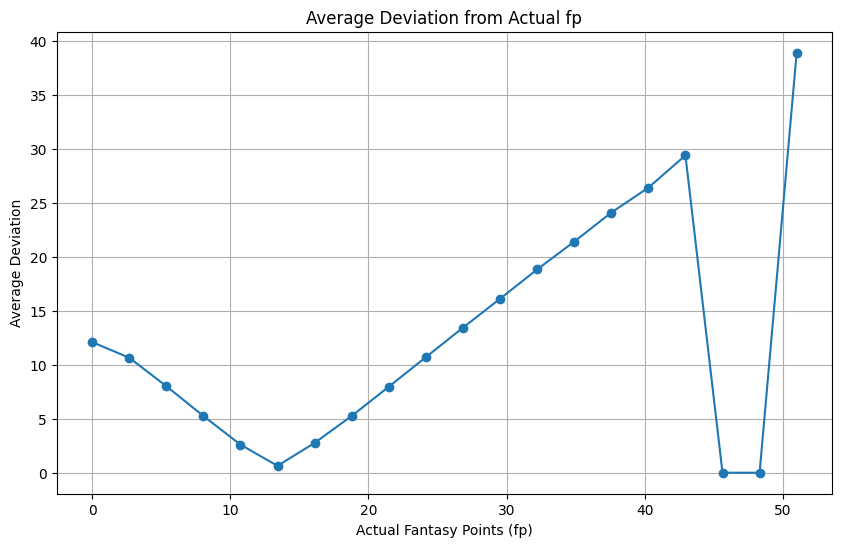

In [99]:
def calculate_deviations(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    deviations = []
    actual_fps = []

    with torch.no_grad():
        for features, actual_fp in data_loader:
            features = features.to(next(model.parameters()).device)
            predictions = model(features).view(-1)
            deviation = torch.abs(predictions - actual_fp.to(predictions.device))

            deviations.extend(deviation.tolist())  # Store deviations
            actual_fps.extend(actual_fp.tolist())  # Store actual fantasy points

    return actual_fps, deviations

import numpy as np

def aggregate_deviations(actual_fps, deviations):
    # Bin actual fps and calculate mean deviation for each bin
    max_fp = max(actual_fps)
    bins = np.linspace(0, max_fp, num=20)  # Adjust the number of bins as needed
    binned_deviations = {bin_: [] for bin_ in bins}

    for actual_fp, deviation in zip(actual_fps, deviations):
        for bin_ in bins:
            if actual_fp <= bin_:
                binned_deviations[bin_].append(deviation)
                break

    # Calculate mean deviations for each bin
    mean_deviations = {bin_: np.mean(devs) if devs else 0 for bin_, devs in binned_deviations.items()}
    return mean_deviations

import matplotlib.pyplot as plt

def plot_deviations(mean_deviations):
    plt.figure(figsize=(10, 6))
    plt.plot(list(mean_deviations.keys()), list(mean_deviations.values()), marker='o')
    plt.xlabel('Actual Fantasy Points (fp)')
    plt.ylabel('Average Deviation')
    plt.title('Average Deviation from Actual fp')
    plt.grid(True)
    plt.show()

actual_fps, deviations = calculate_deviations(model, dataloader)
mean_deviations = aggregate_deviations(actual_fps, deviations)
plot_deviations(mean_deviations)